# Predict RUL with NASA Turbofan Data

Useful documents.
* [How to Implement Machine Learning For Predictive Maintenance](https://towardsdatascience.com/how-to-implement-machine-learning-for-predictive-maintenance-4633cdbe4860)
* [Predictive Maintenance ML (IIoT)](https://www.kaggle.com/billstuart/predictive-maintenance-ml-iiot)

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dataset = pd.read_csv('../input/prehackathonsup/train_data/train_data.csv')

# "engine_no" and "time_in_cycled" are not required in predict operation.
metacol = ['engine_no', 'time_in_cycles']

# ******************* Check Null data *********************** #
null_rate = (dataset.isnull().sum()/dataset.shape[0]) * 100
print(null_rate)

null_col = []
threshold_ratio = 99.5 #(%)

for i, x in enumerate(null_rate.index):
    if null_rate[i] > threshold_ratio:
        null_col.append(x)

# If Null Ratio is greater than threshold_ratio, drop the column from dataset
dataset = dataset.drop(columns=null_col)
print(f'Droppd columns are: {null_col}')
# ************************************************************ #

# Get Engine No. List
engine_list = dataset['engine_no'].drop_duplicates().values

engine_no           0.0
time_in_cycles      0.0
op_setting_1        0.0
op_setting_2        0.0
op_setting_3        0.0
sensor_1            0.0
sensor_2            0.0
sensor_3            0.0
sensor_4            0.0
sensor_5            0.0
sensor_6            0.0
sensor_7            0.0
sensor_8            0.0
sensor_9            0.0
sensor_10           0.0
sensor_11           0.0
sensor_12           0.0
sensor_13           0.0
sensor_14           0.0
sensor_15           0.0
sensor_16           0.0
sensor_17           0.0
sensor_18           0.0
sensor_19           0.0
sensor_20           0.0
sensor_21           0.0
sensor_22         100.0
sensor_23         100.0
sensor_24         100.0
sensor_25         100.0
sensor_26         100.0
sensor_27         100.0
RUL                 0.0
dtype: float64
Droppd columns are: ['sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26', 'sensor_27']


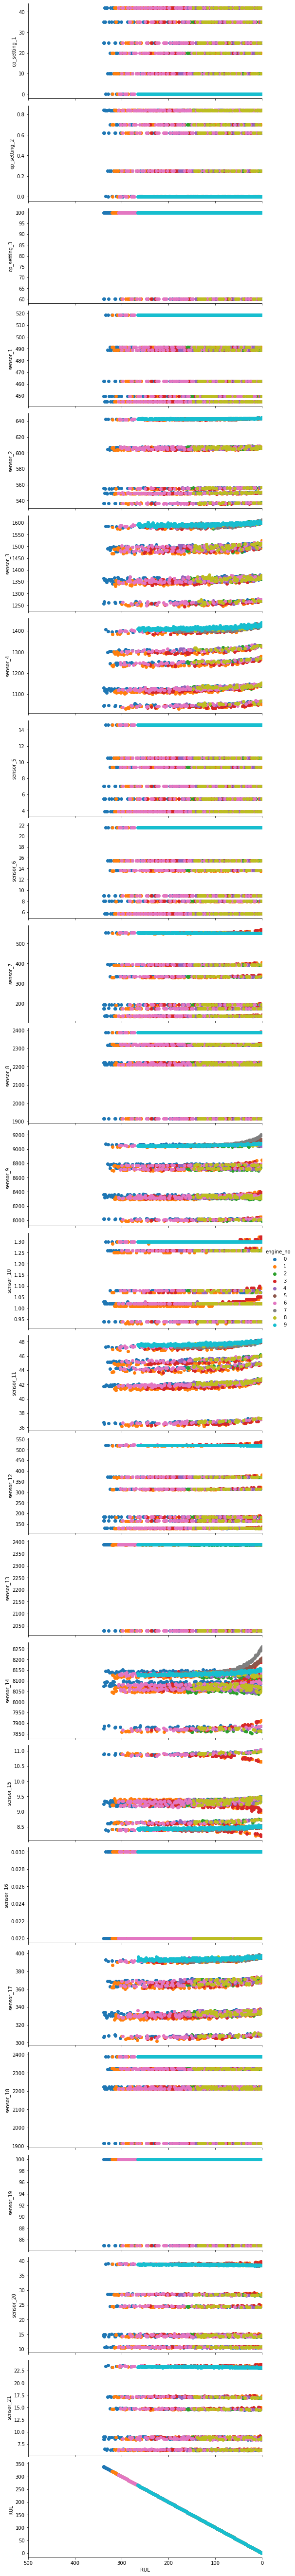

In [3]:
# use seaborn to visualize trend between features and target (RUL)
explore = sns.PairGrid(data=dataset.query('engine_no < 10') ,
                 x_vars=['RUL'],
                 y_vars=dataset.drop(columns=metacol).columns,
                 hue="engine_no", height=3, aspect=2.5)
explore = explore.map(plt.scatter)
explore = explore.set(xlim=(500,0))
explore = explore.add_legend()

## Data Visualization

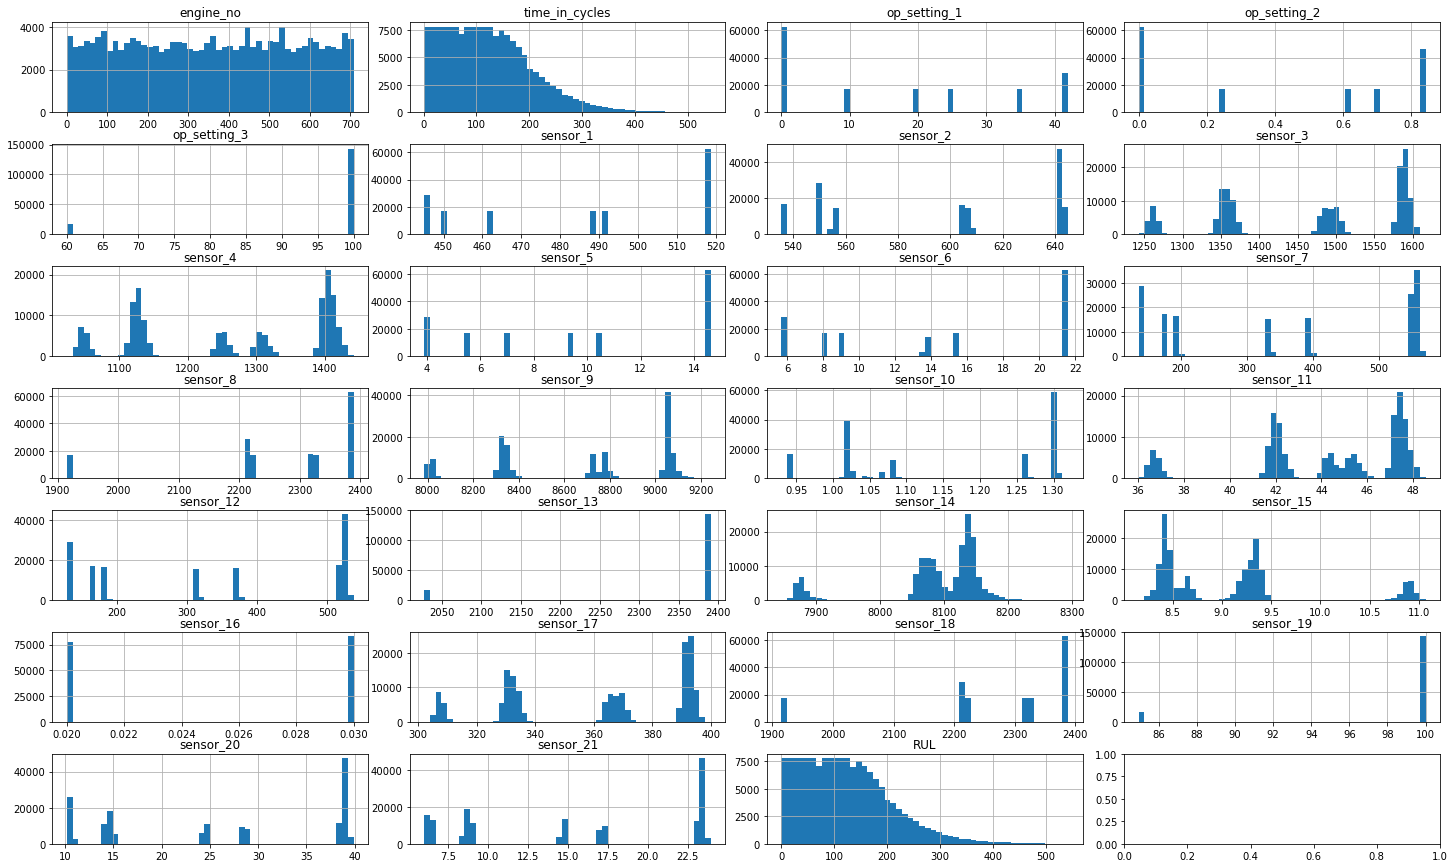

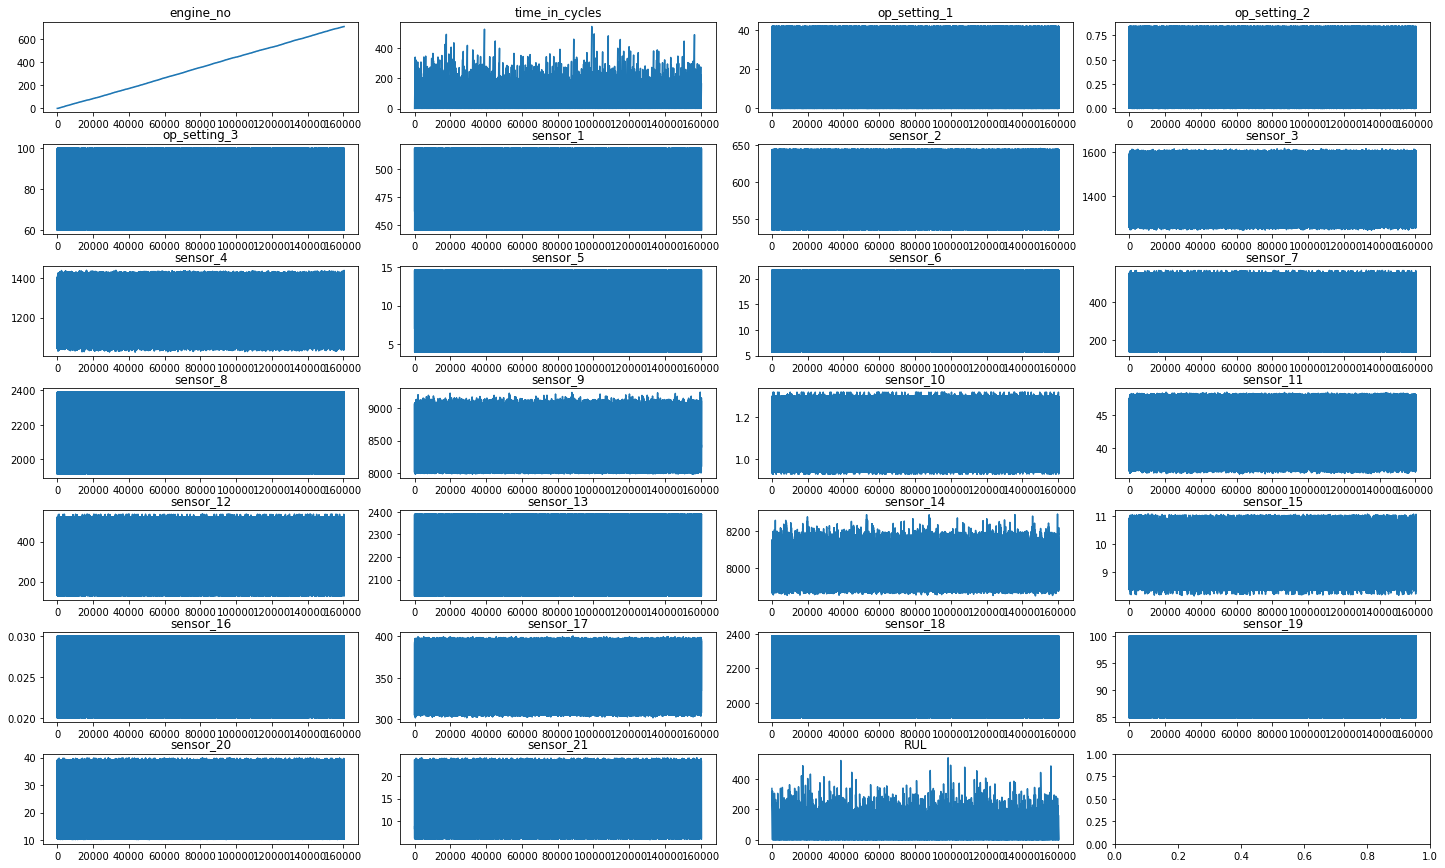

In [6]:
### Draw Histogram with all columns in dataset ###
#************************************************#
def visualize_hist(dataset):
    fig, ax = plt.subplots(ncols=4, nrows=7, figsize=(20,12))
    plt.tight_layout()
    for i, x in enumerate(dataset):
        row = int(i//4)
        col = int(i%4)
        dataset[x].hist(bins=50, ax=ax[row, col])
        ax[row, col].set_title(x)
#************************************************#


### Draw Plot with three "plot_list" columns ###
#**********************************************#
def visualize_plot(dataset):
    fig, ax = plt.subplots(ncols=4, nrows=7, figsize=(20,12))
    plt.tight_layout()
    for i, x in enumerate(dataset):
        row = int(i//4)
        col = int(i%4)
        dataset[x].plot(ax=ax[row, col])
        ax[row, col].set_title(x)
#**********************************************#


visualize_hist(dataset)

# Is there a large outlier??
visualize_plot(dataset)

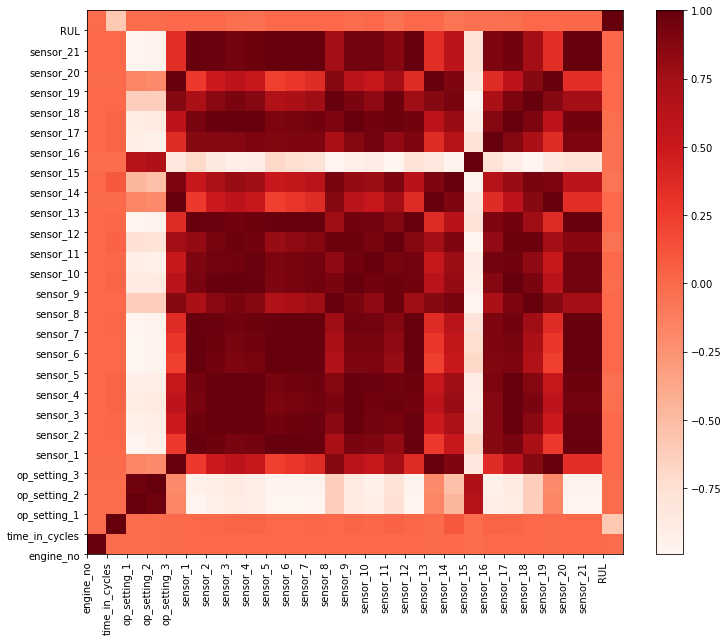

In [7]:
# Check correlation features vs RUL

corr = dataset.corr()
fig, ax = plt.subplots(figsize=(12,10))
heatmap = ax.pcolor(corr, cmap=plt.cm.Reds, vmax=1.0)
ax.set_xticks(np.arange(corr.shape[0]))
ax.set_yticks(np.arange(corr.shape[1]))
ax.set_xticklabels(corr.columns, rotation=90)
ax.set_yticklabels(corr.columns)
fig.colorbar(heatmap, ax=ax)

In [9]:
# Assign Features/Target variable

X = dataset.drop(columns=metacol).iloc[:,:-1]
y = dataset['RUL'].values

In [10]:
# See which features are the most important

from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor()
reg = RandomForestRegressor(n_estimators = 200, max_depth = 15)
reg.fit(X, y)
y_pred = reg.predict(X)
print("complete")

importances = reg.feature_importances_
columns=['col', 'val']
pd_importances = pd.DataFrame(columns=columns)
for i, x in enumerate(X.columns):
    pd_importances.loc[i] = [x, importances[i]]

# Get the most important columns in top10    
important_col = pd_importances.sort_values(by='val', ascending=False).reset_index().loc[:10,'col']
print(important_col)

complete
15    sensor_13
Name: col, dtype: object


In [37]:
# Search the best hyper-parameter using Optuna integrated LightGBM

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import optuna.integration.lightgbm as lgb

params = {
    'objective': 'mean_squared_error',
    'metric': 'rmse'
}

# Data Preprocessing
scaler = StandardScaler()
X = scaler.fit_transform(dataset.loc[:,important_col].values)
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)

trains = lgb.Dataset(X_tr, y_tr)
tests = lgb.Dataset(X_te, y_te)

model = lgb.train(params, trains, valid_sets=tests)
print(f'best params = {model.params}')
print(f'best score = {model.best_score}')
best_params = model.params

[I 2021-02-14 14:17:20,939] A new study created in memory with name: no-name-e51c55d6-088d-4e97-89f4-8e0ce1c67c59
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009410 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.2987
[2]	valid_0's rmse: 75.7351
[3]	valid_0's rmse: 72.632
[4]	valid_0's rmse: 69.9857
[5]	valid_0's rmse: 67.6789
[6]	valid_0's rmse: 65.7039
[7]	valid_0's rmse: 63.944
[8]	valid_0's rmse: 62.4325
[9]	valid_0's rmse: 61.1539
[10]	valid_0's rmse: 60.0279
[11]	valid_0's rmse: 59.054
[12]	valid_0's rmse: 58.1798
[13]	valid_0's rmse: 57.45
[14]	valid_0's rmse: 56.774
[15]	valid_0's rmse: 56.2178
[16]	valid_0's rmse: 55.6807
[17]	valid_0's rmse: 55.2284
[18]	valid_0's rmse: 54.8343
[19]	valid_0's rmse: 54.5086
[20]	valid_0's rmse: 54.18
[21]	valid_0's rmse: 53.8777
[22]	valid_0's rmse: 53.6491
[23]	valid_0's rmse: 53.3889
[2

[305]	valid_0's rmse: 50.0504
[306]	valid_0's rmse: 50.0514
[307]	valid_0's rmse: 50.0511
[308]	valid_0's rmse: 50.0477
[309]	valid_0's rmse: 50.0451
[310]	valid_0's rmse: 50.0446
[311]	valid_0's rmse: 50.0408
[312]	valid_0's rmse: 50.041
[313]	valid_0's rmse: 50.0364
[314]	valid_0's rmse: 50.0369
[315]	valid_0's rmse: 50.0365
[316]	valid_0's rmse: 50.0342
[317]	valid_0's rmse: 50.035
[318]	valid_0's rmse: 50.0367
[319]	valid_0's rmse: 50.0369
[320]	valid_0's rmse: 50.0398
[321]	valid_0's rmse: 50.0419
[322]	valid_0's rmse: 50.0413
[323]	valid_0's rmse: 50.0409
[324]	valid_0's rmse: 50.0394
[325]	valid_0's rmse: 50.0395
[326]	valid_0's rmse: 50.0403
[327]	valid_0's rmse: 50.0386
[328]	valid_0's rmse: 50.0388
[329]	valid_0's rmse: 50.0386
[330]	valid_0's rmse: 50.0346
[331]	valid_0's rmse: 50.0392
[332]	valid_0's rmse: 50.0395
[333]	valid_0's rmse: 50.0423
[334]	valid_0's rmse: 50.0448
[335]	valid_0's rmse: 50.0447
[336]	valid_0's rmse: 50.0441
[337]	valid_0's rmse: 50.044
[338]	valid_0

[592]	valid_0's rmse: 50.0306
[593]	valid_0's rmse: 50.0312
[594]	valid_0's rmse: 50.0322
[595]	valid_0's rmse: 50.03
[596]	valid_0's rmse: 50.0315
[597]	valid_0's rmse: 50.0336
[598]	valid_0's rmse: 50.0316
[599]	valid_0's rmse: 50.0309
[600]	valid_0's rmse: 50.0321
[601]	valid_0's rmse: 50.033
[602]	valid_0's rmse: 50.0351
[603]	valid_0's rmse: 50.0318
[604]	valid_0's rmse: 50.0338
[605]	valid_0's rmse: 50.0318
[606]	valid_0's rmse: 50.0329
[607]	valid_0's rmse: 50.0348
[608]	valid_0's rmse: 50.0347
[609]	valid_0's rmse: 50.0314
[610]	valid_0's rmse: 50.0332
[611]	valid_0's rmse: 50.0342
[612]	valid_0's rmse: 50.035
[613]	valid_0's rmse: 50.036
[614]	valid_0's rmse: 50.0388
[615]	valid_0's rmse: 50.0386
[616]	valid_0's rmse: 50.0389
[617]	valid_0's rmse: 50.0395
[618]	valid_0's rmse: 50.04
[619]	valid_0's rmse: 50.0416
[620]	valid_0's rmse: 50.0398
[621]	valid_0's rmse: 50.0392
[622]	valid_0's rmse: 50.0398
[623]	valid_0's rmse: 50.0414
[624]	valid_0's rmse: 50.0417
[625]	valid_0's r

[910]	valid_0's rmse: 50.163
[911]	valid_0's rmse: 50.1645
[912]	valid_0's rmse: 50.1653
[913]	valid_0's rmse: 50.1699
[914]	valid_0's rmse: 50.171
[915]	valid_0's rmse: 50.1728
[916]	valid_0's rmse: 50.1744
[917]	valid_0's rmse: 50.1784
[918]	valid_0's rmse: 50.1783
[919]	valid_0's rmse: 50.1782
[920]	valid_0's rmse: 50.1794
[921]	valid_0's rmse: 50.1796
[922]	valid_0's rmse: 50.1811
[923]	valid_0's rmse: 50.1832
[924]	valid_0's rmse: 50.1833
[925]	valid_0's rmse: 50.1874
[926]	valid_0's rmse: 50.1882
[927]	valid_0's rmse: 50.1877
[928]	valid_0's rmse: 50.1886
[929]	valid_0's rmse: 50.189
[930]	valid_0's rmse: 50.1904
[931]	valid_0's rmse: 50.1932
[932]	valid_0's rmse: 50.1914
[933]	valid_0's rmse: 50.1919
[934]	valid_0's rmse: 50.192
[935]	valid_0's rmse: 50.1917
[936]	valid_0's rmse: 50.1916
[937]	valid_0's rmse: 50.193
[938]	valid_0's rmse: 50.1936
[939]	valid_0's rmse: 50.1945
[940]	valid_0's rmse: 50.1945
[941]	valid_0's rmse: 50.1964
[942]	valid_0's rmse: 50.1975
[943]	valid_0's

feature_fraction, val_score: 50.212025:  14%|#4        | 1/7 [00:04<00:28,  4.80s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.4553
[2]	valid_0's rmse: 75.8763
[3]	valid_0's rmse: 72.7236
[4]	valid_0's rmse: 70.0216
[5]	valid_0's rmse: 67.6892
[6]	valid_0's rmse: 65.6578
[7]	valid_0's rmse: 63.8866
[8]	valid_0's rmse: 62.3405
[9]	valid_0's rmse: 60.976
[10]	valid_0's rmse: 59.8481
[11]	valid_0's rmse: 58.8342
[12]	valid_0's rmse: 57.9287
[13]	valid_0's rmse: 57.1374
[14]	valid_0's rmse: 56.4939
[15]	valid_0's rmse: 55.9175
[16]	valid_0's rmse: 55.4151
[17]	valid_0's rmse: 54.9392
[18]	valid_0's rmse: 54.5343
[19]	valid_0's rmse: 54.2115
[20]	valid_0's rmse: 53.9309
[21]	valid_0's rmse: 53.6928
[22]	valid_0's rmse: 53.4744
[23]	valid_0's rmse: 53.

[319]	valid_0's rmse: 49.9977
[320]	valid_0's rmse: 49.9999
[321]	valid_0's rmse: 49.9997
[322]	valid_0's rmse: 49.9997
[323]	valid_0's rmse: 50.0007
[324]	valid_0's rmse: 50.001
[325]	valid_0's rmse: 49.9996
[326]	valid_0's rmse: 50.0014
[327]	valid_0's rmse: 50.0028
[328]	valid_0's rmse: 50.0023
[329]	valid_0's rmse: 50.002
[330]	valid_0's rmse: 49.9971
[331]	valid_0's rmse: 49.9977
[332]	valid_0's rmse: 49.999
[333]	valid_0's rmse: 49.9994
[334]	valid_0's rmse: 49.9984
[335]	valid_0's rmse: 50.0002
[336]	valid_0's rmse: 50.0007
[337]	valid_0's rmse: 50.0047
[338]	valid_0's rmse: 50.0029
[339]	valid_0's rmse: 50.0021
[340]	valid_0's rmse: 50.0045
[341]	valid_0's rmse: 50.0057
[342]	valid_0's rmse: 50.0056
[343]	valid_0's rmse: 50.0039
[344]	valid_0's rmse: 50.0046
[345]	valid_0's rmse: 50.0055
[346]	valid_0's rmse: 50.0027
[347]	valid_0's rmse: 50.0021
[348]	valid_0's rmse: 50.0032
[349]	valid_0's rmse: 50.0009
[350]	valid_0's rmse: 49.9969
[351]	valid_0's rmse: 49.9972
[352]	valid_0

[612]	valid_0's rmse: 49.9959
[613]	valid_0's rmse: 49.996
[614]	valid_0's rmse: 49.9962
[615]	valid_0's rmse: 49.9975
[616]	valid_0's rmse: 49.9961
[617]	valid_0's rmse: 49.9944
[618]	valid_0's rmse: 49.9958
[619]	valid_0's rmse: 49.9966
[620]	valid_0's rmse: 49.9956
[621]	valid_0's rmse: 49.9965
[622]	valid_0's rmse: 49.9973
[623]	valid_0's rmse: 49.9982
[624]	valid_0's rmse: 49.9995
[625]	valid_0's rmse: 50.0004
[626]	valid_0's rmse: 50.0015
[627]	valid_0's rmse: 50.0009
[628]	valid_0's rmse: 50
[629]	valid_0's rmse: 49.9977
[630]	valid_0's rmse: 49.9972
[631]	valid_0's rmse: 49.9992
[632]	valid_0's rmse: 50.0004
[633]	valid_0's rmse: 49.9999
[634]	valid_0's rmse: 49.9996
[635]	valid_0's rmse: 49.9986
[636]	valid_0's rmse: 49.999
[637]	valid_0's rmse: 49.9996
[638]	valid_0's rmse: 49.9998
[639]	valid_0's rmse: 49.9978
[640]	valid_0's rmse: 49.9975
[641]	valid_0's rmse: 49.9982
[642]	valid_0's rmse: 49.9998
[643]	valid_0's rmse: 50.0014
[644]	valid_0's rmse: 50.0021
[645]	valid_0's r

[926]	valid_0's rmse: 50.1019
[927]	valid_0's rmse: 50.1012
[928]	valid_0's rmse: 50.1011
[929]	valid_0's rmse: 50.1017
[930]	valid_0's rmse: 50.1034
[931]	valid_0's rmse: 50.1034
[932]	valid_0's rmse: 50.1053
[933]	valid_0's rmse: 50.1053
[934]	valid_0's rmse: 50.1018
[935]	valid_0's rmse: 50.1037
[936]	valid_0's rmse: 50.1029
[937]	valid_0's rmse: 50.103
[938]	valid_0's rmse: 50.1043
[939]	valid_0's rmse: 50.1039
[940]	valid_0's rmse: 50.1041
[941]	valid_0's rmse: 50.1036
[942]	valid_0's rmse: 50.1033
[943]	valid_0's rmse: 50.1036
[944]	valid_0's rmse: 50.1037
[945]	valid_0's rmse: 50.1039
[946]	valid_0's rmse: 50.1032
[947]	valid_0's rmse: 50.1035
[948]	valid_0's rmse: 50.1044
[949]	valid_0's rmse: 50.1022
[950]	valid_0's rmse: 50.1024
[951]	valid_0's rmse: 50.1051
[952]	valid_0's rmse: 50.1072
[953]	valid_0's rmse: 50.1074
[954]	valid_0's rmse: 50.1071
[955]	valid_0's rmse: 50.1102
[956]	valid_0's rmse: 50.1093
[957]	valid_0's rmse: 50.1095
[958]	valid_0's rmse: 50.1102
[959]	valid

feature_fraction, val_score: 50.123050:  29%|##8       | 2/7 [00:09<00:22,  4.48s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006920 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.8506
[2]	valid_0's rmse: 76.432
[3]	valid_0's rmse: 73.4022
[4]	valid_0's rmse: 70.7188
[5]	valid_0's rmse: 68.518
[6]	valid_0's rmse: 66.4999
[7]	valid_0's rmse: 64.5553
[8]	valid_0's rmse: 62.9127
[9]	valid_0's rmse: 61.789
[10]	valid_0's rmse: 60.6741
[11]	valid_0's rmse: 59.7139
[12]	valid_0's rmse: 58.7909
[13]	valid_0's rmse: 58.1001
[14]	valid_0's rmse: 57.2721
[15]	valid_0's rmse: 56.6968
[16]	valid_0's rmse: 56.0968
[17]	valid_0's rmse: 55.6419
[18]	valid_0's rmse: 55.2123
[19]	valid_0's rmse: 54.9068
[20]	valid_0's rmse: 54.6159
[21]	valid_0's rmse: 54.3397
[22]	valid_0's rmse: 54.1102
[23]	valid_0's rmse: 53.87

[292]	valid_0's rmse: 50.2334
[293]	valid_0's rmse: 50.2304
[294]	valid_0's rmse: 50.2344
[295]	valid_0's rmse: 50.2343
[296]	valid_0's rmse: 50.2326
[297]	valid_0's rmse: 50.2343
[298]	valid_0's rmse: 50.2329
[299]	valid_0's rmse: 50.2344
[300]	valid_0's rmse: 50.2301
[301]	valid_0's rmse: 50.2247
[302]	valid_0's rmse: 50.2239
[303]	valid_0's rmse: 50.2231
[304]	valid_0's rmse: 50.2234
[305]	valid_0's rmse: 50.2219
[306]	valid_0's rmse: 50.222
[307]	valid_0's rmse: 50.2228
[308]	valid_0's rmse: 50.2201
[309]	valid_0's rmse: 50.2187
[310]	valid_0's rmse: 50.2184
[311]	valid_0's rmse: 50.2182
[312]	valid_0's rmse: 50.218
[313]	valid_0's rmse: 50.2156
[314]	valid_0's rmse: 50.2152
[315]	valid_0's rmse: 50.2135
[316]	valid_0's rmse: 50.2134
[317]	valid_0's rmse: 50.2113
[318]	valid_0's rmse: 50.2063
[319]	valid_0's rmse: 50.2039
[320]	valid_0's rmse: 50.204
[321]	valid_0's rmse: 50.1991
[322]	valid_0's rmse: 50.2005
[323]	valid_0's rmse: 50.2006
[324]	valid_0's rmse: 50.2041
[325]	valid_0

[627]	valid_0's rmse: 50.0797
[628]	valid_0's rmse: 50.0795
[629]	valid_0's rmse: 50.0799
[630]	valid_0's rmse: 50.0777
[631]	valid_0's rmse: 50.0795
[632]	valid_0's rmse: 50.0809
[633]	valid_0's rmse: 50.0804
[634]	valid_0's rmse: 50.0855
[635]	valid_0's rmse: 50.084
[636]	valid_0's rmse: 50.0848
[637]	valid_0's rmse: 50.0856
[638]	valid_0's rmse: 50.0849
[639]	valid_0's rmse: 50.085
[640]	valid_0's rmse: 50.0846
[641]	valid_0's rmse: 50.0846
[642]	valid_0's rmse: 50.0858
[643]	valid_0's rmse: 50.0859
[644]	valid_0's rmse: 50.085
[645]	valid_0's rmse: 50.0847
[646]	valid_0's rmse: 50.0876
[647]	valid_0's rmse: 50.0877
[648]	valid_0's rmse: 50.088
[649]	valid_0's rmse: 50.0869
[650]	valid_0's rmse: 50.0874
[651]	valid_0's rmse: 50.087
[652]	valid_0's rmse: 50.0866
[653]	valid_0's rmse: 50.0867
[654]	valid_0's rmse: 50.0856
[655]	valid_0's rmse: 50.0878
[656]	valid_0's rmse: 50.0882
[657]	valid_0's rmse: 50.0899
[658]	valid_0's rmse: 50.0887
[659]	valid_0's rmse: 50.0884
[660]	valid_0's

[972]	valid_0's rmse: 50.1653
[973]	valid_0's rmse: 50.1641
[974]	valid_0's rmse: 50.1648
[975]	valid_0's rmse: 50.1644
[976]	valid_0's rmse: 50.1651
[977]	valid_0's rmse: 50.1649
[978]	valid_0's rmse: 50.1607
[979]	valid_0's rmse: 50.1607
[980]	valid_0's rmse: 50.1594
[981]	valid_0's rmse: 50.1591
[982]	valid_0's rmse: 50.1595
[983]	valid_0's rmse: 50.1598
[984]	valid_0's rmse: 50.1593
[985]	valid_0's rmse: 50.1618
[986]	valid_0's rmse: 50.1614
[987]	valid_0's rmse: 50.1626
[988]	valid_0's rmse: 50.1609
[989]	valid_0's rmse: 50.1635
[990]	valid_0's rmse: 50.1651
[991]	valid_0's rmse: 50.1656
[992]	valid_0's rmse: 50.1656
[993]	valid_0's rmse: 50.1648
[994]	valid_0's rmse: 50.1648
[995]	valid_0's rmse: 50.1651
[996]	valid_0's rmse: 50.165
[997]	valid_0's rmse: 50.1619
[998]	valid_0's rmse: 50.1627
[999]	valid_0's rmse: 50.1633
[1000]	valid_0's rmse: 50.1642


feature_fraction, val_score: 50.123050:  43%|####2     | 3/7 [00:12<00:16,  4.11s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008490 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.3075
[2]	valid_0's rmse: 75.7482
[3]	valid_0's rmse: 72.6474
[4]	valid_0's rmse: 69.9812
[5]	valid_0's rmse: 67.6777
[6]	valid_0's rmse: 65.7036
[7]	valid_0's rmse: 63.9687
[8]	valid_0's rmse: 62.4575
[9]	valid_0's rmse: 61.1777
[10]	valid_0's rmse: 60.0068
[11]	valid_0's rmse: 59.0133
[12]	valid_0's rmse: 58.1219
[13]	valid_0's rmse: 57.392
[14]	valid_0's rmse: 56.7749
[15]	valid_0's rmse: 56.2213
[16]	valid_0's rmse: 55.6866
[17]	valid_0's rmse: 55.2136
[18]	valid_0's rmse: 54.8131
[19]	valid_0's rmse: 54.4652
[20]	valid_0's rmse: 54.1433
[21]	valid_0's rmse: 53.8418
[22]	valid_0's rmse: 53.5655
[23]	valid_0's rmse: 53.

[271]	valid_0's rmse: 50.1723
[272]	valid_0's rmse: 50.1736
[273]	valid_0's rmse: 50.1711
[274]	valid_0's rmse: 50.1703
[275]	valid_0's rmse: 50.1701
[276]	valid_0's rmse: 50.1665
[277]	valid_0's rmse: 50.1664
[278]	valid_0's rmse: 50.1641
[279]	valid_0's rmse: 50.1634
[280]	valid_0's rmse: 50.1629
[281]	valid_0's rmse: 50.1617
[282]	valid_0's rmse: 50.1634
[283]	valid_0's rmse: 50.1607
[284]	valid_0's rmse: 50.165
[285]	valid_0's rmse: 50.1655
[286]	valid_0's rmse: 50.1641
[287]	valid_0's rmse: 50.1626
[288]	valid_0's rmse: 50.1618
[289]	valid_0's rmse: 50.1578
[290]	valid_0's rmse: 50.1557
[291]	valid_0's rmse: 50.1539
[292]	valid_0's rmse: 50.155
[293]	valid_0's rmse: 50.1511
[294]	valid_0's rmse: 50.1522
[295]	valid_0's rmse: 50.1532
[296]	valid_0's rmse: 50.1596
[297]	valid_0's rmse: 50.1594
[298]	valid_0's rmse: 50.1552
[299]	valid_0's rmse: 50.1555
[300]	valid_0's rmse: 50.1576
[301]	valid_0's rmse: 50.1571
[302]	valid_0's rmse: 50.1549
[303]	valid_0's rmse: 50.1542
[304]	valid_

[558]	valid_0's rmse: 50.1588
[559]	valid_0's rmse: 50.1617
[560]	valid_0's rmse: 50.1613
[561]	valid_0's rmse: 50.1624
[562]	valid_0's rmse: 50.161
[563]	valid_0's rmse: 50.1604
[564]	valid_0's rmse: 50.1619
[565]	valid_0's rmse: 50.1637
[566]	valid_0's rmse: 50.1623
[567]	valid_0's rmse: 50.1633
[568]	valid_0's rmse: 50.1639
[569]	valid_0's rmse: 50.1664
[570]	valid_0's rmse: 50.1665
[571]	valid_0's rmse: 50.1674
[572]	valid_0's rmse: 50.1677
[573]	valid_0's rmse: 50.1655
[574]	valid_0's rmse: 50.1661
[575]	valid_0's rmse: 50.1665
[576]	valid_0's rmse: 50.1689
[577]	valid_0's rmse: 50.1686
[578]	valid_0's rmse: 50.1686
[579]	valid_0's rmse: 50.1684
[580]	valid_0's rmse: 50.1648
[581]	valid_0's rmse: 50.1638
[582]	valid_0's rmse: 50.1626
[583]	valid_0's rmse: 50.1619
[584]	valid_0's rmse: 50.1634
[585]	valid_0's rmse: 50.1628
[586]	valid_0's rmse: 50.1608
[587]	valid_0's rmse: 50.1588
[588]	valid_0's rmse: 50.159
[589]	valid_0's rmse: 50.1586
[590]	valid_0's rmse: 50.1569
[591]	valid_

[860]	valid_0's rmse: 50.2486
[861]	valid_0's rmse: 50.2487
[862]	valid_0's rmse: 50.2484
[863]	valid_0's rmse: 50.2496
[864]	valid_0's rmse: 50.2509
[865]	valid_0's rmse: 50.2514
[866]	valid_0's rmse: 50.252
[867]	valid_0's rmse: 50.2512
[868]	valid_0's rmse: 50.2502
[869]	valid_0's rmse: 50.2532
[870]	valid_0's rmse: 50.2546
[871]	valid_0's rmse: 50.2551
[872]	valid_0's rmse: 50.2539
[873]	valid_0's rmse: 50.253
[874]	valid_0's rmse: 50.2532
[875]	valid_0's rmse: 50.253
[876]	valid_0's rmse: 50.2513
[877]	valid_0's rmse: 50.2513
[878]	valid_0's rmse: 50.2519
[879]	valid_0's rmse: 50.2523
[880]	valid_0's rmse: 50.2556
[881]	valid_0's rmse: 50.2579
[882]	valid_0's rmse: 50.2586
[883]	valid_0's rmse: 50.259
[884]	valid_0's rmse: 50.26
[885]	valid_0's rmse: 50.2591
[886]	valid_0's rmse: 50.2589
[887]	valid_0's rmse: 50.2564
[888]	valid_0's rmse: 50.2572
[889]	valid_0's rmse: 50.2591
[890]	valid_0's rmse: 50.259
[891]	valid_0's rmse: 50.26
[892]	valid_0's rmse: 50.2597
[893]	valid_0's rms

feature_fraction, val_score: 50.123050:  57%|#####7    | 4/7 [00:18<00:14,  4.72s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008557 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.3926
[2]	valid_0's rmse: 75.798
[3]	valid_0's rmse: 72.6636
[4]	valid_0's rmse: 69.9501
[5]	valid_0's rmse: 67.5925
[6]	valid_0's rmse: 65.5066
[7]	valid_0's rmse: 63.7352
[8]	valid_0's rmse: 62.2034
[9]	valid_0's rmse: 60.8954
[10]	valid_0's rmse: 59.7608
[11]	valid_0's rmse: 58.7755
[12]	valid_0's rmse: 57.9072
[13]	valid_0's rmse: 57.1214
[14]	valid_0's rmse: 56.4848
[15]	valid_0's rmse: 55.9423
[16]	valid_0's rmse: 55.4398
[17]	valid_0's rmse: 54.9696
[18]	valid_0's rmse: 54.5778
[19]	valid_0's rmse: 54.2627
[20]	valid_0's rmse: 53.9823
[21]	valid_0's rmse: 53.7432
[22]	valid_0's rmse: 53.5203
[23]	valid_0's rmse: 53.

[317]	valid_0's rmse: 50.038
[318]	valid_0's rmse: 50.037
[319]	valid_0's rmse: 50.0363
[320]	valid_0's rmse: 50.0373
[321]	valid_0's rmse: 50.0377
[322]	valid_0's rmse: 50.0391
[323]	valid_0's rmse: 50.0394
[324]	valid_0's rmse: 50.0389
[325]	valid_0's rmse: 50.0373
[326]	valid_0's rmse: 50.035
[327]	valid_0's rmse: 50.0337
[328]	valid_0's rmse: 50.0347
[329]	valid_0's rmse: 50.0379
[330]	valid_0's rmse: 50.0377
[331]	valid_0's rmse: 50.0361
[332]	valid_0's rmse: 50.0351
[333]	valid_0's rmse: 50.0318
[334]	valid_0's rmse: 50.0323
[335]	valid_0's rmse: 50.032
[336]	valid_0's rmse: 50.0321
[337]	valid_0's rmse: 50.0327
[338]	valid_0's rmse: 50.0351
[339]	valid_0's rmse: 50.0357
[340]	valid_0's rmse: 50.0349
[341]	valid_0's rmse: 50.0351
[342]	valid_0's rmse: 50.0316
[343]	valid_0's rmse: 50.0326
[344]	valid_0's rmse: 50.031
[345]	valid_0's rmse: 50.0293
[346]	valid_0's rmse: 50.0298
[347]	valid_0's rmse: 50.0299
[348]	valid_0's rmse: 50.0303
[349]	valid_0's rmse: 50.0297
[350]	valid_0's

[597]	valid_0's rmse: 50.042
[598]	valid_0's rmse: 50.0395
[599]	valid_0's rmse: 50.0381
[600]	valid_0's rmse: 50.0374
[601]	valid_0's rmse: 50.0374
[602]	valid_0's rmse: 50.0368
[603]	valid_0's rmse: 50.0391
[604]	valid_0's rmse: 50.0417
[605]	valid_0's rmse: 50.0432
[606]	valid_0's rmse: 50.0429
[607]	valid_0's rmse: 50.0431
[608]	valid_0's rmse: 50.0419
[609]	valid_0's rmse: 50.0436
[610]	valid_0's rmse: 50.0432
[611]	valid_0's rmse: 50.044
[612]	valid_0's rmse: 50.0442
[613]	valid_0's rmse: 50.0445
[614]	valid_0's rmse: 50.0443
[615]	valid_0's rmse: 50.0442
[616]	valid_0's rmse: 50.0448
[617]	valid_0's rmse: 50.0453
[618]	valid_0's rmse: 50.0435
[619]	valid_0's rmse: 50.044
[620]	valid_0's rmse: 50.0473
[621]	valid_0's rmse: 50.0459
[622]	valid_0's rmse: 50.0469
[623]	valid_0's rmse: 50.0484
[624]	valid_0's rmse: 50.049
[625]	valid_0's rmse: 50.0506
[626]	valid_0's rmse: 50.0503
[627]	valid_0's rmse: 50.0504
[628]	valid_0's rmse: 50.0499
[629]	valid_0's rmse: 50.0494
[630]	valid_0'

[889]	valid_0's rmse: 50.178
[890]	valid_0's rmse: 50.1818
[891]	valid_0's rmse: 50.1789
[892]	valid_0's rmse: 50.1815
[893]	valid_0's rmse: 50.1813
[894]	valid_0's rmse: 50.1815
[895]	valid_0's rmse: 50.1811
[896]	valid_0's rmse: 50.1795
[897]	valid_0's rmse: 50.1805
[898]	valid_0's rmse: 50.1811
[899]	valid_0's rmse: 50.1828
[900]	valid_0's rmse: 50.1829
[901]	valid_0's rmse: 50.1793
[902]	valid_0's rmse: 50.1802
[903]	valid_0's rmse: 50.1811
[904]	valid_0's rmse: 50.1821
[905]	valid_0's rmse: 50.182
[906]	valid_0's rmse: 50.1825
[907]	valid_0's rmse: 50.1809
[908]	valid_0's rmse: 50.1815
[909]	valid_0's rmse: 50.1807
[910]	valid_0's rmse: 50.1818
[911]	valid_0's rmse: 50.18
[912]	valid_0's rmse: 50.1778
[913]	valid_0's rmse: 50.1797
[914]	valid_0's rmse: 50.1804
[915]	valid_0's rmse: 50.181
[916]	valid_0's rmse: 50.1797
[917]	valid_0's rmse: 50.1815
[918]	valid_0's rmse: 50.1813
[919]	valid_0's rmse: 50.1837
[920]	valid_0's rmse: 50.1846
[921]	valid_0's rmse: 50.1843
[922]	valid_0's

feature_fraction, val_score: 50.123050:  71%|#######1  | 5/7 [00:22<00:09,  4.62s/it]

[999]	valid_0's rmse: 50.2016
[1000]	valid_0's rmse: 50.2026
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.4553
[2]	valid_0's rmse: 76.0296
[3]	valid_0's rmse: 72.894
[4]	valid_0's rmse: 70.1674
[5]	valid_0's rmse: 67.7768
[6]	valid_0's rmse: 65.8172
[7]	valid_0's rmse: 64.0432
[8]	valid_0's rmse: 62.3817
[9]	valid_0's rmse: 61.0398
[10]	valid_0's rmse: 59.8189
[11]	valid_0's rmse: 58.7936
[12]	valid_0's rmse: 57.884
[13]	valid_0's rmse: 57.0727
[14]	valid_0's rmse: 56.3786
[15]	valid_0's rmse: 55.7879
[16]	valid_0's rmse: 55.276
[17]	valid_0's rmse: 54.8009
[18]	valid_0's rmse: 54.3425
[19]	valid_0's rmse: 54.0213
[20]	valid_0's rmse: 53.7504
[21]	valid_0's rmse: 53

[271]	valid_0's rmse: 50.0062
[272]	valid_0's rmse: 50.0085
[273]	valid_0's rmse: 50.0094
[274]	valid_0's rmse: 50.0103
[275]	valid_0's rmse: 50.0098
[276]	valid_0's rmse: 50.008
[277]	valid_0's rmse: 50.0057
[278]	valid_0's rmse: 50.0059
[279]	valid_0's rmse: 50.0035
[280]	valid_0's rmse: 50.0027
[281]	valid_0's rmse: 50.0028
[282]	valid_0's rmse: 50.0025
[283]	valid_0's rmse: 50.0006
[284]	valid_0's rmse: 50.0018
[285]	valid_0's rmse: 50.0007
[286]	valid_0's rmse: 49.9981
[287]	valid_0's rmse: 49.9973
[288]	valid_0's rmse: 49.9987
[289]	valid_0's rmse: 49.9943
[290]	valid_0's rmse: 49.9948
[291]	valid_0's rmse: 49.9947
[292]	valid_0's rmse: 49.9933
[293]	valid_0's rmse: 49.9901
[294]	valid_0's rmse: 49.9885
[295]	valid_0's rmse: 49.984
[296]	valid_0's rmse: 49.9831
[297]	valid_0's rmse: 49.9835
[298]	valid_0's rmse: 49.985
[299]	valid_0's rmse: 49.9863
[300]	valid_0's rmse: 49.9792
[301]	valid_0's rmse: 49.9793
[302]	valid_0's rmse: 49.9795
[303]	valid_0's rmse: 49.9782
[304]	valid_0

[579]	valid_0's rmse: 49.96
[580]	valid_0's rmse: 49.9595
[581]	valid_0's rmse: 49.9595
[582]	valid_0's rmse: 49.9576
[583]	valid_0's rmse: 49.9578
[584]	valid_0's rmse: 49.959
[585]	valid_0's rmse: 49.9587
[586]	valid_0's rmse: 49.9596
[587]	valid_0's rmse: 49.9589
[588]	valid_0's rmse: 49.9595
[589]	valid_0's rmse: 49.9594
[590]	valid_0's rmse: 49.9604
[591]	valid_0's rmse: 49.9604
[592]	valid_0's rmse: 49.9611
[593]	valid_0's rmse: 49.9602
[594]	valid_0's rmse: 49.9611
[595]	valid_0's rmse: 49.96
[596]	valid_0's rmse: 49.9604
[597]	valid_0's rmse: 49.9616
[598]	valid_0's rmse: 49.9613
[599]	valid_0's rmse: 49.9622
[600]	valid_0's rmse: 49.9637
[601]	valid_0's rmse: 49.9621
[602]	valid_0's rmse: 49.963
[603]	valid_0's rmse: 49.9645
[604]	valid_0's rmse: 49.9654
[605]	valid_0's rmse: 49.9656
[606]	valid_0's rmse: 49.9661
[607]	valid_0's rmse: 49.9678
[608]	valid_0's rmse: 49.9683
[609]	valid_0's rmse: 49.9686
[610]	valid_0's rmse: 49.9682
[611]	valid_0's rmse: 49.9689
[612]	valid_0's 

[894]	valid_0's rmse: 50.0462
[895]	valid_0's rmse: 50.0459
[896]	valid_0's rmse: 50.0456
[897]	valid_0's rmse: 50.0482
[898]	valid_0's rmse: 50.0491
[899]	valid_0's rmse: 50.0499
[900]	valid_0's rmse: 50.0505
[901]	valid_0's rmse: 50.0524
[902]	valid_0's rmse: 50.0516
[903]	valid_0's rmse: 50.0517
[904]	valid_0's rmse: 50.0516
[905]	valid_0's rmse: 50.0524
[906]	valid_0's rmse: 50.0513
[907]	valid_0's rmse: 50.0512
[908]	valid_0's rmse: 50.0501
[909]	valid_0's rmse: 50.0509
[910]	valid_0's rmse: 50.0514
[911]	valid_0's rmse: 50.055
[912]	valid_0's rmse: 50.0547
[913]	valid_0's rmse: 50.0555
[914]	valid_0's rmse: 50.0557
[915]	valid_0's rmse: 50.0553
[916]	valid_0's rmse: 50.0568
[917]	valid_0's rmse: 50.0572
[918]	valid_0's rmse: 50.0568
[919]	valid_0's rmse: 50.057
[920]	valid_0's rmse: 50.0573
[921]	valid_0's rmse: 50.0567
[922]	valid_0's rmse: 50.0579
[923]	valid_0's rmse: 50.0591
[924]	valid_0's rmse: 50.0594
[925]	valid_0's rmse: 50.0584
[926]	valid_0's rmse: 50.058
[927]	valid_0

feature_fraction, val_score: 50.086755:  86%|########5 | 6/7 [00:26<00:04,  4.39s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008169 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.3912
[2]	valid_0's rmse: 75.7238
[3]	valid_0's rmse: 72.5926
[4]	valid_0's rmse: 69.9101
[5]	valid_0's rmse: 67.547
[6]	valid_0's rmse: 65.5365
[7]	valid_0's rmse: 63.8245
[8]	valid_0's rmse: 62.3237
[9]	valid_0's rmse: 61.0309
[10]	valid_0's rmse: 59.9306
[11]	valid_0's rmse: 58.9634
[12]	valid_0's rmse: 58.0728
[13]	valid_0's rmse: 57.323
[14]	valid_0's rmse: 56.6626
[15]	valid_0's rmse: 56.1325
[16]	valid_0's rmse: 55.6404
[17]	valid_0's rmse: 55.208
[18]	valid_0's rmse: 54.8152
[19]	valid_0's rmse: 54.4571
[20]	valid_0's rmse: 54.1358
[21]	valid_0's rmse: 53.8381
[22]	valid_0's rmse: 53.6141
[23]	valid_0's rmse: 53.37

[279]	valid_0's rmse: 50.0726
[280]	valid_0's rmse: 50.075
[281]	valid_0's rmse: 50.076
[282]	valid_0's rmse: 50.0778
[283]	valid_0's rmse: 50.0752
[284]	valid_0's rmse: 50.074
[285]	valid_0's rmse: 50.0705
[286]	valid_0's rmse: 50.071
[287]	valid_0's rmse: 50.07
[288]	valid_0's rmse: 50.0689
[289]	valid_0's rmse: 50.0689
[290]	valid_0's rmse: 50.0678
[291]	valid_0's rmse: 50.0646
[292]	valid_0's rmse: 50.0618
[293]	valid_0's rmse: 50.061
[294]	valid_0's rmse: 50.0593
[295]	valid_0's rmse: 50.0555
[296]	valid_0's rmse: 50.0542
[297]	valid_0's rmse: 50.0536
[298]	valid_0's rmse: 50.0529
[299]	valid_0's rmse: 50.0514
[300]	valid_0's rmse: 50.0497
[301]	valid_0's rmse: 50.0469
[302]	valid_0's rmse: 50.048
[303]	valid_0's rmse: 50.0488
[304]	valid_0's rmse: 50.0478
[305]	valid_0's rmse: 50.0438
[306]	valid_0's rmse: 50.0433
[307]	valid_0's rmse: 50.0431
[308]	valid_0's rmse: 50.0426
[309]	valid_0's rmse: 50.0433
[310]	valid_0's rmse: 50.0435
[311]	valid_0's rmse: 50.0425
[312]	valid_0's rm

[583]	valid_0's rmse: 50.0468
[584]	valid_0's rmse: 50.0462
[585]	valid_0's rmse: 50.0476
[586]	valid_0's rmse: 50.0472
[587]	valid_0's rmse: 50.0475
[588]	valid_0's rmse: 50.0478
[589]	valid_0's rmse: 50.048
[590]	valid_0's rmse: 50.0481
[591]	valid_0's rmse: 50.0502
[592]	valid_0's rmse: 50.0512
[593]	valid_0's rmse: 50.0517
[594]	valid_0's rmse: 50.052
[595]	valid_0's rmse: 50.0477
[596]	valid_0's rmse: 50.0468
[597]	valid_0's rmse: 50.0462
[598]	valid_0's rmse: 50.0473
[599]	valid_0's rmse: 50.0477
[600]	valid_0's rmse: 50.0472
[601]	valid_0's rmse: 50.0453
[602]	valid_0's rmse: 50.0435
[603]	valid_0's rmse: 50.0408
[604]	valid_0's rmse: 50.0406
[605]	valid_0's rmse: 50.041
[606]	valid_0's rmse: 50.0411
[607]	valid_0's rmse: 50.0411
[608]	valid_0's rmse: 50.0427
[609]	valid_0's rmse: 50.0464
[610]	valid_0's rmse: 50.0488
[611]	valid_0's rmse: 50.0492
[612]	valid_0's rmse: 50.0492
[613]	valid_0's rmse: 50.0504
[614]	valid_0's rmse: 50.0498
[615]	valid_0's rmse: 50.0524
[616]	valid_0

[908]	valid_0's rmse: 50.152
[909]	valid_0's rmse: 50.1512
[910]	valid_0's rmse: 50.1521
[911]	valid_0's rmse: 50.153
[912]	valid_0's rmse: 50.1529
[913]	valid_0's rmse: 50.1538
[914]	valid_0's rmse: 50.1541
[915]	valid_0's rmse: 50.155
[916]	valid_0's rmse: 50.1557
[917]	valid_0's rmse: 50.1565
[918]	valid_0's rmse: 50.1585
[919]	valid_0's rmse: 50.1595
[920]	valid_0's rmse: 50.1597
[921]	valid_0's rmse: 50.1602
[922]	valid_0's rmse: 50.1595
[923]	valid_0's rmse: 50.1597
[924]	valid_0's rmse: 50.1578
[925]	valid_0's rmse: 50.157
[926]	valid_0's rmse: 50.1584
[927]	valid_0's rmse: 50.1571
[928]	valid_0's rmse: 50.1564
[929]	valid_0's rmse: 50.1567
[930]	valid_0's rmse: 50.1569
[931]	valid_0's rmse: 50.1585
[932]	valid_0's rmse: 50.1606
[933]	valid_0's rmse: 50.1627
[934]	valid_0's rmse: 50.164
[935]	valid_0's rmse: 50.1642
[936]	valid_0's rmse: 50.1651
[937]	valid_0's rmse: 50.1638
[938]	valid_0's rmse: 50.1639
[939]	valid_0's rmse: 50.1648
[940]	valid_0's rmse: 50.1652
[941]	valid_0's

num_leaves, val_score: 50.086755:   0%|          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 78.8917
[2]	valid_0's rmse: 74.9515
[3]	valid_0's rmse: 71.4001
[4]	valid_0's rmse: 68.3847
[5]	valid_0's rmse: 65.712
[6]	valid_0's rmse: 63.4883
[7]	valid_0's rmse: 61.5115
[8]	valid_0's rmse: 59.7899
[9]	valid_0's rmse: 58.3272
[10]	valid_0's rmse: 57.1271
[11]	valid_0's rmse: 56.0455
[12]	valid_0's rmse: 55.1224
[13]	valid_0's rmse: 54.2992
[14]	valid_0's rmse: 53.6651
[15]	valid_0's rmse: 53.1442
[16]	valid_0's rmse: 52.7144
[17]	valid_0's rmse: 52.2863
[18]	valid_0's rmse: 51.9145
[19]	valid_0's rmse: 51.6538
[20]	valid_0's rmse: 51.449
[21]	valid_0's rmse: 51.2734
[22]	valid_0's rmse: 51.1147
[23]	valid_0's rmse: 50.9

[268]	valid_0's rmse: 50.1516
[269]	valid_0's rmse: 50.1558
[270]	valid_0's rmse: 50.156
[271]	valid_0's rmse: 50.1611
[272]	valid_0's rmse: 50.1591
[273]	valid_0's rmse: 50.1619
[274]	valid_0's rmse: 50.1642
[275]	valid_0's rmse: 50.1629
[276]	valid_0's rmse: 50.1639
[277]	valid_0's rmse: 50.1672
[278]	valid_0's rmse: 50.168
[279]	valid_0's rmse: 50.1716
[280]	valid_0's rmse: 50.1757
[281]	valid_0's rmse: 50.1759
[282]	valid_0's rmse: 50.1774
[283]	valid_0's rmse: 50.1764
[284]	valid_0's rmse: 50.1745
[285]	valid_0's rmse: 50.1756
[286]	valid_0's rmse: 50.1787
[287]	valid_0's rmse: 50.1808
[288]	valid_0's rmse: 50.1832
[289]	valid_0's rmse: 50.1867
[290]	valid_0's rmse: 50.1868
[291]	valid_0's rmse: 50.1902
[292]	valid_0's rmse: 50.1938
[293]	valid_0's rmse: 50.1941
[294]	valid_0's rmse: 50.1954
[295]	valid_0's rmse: 50.196
[296]	valid_0's rmse: 50.197
[297]	valid_0's rmse: 50.2021
[298]	valid_0's rmse: 50.2028
[299]	valid_0's rmse: 50.2017
[300]	valid_0's rmse: 50.2025
[301]	valid_0'

[554]	valid_0's rmse: 50.6254
[555]	valid_0's rmse: 50.6259
[556]	valid_0's rmse: 50.6239
[557]	valid_0's rmse: 50.6231
[558]	valid_0's rmse: 50.6248
[559]	valid_0's rmse: 50.6292
[560]	valid_0's rmse: 50.6317
[561]	valid_0's rmse: 50.6316
[562]	valid_0's rmse: 50.638
[563]	valid_0's rmse: 50.6386
[564]	valid_0's rmse: 50.6412
[565]	valid_0's rmse: 50.6444
[566]	valid_0's rmse: 50.6458
[567]	valid_0's rmse: 50.6461
[568]	valid_0's rmse: 50.6475
[569]	valid_0's rmse: 50.6491
[570]	valid_0's rmse: 50.6524
[571]	valid_0's rmse: 50.6504
[572]	valid_0's rmse: 50.6538
[573]	valid_0's rmse: 50.6568
[574]	valid_0's rmse: 50.6542
[575]	valid_0's rmse: 50.6569
[576]	valid_0's rmse: 50.6587
[577]	valid_0's rmse: 50.6647
[578]	valid_0's rmse: 50.6661
[579]	valid_0's rmse: 50.6673
[580]	valid_0's rmse: 50.672
[581]	valid_0's rmse: 50.6756
[582]	valid_0's rmse: 50.6778
[583]	valid_0's rmse: 50.6802
[584]	valid_0's rmse: 50.6817
[585]	valid_0's rmse: 50.6828
[586]	valid_0's rmse: 50.6854
[587]	valid_

[845]	valid_0's rmse: 51.0564
[846]	valid_0's rmse: 51.0606
[847]	valid_0's rmse: 51.0635
[848]	valid_0's rmse: 51.0647
[849]	valid_0's rmse: 51.0675
[850]	valid_0's rmse: 51.0691
[851]	valid_0's rmse: 51.0687
[852]	valid_0's rmse: 51.07
[853]	valid_0's rmse: 51.0701
[854]	valid_0's rmse: 51.0709
[855]	valid_0's rmse: 51.071
[856]	valid_0's rmse: 51.0714
[857]	valid_0's rmse: 51.0719
[858]	valid_0's rmse: 51.0728
[859]	valid_0's rmse: 51.0752
[860]	valid_0's rmse: 51.0756
[861]	valid_0's rmse: 51.0752
[862]	valid_0's rmse: 51.0755
[863]	valid_0's rmse: 51.0772
[864]	valid_0's rmse: 51.078
[865]	valid_0's rmse: 51.0789
[866]	valid_0's rmse: 51.0791
[867]	valid_0's rmse: 51.0833
[868]	valid_0's rmse: 51.0851
[869]	valid_0's rmse: 51.0856
[870]	valid_0's rmse: 51.0849
[871]	valid_0's rmse: 51.0848
[872]	valid_0's rmse: 51.0849
[873]	valid_0's rmse: 51.0851
[874]	valid_0's rmse: 51.0862
[875]	valid_0's rmse: 51.0899
[876]	valid_0's rmse: 51.0886
[877]	valid_0's rmse: 51.0911
[878]	valid_0'

num_leaves, val_score: 50.086755:   5%|5         | 1/20 [00:09<02:54,  9.16s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007472 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 80.9534
[2]	valid_0's rmse: 78.7263
[3]	valid_0's rmse: 76.3626
[4]	valid_0's rmse: 74.1709
[5]	valid_0's rmse: 72.1863
[6]	valid_0's rmse: 70.6361
[7]	valid_0's rmse: 69.1789
[8]	valid_0's rmse: 68.0372
[9]	valid_0's rmse: 66.9986
[10]	valid_0's rmse: 65.7243
[11]	valid_0's rmse: 64.9262
[12]	valid_0's rmse: 64.0084
[13]	valid_0's rmse: 63.2108
[14]	valid_0's rmse: 62.3692
[15]	valid_0's rmse: 61.7949
[16]	valid_0's rmse: 61.1099
[17]	valid_0's rmse: 60.459
[18]	valid_0's rmse: 59.9858
[19]	valid_0's rmse: 59.4398
[20]	valid_0's rmse: 59.0026
[21]	valid_0's rmse: 58.6187
[22]	valid_0's rmse: 58.3318
[23]	valid_0's rmse: 58.

[325]	valid_0's rmse: 50.8771
[326]	valid_0's rmse: 50.875
[327]	valid_0's rmse: 50.8698
[328]	valid_0's rmse: 50.8682
[329]	valid_0's rmse: 50.8652
[330]	valid_0's rmse: 50.8548
[331]	valid_0's rmse: 50.8522
[332]	valid_0's rmse: 50.8497
[333]	valid_0's rmse: 50.8461
[334]	valid_0's rmse: 50.8433
[335]	valid_0's rmse: 50.8418
[336]	valid_0's rmse: 50.8405
[337]	valid_0's rmse: 50.8393
[338]	valid_0's rmse: 50.8387
[339]	valid_0's rmse: 50.8373
[340]	valid_0's rmse: 50.8341
[341]	valid_0's rmse: 50.8293
[342]	valid_0's rmse: 50.8268
[343]	valid_0's rmse: 50.8244
[344]	valid_0's rmse: 50.8235
[345]	valid_0's rmse: 50.8236
[346]	valid_0's rmse: 50.8223
[347]	valid_0's rmse: 50.8203
[348]	valid_0's rmse: 50.8151
[349]	valid_0's rmse: 50.8128
[350]	valid_0's rmse: 50.8107
[351]	valid_0's rmse: 50.8091
[352]	valid_0's rmse: 50.8033
[353]	valid_0's rmse: 50.8009
[354]	valid_0's rmse: 50.7998
[355]	valid_0's rmse: 50.7981
[356]	valid_0's rmse: 50.792
[357]	valid_0's rmse: 50.7914
[358]	valid_

[608]	valid_0's rmse: 50.3138
[609]	valid_0's rmse: 50.3142
[610]	valid_0's rmse: 50.3139
[611]	valid_0's rmse: 50.3111
[612]	valid_0's rmse: 50.3116
[613]	valid_0's rmse: 50.3114
[614]	valid_0's rmse: 50.3107
[615]	valid_0's rmse: 50.3079
[616]	valid_0's rmse: 50.3081
[617]	valid_0's rmse: 50.3073
[618]	valid_0's rmse: 50.3064
[619]	valid_0's rmse: 50.3065
[620]	valid_0's rmse: 50.3053
[621]	valid_0's rmse: 50.305
[622]	valid_0's rmse: 50.3048
[623]	valid_0's rmse: 50.3043
[624]	valid_0's rmse: 50.3036
[625]	valid_0's rmse: 50.3024
[626]	valid_0's rmse: 50.3007
[627]	valid_0's rmse: 50.3003
[628]	valid_0's rmse: 50.2993
[629]	valid_0's rmse: 50.2977
[630]	valid_0's rmse: 50.2937
[631]	valid_0's rmse: 50.2927
[632]	valid_0's rmse: 50.2931
[633]	valid_0's rmse: 50.2912
[634]	valid_0's rmse: 50.2901
[635]	valid_0's rmse: 50.2888
[636]	valid_0's rmse: 50.2861
[637]	valid_0's rmse: 50.2858
[638]	valid_0's rmse: 50.2873
[639]	valid_0's rmse: 50.2881
[640]	valid_0's rmse: 50.2856
[641]	valid

[912]	valid_0's rmse: 50.1024
[913]	valid_0's rmse: 50.1021
[914]	valid_0's rmse: 50.1021
[915]	valid_0's rmse: 50.1024
[916]	valid_0's rmse: 50.1023
[917]	valid_0's rmse: 50.1018
[918]	valid_0's rmse: 50.1009
[919]	valid_0's rmse: 50.1006
[920]	valid_0's rmse: 50.1002
[921]	valid_0's rmse: 50.1001
[922]	valid_0's rmse: 50.1
[923]	valid_0's rmse: 50.0993
[924]	valid_0's rmse: 50.0992
[925]	valid_0's rmse: 50.0985
[926]	valid_0's rmse: 50.0979
[927]	valid_0's rmse: 50.0983
[928]	valid_0's rmse: 50.0992
[929]	valid_0's rmse: 50.0988
[930]	valid_0's rmse: 50.0996
[931]	valid_0's rmse: 50.0998
[932]	valid_0's rmse: 50.0993
[933]	valid_0's rmse: 50.0954
[934]	valid_0's rmse: 50.0957
[935]	valid_0's rmse: 50.0943
[936]	valid_0's rmse: 50.0942
[937]	valid_0's rmse: 50.0945
[938]	valid_0's rmse: 50.0935
[939]	valid_0's rmse: 50.0938
[940]	valid_0's rmse: 50.0978
[941]	valid_0's rmse: 50.0966
[942]	valid_0's rmse: 50.0964
[943]	valid_0's rmse: 50.0962
[944]	valid_0's rmse: 50.0966
[945]	valid_0

num_leaves, val_score: 50.082737:  10%|#         | 2/20 [00:12<01:42,  5.70s/it]

[996]	valid_0's rmse: 50.0827
[997]	valid_0's rmse: 50.0825
[998]	valid_0's rmse: 50.0819
[999]	valid_0's rmse: 50.0825
[1000]	valid_0's rmse: 50.0827
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 78.9519
[2]	valid_0's rmse: 75.0764
[3]	valid_0's rmse: 71.594
[4]	valid_0's rmse: 68.6016
[5]	valid_0's rmse: 65.989
[6]	valid_0's rmse: 63.8282
[7]	valid_0's rmse: 61.8853
[8]	valid_0's rmse: 60.1617
[9]	valid_0's rmse: 58.708
[10]	valid_0's rmse: 57.5002
[11]	valid_0's rmse: 56.4157
[12]	valid_0's rmse: 55.5102
[13]	valid_0's rmse: 54.6835
[14]	valid_0's rmse: 54.0221
[15]	valid_0's rmse: 53.4916
[16]	valid_0's rmse: 53.0375
[17]	valid_0's rmse: 52.5929
[18]	valid_0's rmse:

[275]	valid_0's rmse: 50.1139
[276]	valid_0's rmse: 50.1131
[277]	valid_0's rmse: 50.113
[278]	valid_0's rmse: 50.1134
[279]	valid_0's rmse: 50.1153
[280]	valid_0's rmse: 50.117
[281]	valid_0's rmse: 50.1162
[282]	valid_0's rmse: 50.1199
[283]	valid_0's rmse: 50.1203
[284]	valid_0's rmse: 50.1246
[285]	valid_0's rmse: 50.1267
[286]	valid_0's rmse: 50.1267
[287]	valid_0's rmse: 50.1287
[288]	valid_0's rmse: 50.1284
[289]	valid_0's rmse: 50.1325
[290]	valid_0's rmse: 50.1343
[291]	valid_0's rmse: 50.141
[292]	valid_0's rmse: 50.1438
[293]	valid_0's rmse: 50.1448
[294]	valid_0's rmse: 50.1481
[295]	valid_0's rmse: 50.149
[296]	valid_0's rmse: 50.15
[297]	valid_0's rmse: 50.1491
[298]	valid_0's rmse: 50.1515
[299]	valid_0's rmse: 50.153
[300]	valid_0's rmse: 50.1511
[301]	valid_0's rmse: 50.151
[302]	valid_0's rmse: 50.1546
[303]	valid_0's rmse: 50.1583
[304]	valid_0's rmse: 50.1577
[305]	valid_0's rmse: 50.1596
[306]	valid_0's rmse: 50.1631
[307]	valid_0's rmse: 50.1646
[308]	valid_0's rm

[568]	valid_0's rmse: 50.4339
[569]	valid_0's rmse: 50.4378
[570]	valid_0's rmse: 50.4412
[571]	valid_0's rmse: 50.4399
[572]	valid_0's rmse: 50.4424
[573]	valid_0's rmse: 50.4428
[574]	valid_0's rmse: 50.4464
[575]	valid_0's rmse: 50.4414
[576]	valid_0's rmse: 50.4455
[577]	valid_0's rmse: 50.4455
[578]	valid_0's rmse: 50.4446
[579]	valid_0's rmse: 50.444
[580]	valid_0's rmse: 50.4469
[581]	valid_0's rmse: 50.4471
[582]	valid_0's rmse: 50.4464
[583]	valid_0's rmse: 50.4481
[584]	valid_0's rmse: 50.4473
[585]	valid_0's rmse: 50.4482
[586]	valid_0's rmse: 50.4481
[587]	valid_0's rmse: 50.4482
[588]	valid_0's rmse: 50.4534
[589]	valid_0's rmse: 50.453
[590]	valid_0's rmse: 50.4574
[591]	valid_0's rmse: 50.4609
[592]	valid_0's rmse: 50.4609
[593]	valid_0's rmse: 50.4614
[594]	valid_0's rmse: 50.4628
[595]	valid_0's rmse: 50.463
[596]	valid_0's rmse: 50.463
[597]	valid_0's rmse: 50.4636
[598]	valid_0's rmse: 50.4646
[599]	valid_0's rmse: 50.465
[600]	valid_0's rmse: 50.4644
[601]	valid_0's

[858]	valid_0's rmse: 50.7682
[859]	valid_0's rmse: 50.7728
[860]	valid_0's rmse: 50.7752
[861]	valid_0's rmse: 50.7758
[862]	valid_0's rmse: 50.777
[863]	valid_0's rmse: 50.7789
[864]	valid_0's rmse: 50.7802
[865]	valid_0's rmse: 50.7802
[866]	valid_0's rmse: 50.7801
[867]	valid_0's rmse: 50.7794
[868]	valid_0's rmse: 50.7802
[869]	valid_0's rmse: 50.7809
[870]	valid_0's rmse: 50.7817
[871]	valid_0's rmse: 50.7841
[872]	valid_0's rmse: 50.784
[873]	valid_0's rmse: 50.7831
[874]	valid_0's rmse: 50.7845
[875]	valid_0's rmse: 50.7857
[876]	valid_0's rmse: 50.7855
[877]	valid_0's rmse: 50.7885
[878]	valid_0's rmse: 50.7896
[879]	valid_0's rmse: 50.7914
[880]	valid_0's rmse: 50.793
[881]	valid_0's rmse: 50.7935
[882]	valid_0's rmse: 50.7963
[883]	valid_0's rmse: 50.7969
[884]	valid_0's rmse: 50.7962
[885]	valid_0's rmse: 50.7973
[886]	valid_0's rmse: 50.8027
[887]	valid_0's rmse: 50.8039
[888]	valid_0's rmse: 50.8049
[889]	valid_0's rmse: 50.8065
[890]	valid_0's rmse: 50.8091
[891]	valid_0

num_leaves, val_score: 50.082737:  15%|#5        | 3/20 [00:20<01:56,  6.88s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 78.8313
[2]	valid_0's rmse: 74.7907
[3]	valid_0's rmse: 71.1925
[4]	valid_0's rmse: 68.1506
[5]	valid_0's rmse: 65.4473
[6]	valid_0's rmse: 63.2053
[7]	valid_0's rmse: 61.2129
[8]	valid_0's rmse: 59.4983
[9]	valid_0's rmse: 58.0554
[10]	valid_0's rmse: 56.8488
[11]	valid_0's rmse: 55.7538
[12]	valid_0's rmse: 54.8506
[13]	valid_0's rmse: 54.0254
[14]	valid_0's rmse: 53.3918
[15]	valid_0's rmse: 52.8862
[16]	valid_0's rmse: 52.4633
[17]	valid_0's rmse: 52.0411
[18]	valid_0's rmse: 51.6786
[19]	valid_0's rmse: 51.4335
[20]	valid_0's rmse: 51.2329
[21]	valid_0's rmse: 51.0562
[22]	valid_0's rmse: 50.9168
[23]	valid_0's rmse: 50

[286]	valid_0's rmse: 50.4065
[287]	valid_0's rmse: 50.4096
[288]	valid_0's rmse: 50.4142
[289]	valid_0's rmse: 50.4161
[290]	valid_0's rmse: 50.4179
[291]	valid_0's rmse: 50.4214
[292]	valid_0's rmse: 50.4234
[293]	valid_0's rmse: 50.4244
[294]	valid_0's rmse: 50.4279
[295]	valid_0's rmse: 50.4286
[296]	valid_0's rmse: 50.4336
[297]	valid_0's rmse: 50.4372
[298]	valid_0's rmse: 50.4427
[299]	valid_0's rmse: 50.4421
[300]	valid_0's rmse: 50.4458
[301]	valid_0's rmse: 50.4465
[302]	valid_0's rmse: 50.4518
[303]	valid_0's rmse: 50.4512
[304]	valid_0's rmse: 50.4572
[305]	valid_0's rmse: 50.46
[306]	valid_0's rmse: 50.465
[307]	valid_0's rmse: 50.4682
[308]	valid_0's rmse: 50.4678
[309]	valid_0's rmse: 50.4733
[310]	valid_0's rmse: 50.4749
[311]	valid_0's rmse: 50.4728
[312]	valid_0's rmse: 50.4781
[313]	valid_0's rmse: 50.4793
[314]	valid_0's rmse: 50.4839
[315]	valid_0's rmse: 50.4846
[316]	valid_0's rmse: 50.4881
[317]	valid_0's rmse: 50.4906
[318]	valid_0's rmse: 50.4964
[319]	valid_0

[571]	valid_0's rmse: 51.079
[572]	valid_0's rmse: 51.078
[573]	valid_0's rmse: 51.0821
[574]	valid_0's rmse: 51.0848
[575]	valid_0's rmse: 51.0871
[576]	valid_0's rmse: 51.0894
[577]	valid_0's rmse: 51.0926
[578]	valid_0's rmse: 51.0945
[579]	valid_0's rmse: 51.0963
[580]	valid_0's rmse: 51.0975
[581]	valid_0's rmse: 51.0998
[582]	valid_0's rmse: 51.1002
[583]	valid_0's rmse: 51.1
[584]	valid_0's rmse: 51.1009
[585]	valid_0's rmse: 51.1021
[586]	valid_0's rmse: 51.1057
[587]	valid_0's rmse: 51.1077
[588]	valid_0's rmse: 51.1057
[589]	valid_0's rmse: 51.1123
[590]	valid_0's rmse: 51.1123
[591]	valid_0's rmse: 51.1125
[592]	valid_0's rmse: 51.1118
[593]	valid_0's rmse: 51.1132
[594]	valid_0's rmse: 51.1178
[595]	valid_0's rmse: 51.1276
[596]	valid_0's rmse: 51.1301
[597]	valid_0's rmse: 51.1348
[598]	valid_0's rmse: 51.1363
[599]	valid_0's rmse: 51.1414
[600]	valid_0's rmse: 51.1412
[601]	valid_0's rmse: 51.1444
[602]	valid_0's rmse: 51.1461
[603]	valid_0's rmse: 51.1471
[604]	valid_0's

[858]	valid_0's rmse: 51.5631
[859]	valid_0's rmse: 51.5649
[860]	valid_0's rmse: 51.564
[861]	valid_0's rmse: 51.565
[862]	valid_0's rmse: 51.5662
[863]	valid_0's rmse: 51.5677
[864]	valid_0's rmse: 51.5681
[865]	valid_0's rmse: 51.5693
[866]	valid_0's rmse: 51.5695
[867]	valid_0's rmse: 51.5721
[868]	valid_0's rmse: 51.5748
[869]	valid_0's rmse: 51.5739
[870]	valid_0's rmse: 51.5743
[871]	valid_0's rmse: 51.5757
[872]	valid_0's rmse: 51.5762
[873]	valid_0's rmse: 51.5775
[874]	valid_0's rmse: 51.5779
[875]	valid_0's rmse: 51.5792
[876]	valid_0's rmse: 51.5793
[877]	valid_0's rmse: 51.5806
[878]	valid_0's rmse: 51.5858
[879]	valid_0's rmse: 51.5872
[880]	valid_0's rmse: 51.5872
[881]	valid_0's rmse: 51.5867
[882]	valid_0's rmse: 51.5876
[883]	valid_0's rmse: 51.588
[884]	valid_0's rmse: 51.5915
[885]	valid_0's rmse: 51.5942
[886]	valid_0's rmse: 51.5962
[887]	valid_0's rmse: 51.5976
[888]	valid_0's rmse: 51.5969
[889]	valid_0's rmse: 51.5983
[890]	valid_0's rmse: 51.5999
[891]	valid_0

num_leaves, val_score: 50.082737:  20%|##        | 4/20 [00:32<02:23,  8.97s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.7151
[2]	valid_0's rmse: 76.4488
[3]	valid_0's rmse: 73.4083
[4]	valid_0's rmse: 70.7437
[5]	valid_0's rmse: 68.4036
[6]	valid_0's rmse: 66.516
[7]	valid_0's rmse: 64.7868
[8]	valid_0's rmse: 63.2252
[9]	valid_0's rmse: 61.9456
[10]	valid_0's rmse: 60.6827
[11]	valid_0's rmse: 59.7169
[12]	valid_0's rmse: 58.8122
[13]	valid_0's rmse: 58.0355
[14]	valid_0's rmse: 57.327
[15]	valid_0's rmse: 56.7061
[16]	valid_0's rmse: 56.175
[17]	valid_0's rmse: 55.6968
[18]	valid_0's rmse: 55.2588
[19]	valid_0's rmse: 54.8957
[20]	valid_0's rmse: 54.5964
[21]	valid_0's rmse: 54.334
[22]	valid_0's rmse: 54.0884
[23]	valid_0's rmse: 53.887

[307]	valid_0's rmse: 50.0032
[308]	valid_0's rmse: 50.0013
[309]	valid_0's rmse: 50.0048
[310]	valid_0's rmse: 50.0041
[311]	valid_0's rmse: 50.0046
[312]	valid_0's rmse: 50.0021
[313]	valid_0's rmse: 50.0009
[314]	valid_0's rmse: 50.0014
[315]	valid_0's rmse: 50.0001
[316]	valid_0's rmse: 49.9978
[317]	valid_0's rmse: 49.9947
[318]	valid_0's rmse: 49.9956
[319]	valid_0's rmse: 49.9959
[320]	valid_0's rmse: 49.9909
[321]	valid_0's rmse: 49.9886
[322]	valid_0's rmse: 49.9898
[323]	valid_0's rmse: 49.9899
[324]	valid_0's rmse: 49.9903
[325]	valid_0's rmse: 49.9926
[326]	valid_0's rmse: 49.9904
[327]	valid_0's rmse: 49.9896
[328]	valid_0's rmse: 49.9876
[329]	valid_0's rmse: 49.9892
[330]	valid_0's rmse: 49.9897
[331]	valid_0's rmse: 49.9875
[332]	valid_0's rmse: 49.987
[333]	valid_0's rmse: 49.9861
[334]	valid_0's rmse: 49.9856
[335]	valid_0's rmse: 49.9842
[336]	valid_0's rmse: 49.9845
[337]	valid_0's rmse: 49.9868
[338]	valid_0's rmse: 49.983
[339]	valid_0's rmse: 49.982
[340]	valid_0

[607]	valid_0's rmse: 49.9235
[608]	valid_0's rmse: 49.9221
[609]	valid_0's rmse: 49.9222
[610]	valid_0's rmse: 49.9236
[611]	valid_0's rmse: 49.9235
[612]	valid_0's rmse: 49.9245
[613]	valid_0's rmse: 49.9263
[614]	valid_0's rmse: 49.9271
[615]	valid_0's rmse: 49.9271
[616]	valid_0's rmse: 49.9267
[617]	valid_0's rmse: 49.9246
[618]	valid_0's rmse: 49.9238
[619]	valid_0's rmse: 49.9249
[620]	valid_0's rmse: 49.9242
[621]	valid_0's rmse: 49.9235
[622]	valid_0's rmse: 49.9304
[623]	valid_0's rmse: 49.9299
[624]	valid_0's rmse: 49.9297
[625]	valid_0's rmse: 49.9302
[626]	valid_0's rmse: 49.9309
[627]	valid_0's rmse: 49.9302
[628]	valid_0's rmse: 49.9302
[629]	valid_0's rmse: 49.9305
[630]	valid_0's rmse: 49.9304
[631]	valid_0's rmse: 49.9297
[632]	valid_0's rmse: 49.93
[633]	valid_0's rmse: 49.9302
[634]	valid_0's rmse: 49.9293
[635]	valid_0's rmse: 49.9296
[636]	valid_0's rmse: 49.9302
[637]	valid_0's rmse: 49.9299
[638]	valid_0's rmse: 49.9294
[639]	valid_0's rmse: 49.9298
[640]	valid_

[897]	valid_0's rmse: 49.9521
[898]	valid_0's rmse: 49.9517
[899]	valid_0's rmse: 49.9515
[900]	valid_0's rmse: 49.951
[901]	valid_0's rmse: 49.9516
[902]	valid_0's rmse: 49.9519
[903]	valid_0's rmse: 49.953
[904]	valid_0's rmse: 49.9547
[905]	valid_0's rmse: 49.9558
[906]	valid_0's rmse: 49.9553
[907]	valid_0's rmse: 49.9551
[908]	valid_0's rmse: 49.9532
[909]	valid_0's rmse: 49.9517
[910]	valid_0's rmse: 49.9522
[911]	valid_0's rmse: 49.9519
[912]	valid_0's rmse: 49.9509
[913]	valid_0's rmse: 49.9517
[914]	valid_0's rmse: 49.9514
[915]	valid_0's rmse: 49.9496
[916]	valid_0's rmse: 49.9495
[917]	valid_0's rmse: 49.9494
[918]	valid_0's rmse: 49.949
[919]	valid_0's rmse: 49.9496
[920]	valid_0's rmse: 49.9505
[921]	valid_0's rmse: 49.9491
[922]	valid_0's rmse: 49.9484
[923]	valid_0's rmse: 49.948
[924]	valid_0's rmse: 49.9488
[925]	valid_0's rmse: 49.9494
[926]	valid_0's rmse: 49.949
[927]	valid_0's rmse: 49.9496
[928]	valid_0's rmse: 49.9486
[929]	valid_0's rmse: 49.9501
[930]	valid_0's

num_leaves, val_score: 49.966657:  25%|##5       | 5/20 [00:36<01:46,  7.13s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007364 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.1097
[2]	valid_0's rmse: 75.3809
[3]	valid_0's rmse: 72.0308
[4]	valid_0's rmse: 69.1582
[5]	valid_0's rmse: 66.6319
[6]	valid_0's rmse: 64.5283
[7]	valid_0's rmse: 62.641
[8]	valid_0's rmse: 60.9421
[9]	valid_0's rmse: 59.4995
[10]	valid_0's rmse: 58.282
[11]	valid_0's rmse: 57.2506
[12]	valid_0's rmse: 56.3306
[13]	valid_0's rmse: 55.5209
[14]	valid_0's rmse: 54.846
[15]	valid_0's rmse: 54.2832
[16]	valid_0's rmse: 53.8138
[17]	valid_0's rmse: 53.369
[18]	valid_0's rmse: 52.9658
[19]	valid_0's rmse: 52.6596
[20]	valid_0's rmse: 52.4278
[21]	valid_0's rmse: 52.2176
[22]	valid_0's rmse: 52.028
[23]	valid_0's rmse: 51.8659

[289]	valid_0's rmse: 49.9459
[290]	valid_0's rmse: 49.9445
[291]	valid_0's rmse: 49.9457
[292]	valid_0's rmse: 49.9462
[293]	valid_0's rmse: 49.9481
[294]	valid_0's rmse: 49.9472
[295]	valid_0's rmse: 49.948
[296]	valid_0's rmse: 49.9486
[297]	valid_0's rmse: 49.9473
[298]	valid_0's rmse: 49.947
[299]	valid_0's rmse: 49.9502
[300]	valid_0's rmse: 49.9526
[301]	valid_0's rmse: 49.9549
[302]	valid_0's rmse: 49.9587
[303]	valid_0's rmse: 49.9574
[304]	valid_0's rmse: 49.9569
[305]	valid_0's rmse: 49.9596
[306]	valid_0's rmse: 49.9594
[307]	valid_0's rmse: 49.9597
[308]	valid_0's rmse: 49.9624
[309]	valid_0's rmse: 49.9639
[310]	valid_0's rmse: 49.9666
[311]	valid_0's rmse: 49.965
[312]	valid_0's rmse: 49.9669
[313]	valid_0's rmse: 49.9673
[314]	valid_0's rmse: 49.9674
[315]	valid_0's rmse: 49.9663
[316]	valid_0's rmse: 49.9676
[317]	valid_0's rmse: 49.9736
[318]	valid_0's rmse: 49.9727
[319]	valid_0's rmse: 49.9701
[320]	valid_0's rmse: 49.9694
[321]	valid_0's rmse: 49.9699
[322]	valid_0

[578]	valid_0's rmse: 50.1176
[579]	valid_0's rmse: 50.1177
[580]	valid_0's rmse: 50.1175
[581]	valid_0's rmse: 50.1169
[582]	valid_0's rmse: 50.1179
[583]	valid_0's rmse: 50.117
[584]	valid_0's rmse: 50.1218
[585]	valid_0's rmse: 50.1241
[586]	valid_0's rmse: 50.1248
[587]	valid_0's rmse: 50.1255
[588]	valid_0's rmse: 50.1254
[589]	valid_0's rmse: 50.1258
[590]	valid_0's rmse: 50.1266
[591]	valid_0's rmse: 50.1216
[592]	valid_0's rmse: 50.1224
[593]	valid_0's rmse: 50.1218
[594]	valid_0's rmse: 50.1249
[595]	valid_0's rmse: 50.1242
[596]	valid_0's rmse: 50.1241
[597]	valid_0's rmse: 50.125
[598]	valid_0's rmse: 50.1236
[599]	valid_0's rmse: 50.1258
[600]	valid_0's rmse: 50.1264
[601]	valid_0's rmse: 50.1268
[602]	valid_0's rmse: 50.1289
[603]	valid_0's rmse: 50.1309
[604]	valid_0's rmse: 50.1307
[605]	valid_0's rmse: 50.1333
[606]	valid_0's rmse: 50.1336
[607]	valid_0's rmse: 50.135
[608]	valid_0's rmse: 50.1391
[609]	valid_0's rmse: 50.1395
[610]	valid_0's rmse: 50.1426
[611]	valid_0

[855]	valid_0's rmse: 50.3392
[856]	valid_0's rmse: 50.3385
[857]	valid_0's rmse: 50.338
[858]	valid_0's rmse: 50.3394
[859]	valid_0's rmse: 50.3385
[860]	valid_0's rmse: 50.3389
[861]	valid_0's rmse: 50.3386
[862]	valid_0's rmse: 50.34
[863]	valid_0's rmse: 50.34
[864]	valid_0's rmse: 50.3403
[865]	valid_0's rmse: 50.3413
[866]	valid_0's rmse: 50.3443
[867]	valid_0's rmse: 50.3447
[868]	valid_0's rmse: 50.3439
[869]	valid_0's rmse: 50.3419
[870]	valid_0's rmse: 50.3403
[871]	valid_0's rmse: 50.3412
[872]	valid_0's rmse: 50.3423
[873]	valid_0's rmse: 50.3443
[874]	valid_0's rmse: 50.3442
[875]	valid_0's rmse: 50.3453
[876]	valid_0's rmse: 50.3462
[877]	valid_0's rmse: 50.3498
[878]	valid_0's rmse: 50.3511
[879]	valid_0's rmse: 50.3547
[880]	valid_0's rmse: 50.3546
[881]	valid_0's rmse: 50.3538
[882]	valid_0's rmse: 50.3535
[883]	valid_0's rmse: 50.3519
[884]	valid_0's rmse: 50.3507
[885]	valid_0's rmse: 50.3517
[886]	valid_0's rmse: 50.3535
[887]	valid_0's rmse: 50.3537
[888]	valid_0's

num_leaves, val_score: 49.966657:  30%|###       | 6/20 [00:42<01:31,  6.55s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007954 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.0666
[2]	valid_0's rmse: 75.3041
[3]	valid_0's rmse: 71.936
[4]	valid_0's rmse: 69.0341
[5]	valid_0's rmse: 66.4925
[6]	valid_0's rmse: 64.3682
[7]	valid_0's rmse: 62.4595
[8]	valid_0's rmse: 60.7547
[9]	valid_0's rmse: 59.3174
[10]	valid_0's rmse: 58.096
[11]	valid_0's rmse: 57.0388
[12]	valid_0's rmse: 56.1204
[13]	valid_0's rmse: 55.2954
[14]	valid_0's rmse: 54.6266
[15]	valid_0's rmse: 54.0743
[16]	valid_0's rmse: 53.6029
[17]	valid_0's rmse: 53.1515
[18]	valid_0's rmse: 52.7601
[19]	valid_0's rmse: 52.473
[20]	valid_0's rmse: 52.2554
[21]	valid_0's rmse: 52.0441
[22]	valid_0's rmse: 51.8642
[23]	valid_0's rmse: 51.70

[284]	valid_0's rmse: 49.9961
[285]	valid_0's rmse: 49.9967
[286]	valid_0's rmse: 49.9981
[287]	valid_0's rmse: 50.0005
[288]	valid_0's rmse: 50.0003
[289]	valid_0's rmse: 49.9977
[290]	valid_0's rmse: 49.9997
[291]	valid_0's rmse: 50.0011
[292]	valid_0's rmse: 50.0007
[293]	valid_0's rmse: 50.0041
[294]	valid_0's rmse: 50.0056
[295]	valid_0's rmse: 50.0049
[296]	valid_0's rmse: 50.0019
[297]	valid_0's rmse: 50.005
[298]	valid_0's rmse: 50.0053
[299]	valid_0's rmse: 50.0071
[300]	valid_0's rmse: 50.0071
[301]	valid_0's rmse: 50.0086
[302]	valid_0's rmse: 50.0056
[303]	valid_0's rmse: 50.0062
[304]	valid_0's rmse: 50.0101
[305]	valid_0's rmse: 50.0094
[306]	valid_0's rmse: 50.01
[307]	valid_0's rmse: 50.0147
[308]	valid_0's rmse: 50.0149
[309]	valid_0's rmse: 50.017
[310]	valid_0's rmse: 50.0184
[311]	valid_0's rmse: 50.0182
[312]	valid_0's rmse: 50.0151
[313]	valid_0's rmse: 50.0175
[314]	valid_0's rmse: 50.019
[315]	valid_0's rmse: 50.0196
[316]	valid_0's rmse: 50.0211
[317]	valid_0's

[582]	valid_0's rmse: 50.2111
[583]	valid_0's rmse: 50.2127
[584]	valid_0's rmse: 50.214
[585]	valid_0's rmse: 50.2132
[586]	valid_0's rmse: 50.2127
[587]	valid_0's rmse: 50.2134
[588]	valid_0's rmse: 50.2149
[589]	valid_0's rmse: 50.2162
[590]	valid_0's rmse: 50.2174
[591]	valid_0's rmse: 50.2192
[592]	valid_0's rmse: 50.2192
[593]	valid_0's rmse: 50.2219
[594]	valid_0's rmse: 50.221
[595]	valid_0's rmse: 50.2239
[596]	valid_0's rmse: 50.2292
[597]	valid_0's rmse: 50.2286
[598]	valid_0's rmse: 50.2287
[599]	valid_0's rmse: 50.2285
[600]	valid_0's rmse: 50.2281
[601]	valid_0's rmse: 50.2285
[602]	valid_0's rmse: 50.2303
[603]	valid_0's rmse: 50.2298
[604]	valid_0's rmse: 50.2301
[605]	valid_0's rmse: 50.2302
[606]	valid_0's rmse: 50.2295
[607]	valid_0's rmse: 50.2299
[608]	valid_0's rmse: 50.2291
[609]	valid_0's rmse: 50.229
[610]	valid_0's rmse: 50.2323
[611]	valid_0's rmse: 50.2299
[612]	valid_0's rmse: 50.2317
[613]	valid_0's rmse: 50.232
[614]	valid_0's rmse: 50.2316
[615]	valid_0'

[885]	valid_0's rmse: 50.4219
[886]	valid_0's rmse: 50.4232
[887]	valid_0's rmse: 50.424
[888]	valid_0's rmse: 50.4268
[889]	valid_0's rmse: 50.4319
[890]	valid_0's rmse: 50.4339
[891]	valid_0's rmse: 50.4356
[892]	valid_0's rmse: 50.435
[893]	valid_0's rmse: 50.4381
[894]	valid_0's rmse: 50.4372
[895]	valid_0's rmse: 50.4403
[896]	valid_0's rmse: 50.4412
[897]	valid_0's rmse: 50.4411
[898]	valid_0's rmse: 50.4436
[899]	valid_0's rmse: 50.4446
[900]	valid_0's rmse: 50.4458
[901]	valid_0's rmse: 50.4469
[902]	valid_0's rmse: 50.4475
[903]	valid_0's rmse: 50.4478
[904]	valid_0's rmse: 50.4492
[905]	valid_0's rmse: 50.4507
[906]	valid_0's rmse: 50.4499
[907]	valid_0's rmse: 50.4512
[908]	valid_0's rmse: 50.4518
[909]	valid_0's rmse: 50.4505
[910]	valid_0's rmse: 50.4504
[911]	valid_0's rmse: 50.4519
[912]	valid_0's rmse: 50.4546
[913]	valid_0's rmse: 50.4539
[914]	valid_0's rmse: 50.4549
[915]	valid_0's rmse: 50.4553
[916]	valid_0's rmse: 50.4563
[917]	valid_0's rmse: 50.4564
[918]	valid_

num_leaves, val_score: 49.966657:  35%|###5      | 7/20 [00:47<01:21,  6.30s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 78.8739
[2]	valid_0's rmse: 74.8731
[3]	valid_0's rmse: 71.3173
[4]	valid_0's rmse: 68.2938
[5]	valid_0's rmse: 65.6008
[6]	valid_0's rmse: 63.3689
[7]	valid_0's rmse: 61.4002
[8]	valid_0's rmse: 59.6888
[9]	valid_0's rmse: 58.2429
[10]	valid_0's rmse: 57.0456
[11]	valid_0's rmse: 55.9569
[12]	valid_0's rmse: 55.0361
[13]	valid_0's rmse: 54.2101
[14]	valid_0's rmse: 53.562
[15]	valid_0's rmse: 53.0495
[16]	valid_0's rmse: 52.6226
[17]	valid_0's rmse: 52.2006
[18]	valid_0's rmse: 51.8392
[19]	valid_0's rmse: 51.5904
[20]	valid_0's rmse: 51.3931
[21]	valid_0's rmse: 51.2185
[22]	valid_0's rmse: 51.0622
[23]	valid_0's rmse: 50.

[273]	valid_0's rmse: 50.2868
[274]	valid_0's rmse: 50.2866
[275]	valid_0's rmse: 50.2879
[276]	valid_0's rmse: 50.2905
[277]	valid_0's rmse: 50.2955
[278]	valid_0's rmse: 50.296
[279]	valid_0's rmse: 50.2956
[280]	valid_0's rmse: 50.2972
[281]	valid_0's rmse: 50.2997
[282]	valid_0's rmse: 50.3017
[283]	valid_0's rmse: 50.3035
[284]	valid_0's rmse: 50.31
[285]	valid_0's rmse: 50.3114
[286]	valid_0's rmse: 50.318
[287]	valid_0's rmse: 50.3212
[288]	valid_0's rmse: 50.323
[289]	valid_0's rmse: 50.3248
[290]	valid_0's rmse: 50.3253
[291]	valid_0's rmse: 50.3281
[292]	valid_0's rmse: 50.3302
[293]	valid_0's rmse: 50.3325
[294]	valid_0's rmse: 50.3328
[295]	valid_0's rmse: 50.3389
[296]	valid_0's rmse: 50.3401
[297]	valid_0's rmse: 50.3436
[298]	valid_0's rmse: 50.3445
[299]	valid_0's rmse: 50.3458
[300]	valid_0's rmse: 50.3468
[301]	valid_0's rmse: 50.3478
[302]	valid_0's rmse: 50.3494
[303]	valid_0's rmse: 50.3527
[304]	valid_0's rmse: 50.3547
[305]	valid_0's rmse: 50.3562
[306]	valid_0's

[559]	valid_0's rmse: 50.8346
[560]	valid_0's rmse: 50.8347
[561]	valid_0's rmse: 50.8365
[562]	valid_0's rmse: 50.8365
[563]	valid_0's rmse: 50.8398
[564]	valid_0's rmse: 50.8426
[565]	valid_0's rmse: 50.8458
[566]	valid_0's rmse: 50.8452
[567]	valid_0's rmse: 50.8476
[568]	valid_0's rmse: 50.8479
[569]	valid_0's rmse: 50.8515
[570]	valid_0's rmse: 50.8518
[571]	valid_0's rmse: 50.855
[572]	valid_0's rmse: 50.854
[573]	valid_0's rmse: 50.8546
[574]	valid_0's rmse: 50.8553
[575]	valid_0's rmse: 50.8609
[576]	valid_0's rmse: 50.8615
[577]	valid_0's rmse: 50.8642
[578]	valid_0's rmse: 50.8646
[579]	valid_0's rmse: 50.8638
[580]	valid_0's rmse: 50.8654
[581]	valid_0's rmse: 50.8648
[582]	valid_0's rmse: 50.8688
[583]	valid_0's rmse: 50.8666
[584]	valid_0's rmse: 50.8661
[585]	valid_0's rmse: 50.8643
[586]	valid_0's rmse: 50.8674
[587]	valid_0's rmse: 50.8679
[588]	valid_0's rmse: 50.87
[589]	valid_0's rmse: 50.8709
[590]	valid_0's rmse: 50.8767
[591]	valid_0's rmse: 50.8777
[592]	valid_0'

[853]	valid_0's rmse: 51.2419
[854]	valid_0's rmse: 51.2411
[855]	valid_0's rmse: 51.2405
[856]	valid_0's rmse: 51.2409
[857]	valid_0's rmse: 51.2414
[858]	valid_0's rmse: 51.2422
[859]	valid_0's rmse: 51.2432
[860]	valid_0's rmse: 51.2444
[861]	valid_0's rmse: 51.2464
[862]	valid_0's rmse: 51.2456
[863]	valid_0's rmse: 51.2483
[864]	valid_0's rmse: 51.248
[865]	valid_0's rmse: 51.248
[866]	valid_0's rmse: 51.2487
[867]	valid_0's rmse: 51.2508
[868]	valid_0's rmse: 51.2511
[869]	valid_0's rmse: 51.2531
[870]	valid_0's rmse: 51.2558
[871]	valid_0's rmse: 51.2568
[872]	valid_0's rmse: 51.2569
[873]	valid_0's rmse: 51.2588
[874]	valid_0's rmse: 51.2608
[875]	valid_0's rmse: 51.2636
[876]	valid_0's rmse: 51.264
[877]	valid_0's rmse: 51.2651
[878]	valid_0's rmse: 51.2685
[879]	valid_0's rmse: 51.2703
[880]	valid_0's rmse: 51.272
[881]	valid_0's rmse: 51.2749
[882]	valid_0's rmse: 51.275
[883]	valid_0's rmse: 51.2749
[884]	valid_0's rmse: 51.2802
[885]	valid_0's rmse: 51.2831
[886]	valid_0's

num_leaves, val_score: 49.966657:  40%|####      | 8/20 [00:59<01:33,  7.81s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 78.8366
[2]	valid_0's rmse: 74.7986
[3]	valid_0's rmse: 71.2064
[4]	valid_0's rmse: 68.1644
[5]	valid_0's rmse: 65.4608
[6]	valid_0's rmse: 63.2136
[7]	valid_0's rmse: 61.2253
[8]	valid_0's rmse: 59.5106
[9]	valid_0's rmse: 58.073
[10]	valid_0's rmse: 56.8652
[11]	valid_0's rmse: 55.7714
[12]	valid_0's rmse: 54.874
[13]	valid_0's rmse: 54.0502
[14]	valid_0's rmse: 53.408
[15]	valid_0's rmse: 52.9006
[16]	valid_0's rmse: 52.4627
[17]	valid_0's rmse: 52.0419
[18]	valid_0's rmse: 51.6806
[19]	valid_0's rmse: 51.4286
[20]	valid_0's rmse: 51.24
[21]	valid_0's rmse: 51.0691
[22]	valid_0's rmse: 50.9124
[23]	valid_0's rmse: 50.7937

[284]	valid_0's rmse: 50.2672
[285]	valid_0's rmse: 50.2683
[286]	valid_0's rmse: 50.2735
[287]	valid_0's rmse: 50.2741
[288]	valid_0's rmse: 50.2778
[289]	valid_0's rmse: 50.2787
[290]	valid_0's rmse: 50.2818
[291]	valid_0's rmse: 50.285
[292]	valid_0's rmse: 50.2884
[293]	valid_0's rmse: 50.2912
[294]	valid_0's rmse: 50.2913
[295]	valid_0's rmse: 50.292
[296]	valid_0's rmse: 50.2947
[297]	valid_0's rmse: 50.2977
[298]	valid_0's rmse: 50.3029
[299]	valid_0's rmse: 50.3048
[300]	valid_0's rmse: 50.3049
[301]	valid_0's rmse: 50.3091
[302]	valid_0's rmse: 50.3094
[303]	valid_0's rmse: 50.3066
[304]	valid_0's rmse: 50.3077
[305]	valid_0's rmse: 50.3107
[306]	valid_0's rmse: 50.3102
[307]	valid_0's rmse: 50.3112
[308]	valid_0's rmse: 50.3168
[309]	valid_0's rmse: 50.3209
[310]	valid_0's rmse: 50.3225
[311]	valid_0's rmse: 50.3223
[312]	valid_0's rmse: 50.3255
[313]	valid_0's rmse: 50.3297
[314]	valid_0's rmse: 50.3325
[315]	valid_0's rmse: 50.3393
[316]	valid_0's rmse: 50.3374
[317]	valid_

[567]	valid_0's rmse: 50.8067
[568]	valid_0's rmse: 50.8054
[569]	valid_0's rmse: 50.8059
[570]	valid_0's rmse: 50.8065
[571]	valid_0's rmse: 50.8078
[572]	valid_0's rmse: 50.8082
[573]	valid_0's rmse: 50.8086
[574]	valid_0's rmse: 50.8094
[575]	valid_0's rmse: 50.8124
[576]	valid_0's rmse: 50.8152
[577]	valid_0's rmse: 50.8146
[578]	valid_0's rmse: 50.8151
[579]	valid_0's rmse: 50.8167
[580]	valid_0's rmse: 50.8186
[581]	valid_0's rmse: 50.82
[582]	valid_0's rmse: 50.8237
[583]	valid_0's rmse: 50.8261
[584]	valid_0's rmse: 50.8284
[585]	valid_0's rmse: 50.8285
[586]	valid_0's rmse: 50.8303
[587]	valid_0's rmse: 50.8318
[588]	valid_0's rmse: 50.8323
[589]	valid_0's rmse: 50.834
[590]	valid_0's rmse: 50.8323
[591]	valid_0's rmse: 50.8341
[592]	valid_0's rmse: 50.8343
[593]	valid_0's rmse: 50.8412
[594]	valid_0's rmse: 50.8416
[595]	valid_0's rmse: 50.8417
[596]	valid_0's rmse: 50.8421
[597]	valid_0's rmse: 50.8436
[598]	valid_0's rmse: 50.8495
[599]	valid_0's rmse: 50.8512
[600]	valid_0

[854]	valid_0's rmse: 51.2088
[855]	valid_0's rmse: 51.2089
[856]	valid_0's rmse: 51.2105
[857]	valid_0's rmse: 51.2117
[858]	valid_0's rmse: 51.2124
[859]	valid_0's rmse: 51.2126
[860]	valid_0's rmse: 51.2139
[861]	valid_0's rmse: 51.2161
[862]	valid_0's rmse: 51.2156
[863]	valid_0's rmse: 51.2186
[864]	valid_0's rmse: 51.2182
[865]	valid_0's rmse: 51.2195
[866]	valid_0's rmse: 51.2214
[867]	valid_0's rmse: 51.2238
[868]	valid_0's rmse: 51.2247
[869]	valid_0's rmse: 51.2283
[870]	valid_0's rmse: 51.2289
[871]	valid_0's rmse: 51.2323
[872]	valid_0's rmse: 51.2334
[873]	valid_0's rmse: 51.2315
[874]	valid_0's rmse: 51.233
[875]	valid_0's rmse: 51.2352
[876]	valid_0's rmse: 51.2357
[877]	valid_0's rmse: 51.237
[878]	valid_0's rmse: 51.2348
[879]	valid_0's rmse: 51.2357
[880]	valid_0's rmse: 51.2378
[881]	valid_0's rmse: 51.241
[882]	valid_0's rmse: 51.2442
[883]	valid_0's rmse: 51.2454
[884]	valid_0's rmse: 51.2468
[885]	valid_0's rmse: 51.2467
[886]	valid_0's rmse: 51.2482
[887]	valid_0

num_leaves, val_score: 49.966657:  45%|####5     | 9/20 [01:10<01:39,  9.00s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 78.9662
[2]	valid_0's rmse: 75.1257
[3]	valid_0's rmse: 71.6507
[4]	valid_0's rmse: 68.6702
[5]	valid_0's rmse: 66.0575
[6]	valid_0's rmse: 63.8605
[7]	valid_0's rmse: 61.9232
[8]	valid_0's rmse: 60.2048
[9]	valid_0's rmse: 58.7577
[10]	valid_0's rmse: 57.5503
[11]	valid_0's rmse: 56.4739
[12]	valid_0's rmse: 55.5725
[13]	valid_0's rmse: 54.7368
[14]	valid_0's rmse: 54.0896
[15]	valid_0's rmse: 53.5602
[16]	valid_0's rmse: 53.1049
[17]	valid_0's rmse: 52.6603
[18]	valid_0's rmse: 52.2627
[19]	valid_0's rmse: 51.9905
[20]	valid_0's rmse: 51.7791
[21]	valid_0's rmse: 51.5926
[22]	valid_0's rmse: 51.4167
[23]	valid_0's rmse: 51

[292]	valid_0's rmse: 50.0414
[293]	valid_0's rmse: 50.0437
[294]	valid_0's rmse: 50.0433
[295]	valid_0's rmse: 50.0451
[296]	valid_0's rmse: 50.047
[297]	valid_0's rmse: 50.048
[298]	valid_0's rmse: 50.0482
[299]	valid_0's rmse: 50.0501
[300]	valid_0's rmse: 50.0505
[301]	valid_0's rmse: 50.0498
[302]	valid_0's rmse: 50.0509
[303]	valid_0's rmse: 50.0537
[304]	valid_0's rmse: 50.055
[305]	valid_0's rmse: 50.0547
[306]	valid_0's rmse: 50.0568
[307]	valid_0's rmse: 50.0553
[308]	valid_0's rmse: 50.0585
[309]	valid_0's rmse: 50.0621
[310]	valid_0's rmse: 50.0624
[311]	valid_0's rmse: 50.0615
[312]	valid_0's rmse: 50.06
[313]	valid_0's rmse: 50.0612
[314]	valid_0's rmse: 50.0609
[315]	valid_0's rmse: 50.0627
[316]	valid_0's rmse: 50.0644
[317]	valid_0's rmse: 50.0637
[318]	valid_0's rmse: 50.066
[319]	valid_0's rmse: 50.0657
[320]	valid_0's rmse: 50.0651
[321]	valid_0's rmse: 50.0692
[322]	valid_0's rmse: 50.0704
[323]	valid_0's rmse: 50.072
[324]	valid_0's rmse: 50.0715
[325]	valid_0's r

[568]	valid_0's rmse: 50.3326
[569]	valid_0's rmse: 50.3323
[570]	valid_0's rmse: 50.3333
[571]	valid_0's rmse: 50.3354
[572]	valid_0's rmse: 50.3352
[573]	valid_0's rmse: 50.3408
[574]	valid_0's rmse: 50.3442
[575]	valid_0's rmse: 50.3451
[576]	valid_0's rmse: 50.3444
[577]	valid_0's rmse: 50.3459
[578]	valid_0's rmse: 50.3467
[579]	valid_0's rmse: 50.3486
[580]	valid_0's rmse: 50.3508
[581]	valid_0's rmse: 50.3502
[582]	valid_0's rmse: 50.3518
[583]	valid_0's rmse: 50.3531
[584]	valid_0's rmse: 50.3543
[585]	valid_0's rmse: 50.3581
[586]	valid_0's rmse: 50.3609
[587]	valid_0's rmse: 50.3603
[588]	valid_0's rmse: 50.3589
[589]	valid_0's rmse: 50.3615
[590]	valid_0's rmse: 50.3616
[591]	valid_0's rmse: 50.3614
[592]	valid_0's rmse: 50.3663
[593]	valid_0's rmse: 50.3663
[594]	valid_0's rmse: 50.3669
[595]	valid_0's rmse: 50.3666
[596]	valid_0's rmse: 50.3666
[597]	valid_0's rmse: 50.3673
[598]	valid_0's rmse: 50.3678
[599]	valid_0's rmse: 50.3683
[600]	valid_0's rmse: 50.3692
[601]	vali

[843]	valid_0's rmse: 50.6246
[844]	valid_0's rmse: 50.6268
[845]	valid_0's rmse: 50.6269
[846]	valid_0's rmse: 50.6268
[847]	valid_0's rmse: 50.628
[848]	valid_0's rmse: 50.6282
[849]	valid_0's rmse: 50.6295
[850]	valid_0's rmse: 50.6313
[851]	valid_0's rmse: 50.6337
[852]	valid_0's rmse: 50.6346
[853]	valid_0's rmse: 50.6334
[854]	valid_0's rmse: 50.6322
[855]	valid_0's rmse: 50.63
[856]	valid_0's rmse: 50.6321
[857]	valid_0's rmse: 50.6342
[858]	valid_0's rmse: 50.6382
[859]	valid_0's rmse: 50.6372
[860]	valid_0's rmse: 50.6396
[861]	valid_0's rmse: 50.6411
[862]	valid_0's rmse: 50.6421
[863]	valid_0's rmse: 50.6428
[864]	valid_0's rmse: 50.6445
[865]	valid_0's rmse: 50.6468
[866]	valid_0's rmse: 50.6499
[867]	valid_0's rmse: 50.6529
[868]	valid_0's rmse: 50.6575
[869]	valid_0's rmse: 50.6584
[870]	valid_0's rmse: 50.6604
[871]	valid_0's rmse: 50.6612
[872]	valid_0's rmse: 50.6596
[873]	valid_0's rmse: 50.6602
[874]	valid_0's rmse: 50.6614
[875]	valid_0's rmse: 50.6611
[876]	valid_0

num_leaves, val_score: 49.966657:  50%|#####     | 10/20 [01:17<01:24,  8.43s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 81.1407
[2]	valid_0's rmse: 79.045
[3]	valid_0's rmse: 76.7489
[4]	valid_0's rmse: 74.6441
[5]	valid_0's rmse: 72.6782
[6]	valid_0's rmse: 71.3063
[7]	valid_0's rmse: 69.9614
[8]	valid_0's rmse: 68.8757
[9]	valid_0's rmse: 67.964
[10]	valid_0's rmse: 66.6708
[11]	valid_0's rmse: 65.916
[12]	valid_0's rmse: 64.9609
[13]	valid_0's rmse: 64.29
[14]	valid_0's rmse: 63.4654
[15]	valid_0's rmse: 62.9551
[16]	valid_0's rmse: 62.2435
[17]	valid_0's rmse: 61.6594
[18]	valid_0's rmse: 61.1974
[19]	valid_0's rmse: 60.6764
[20]	valid_0's rmse: 60.2244
[21]	valid_0's rmse: 59.8367
[22]	valid_0's rmse: 59.4786
[23]	valid_0's rmse: 59.1864

[314]	valid_0's rmse: 51.1699
[315]	valid_0's rmse: 51.1667
[316]	valid_0's rmse: 51.1625
[317]	valid_0's rmse: 51.1605
[318]	valid_0's rmse: 51.1592
[319]	valid_0's rmse: 51.147
[320]	valid_0's rmse: 51.1321
[321]	valid_0's rmse: 51.1296
[322]	valid_0's rmse: 51.1285
[323]	valid_0's rmse: 51.1219
[324]	valid_0's rmse: 51.121
[325]	valid_0's rmse: 51.1203
[326]	valid_0's rmse: 51.117
[327]	valid_0's rmse: 51.1139
[328]	valid_0's rmse: 51.112
[329]	valid_0's rmse: 51.1097
[330]	valid_0's rmse: 51.1063
[331]	valid_0's rmse: 51.1058
[332]	valid_0's rmse: 51.1062
[333]	valid_0's rmse: 51.1043
[334]	valid_0's rmse: 51.1049
[335]	valid_0's rmse: 51.1013
[336]	valid_0's rmse: 51.0989
[337]	valid_0's rmse: 51.0992
[338]	valid_0's rmse: 51.0952
[339]	valid_0's rmse: 51.0939
[340]	valid_0's rmse: 51.093
[341]	valid_0's rmse: 51.0891
[342]	valid_0's rmse: 51.0829
[343]	valid_0's rmse: 51.0803
[344]	valid_0's rmse: 51.0791
[345]	valid_0's rmse: 51.0761
[346]	valid_0's rmse: 51.0719
[347]	valid_0's

[619]	valid_0's rmse: 50.4936
[620]	valid_0's rmse: 50.4931
[621]	valid_0's rmse: 50.4917
[622]	valid_0's rmse: 50.4906
[623]	valid_0's rmse: 50.4909
[624]	valid_0's rmse: 50.4902
[625]	valid_0's rmse: 50.4903
[626]	valid_0's rmse: 50.4893
[627]	valid_0's rmse: 50.4791
[628]	valid_0's rmse: 50.4787
[629]	valid_0's rmse: 50.4753
[630]	valid_0's rmse: 50.4734
[631]	valid_0's rmse: 50.4678
[632]	valid_0's rmse: 50.4676
[633]	valid_0's rmse: 50.4672
[634]	valid_0's rmse: 50.4661
[635]	valid_0's rmse: 50.4655
[636]	valid_0's rmse: 50.462
[637]	valid_0's rmse: 50.4617
[638]	valid_0's rmse: 50.4609
[639]	valid_0's rmse: 50.4602
[640]	valid_0's rmse: 50.4588
[641]	valid_0's rmse: 50.4579
[642]	valid_0's rmse: 50.458
[643]	valid_0's rmse: 50.4577
[644]	valid_0's rmse: 50.4562
[645]	valid_0's rmse: 50.4506
[646]	valid_0's rmse: 50.4493
[647]	valid_0's rmse: 50.4469
[648]	valid_0's rmse: 50.4457
[649]	valid_0's rmse: 50.4442
[650]	valid_0's rmse: 50.4439
[651]	valid_0's rmse: 50.4431
[652]	valid_

[926]	valid_0's rmse: 50.2342
[927]	valid_0's rmse: 50.234
[928]	valid_0's rmse: 50.2343
[929]	valid_0's rmse: 50.2338
[930]	valid_0's rmse: 50.2354
[931]	valid_0's rmse: 50.2342
[932]	valid_0's rmse: 50.2343
[933]	valid_0's rmse: 50.2336
[934]	valid_0's rmse: 50.2327
[935]	valid_0's rmse: 50.2322
[936]	valid_0's rmse: 50.2325
[937]	valid_0's rmse: 50.2322
[938]	valid_0's rmse: 50.2324
[939]	valid_0's rmse: 50.232
[940]	valid_0's rmse: 50.2305
[941]	valid_0's rmse: 50.2288
[942]	valid_0's rmse: 50.2287
[943]	valid_0's rmse: 50.2261
[944]	valid_0's rmse: 50.2247
[945]	valid_0's rmse: 50.2238
[946]	valid_0's rmse: 50.2241
[947]	valid_0's rmse: 50.2222
[948]	valid_0's rmse: 50.2221
[949]	valid_0's rmse: 50.2216
[950]	valid_0's rmse: 50.2217
[951]	valid_0's rmse: 50.2224
[952]	valid_0's rmse: 50.2219
[953]	valid_0's rmse: 50.2216
[954]	valid_0's rmse: 50.22
[955]	valid_0's rmse: 50.2205
[956]	valid_0's rmse: 50.2211
[957]	valid_0's rmse: 50.2206
[958]	valid_0's rmse: 50.222
[959]	valid_0's

num_leaves, val_score: 49.966657:  55%|#####5    | 11/20 [01:20<01:01,  6.78s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 80.8209
[2]	valid_0's rmse: 78.4603
[3]	valid_0's rmse: 76.0272
[4]	valid_0's rmse: 73.7578
[5]	valid_0's rmse: 71.722
[6]	valid_0's rmse: 70.2094
[7]	valid_0's rmse: 68.7157
[8]	valid_0's rmse: 67.4507
[9]	valid_0's rmse: 66.3827
[10]	valid_0's rmse: 65.0991
[11]	valid_0's rmse: 64.1552
[12]	valid_0's rmse: 63.2383
[13]	valid_0's rmse: 62.5367
[14]	valid_0's rmse: 61.7232
[15]	valid_0's rmse: 61.1822
[16]	valid_0's rmse: 60.4844
[17]	valid_0's rmse: 59.8539
[18]	valid_0's rmse: 59.3668
[19]	valid_0's rmse: 58.8663
[20]	valid_0's rmse: 58.4627
[21]	valid_0's rmse: 58.0508
[22]	valid_0's rmse: 57.7245
[23]	valid_0's rmse: 57.

[306]	valid_0's rmse: 50.7868
[307]	valid_0's rmse: 50.7813
[308]	valid_0's rmse: 50.7797
[309]	valid_0's rmse: 50.767
[310]	valid_0's rmse: 50.764
[311]	valid_0's rmse: 50.7615
[312]	valid_0's rmse: 50.76
[313]	valid_0's rmse: 50.7598
[314]	valid_0's rmse: 50.7595
[315]	valid_0's rmse: 50.754
[316]	valid_0's rmse: 50.7451
[317]	valid_0's rmse: 50.7387
[318]	valid_0's rmse: 50.7356
[319]	valid_0's rmse: 50.7337
[320]	valid_0's rmse: 50.7326
[321]	valid_0's rmse: 50.7225
[322]	valid_0's rmse: 50.7221
[323]	valid_0's rmse: 50.7207
[324]	valid_0's rmse: 50.7203
[325]	valid_0's rmse: 50.7189
[326]	valid_0's rmse: 50.7167
[327]	valid_0's rmse: 50.7151
[328]	valid_0's rmse: 50.7146
[329]	valid_0's rmse: 50.7138
[330]	valid_0's rmse: 50.7125
[331]	valid_0's rmse: 50.7122
[332]	valid_0's rmse: 50.7115
[333]	valid_0's rmse: 50.7094
[334]	valid_0's rmse: 50.7084
[335]	valid_0's rmse: 50.7056
[336]	valid_0's rmse: 50.7058
[337]	valid_0's rmse: 50.7063
[338]	valid_0's rmse: 50.7016
[339]	valid_0's

[643]	valid_0's rmse: 50.2185
[644]	valid_0's rmse: 50.2147
[645]	valid_0's rmse: 50.214
[646]	valid_0's rmse: 50.2126
[647]	valid_0's rmse: 50.2112
[648]	valid_0's rmse: 50.2113
[649]	valid_0's rmse: 50.208
[650]	valid_0's rmse: 50.2082
[651]	valid_0's rmse: 50.2079
[652]	valid_0's rmse: 50.209
[653]	valid_0's rmse: 50.2043
[654]	valid_0's rmse: 50.2045
[655]	valid_0's rmse: 50.2038
[656]	valid_0's rmse: 50.2032
[657]	valid_0's rmse: 50.2021
[658]	valid_0's rmse: 50.2018
[659]	valid_0's rmse: 50.2012
[660]	valid_0's rmse: 50.2003
[661]	valid_0's rmse: 50.1942
[662]	valid_0's rmse: 50.1943
[663]	valid_0's rmse: 50.1941
[664]	valid_0's rmse: 50.1938
[665]	valid_0's rmse: 50.1936
[666]	valid_0's rmse: 50.1926
[667]	valid_0's rmse: 50.1914
[668]	valid_0's rmse: 50.1916
[669]	valid_0's rmse: 50.1894
[670]	valid_0's rmse: 50.1885
[671]	valid_0's rmse: 50.1882
[672]	valid_0's rmse: 50.1865
[673]	valid_0's rmse: 50.1857
[674]	valid_0's rmse: 50.185
[675]	valid_0's rmse: 50.181
[676]	valid_0's

num_leaves, val_score: 49.966657:  60%|######    | 12/20 [01:24<00:47,  5.92s/it]

[951]	valid_0's rmse: 50.0573
[952]	valid_0's rmse: 50.0571
[953]	valid_0's rmse: 50.0562
[954]	valid_0's rmse: 50.0547
[955]	valid_0's rmse: 50.0545
[956]	valid_0's rmse: 50.0527
[957]	valid_0's rmse: 50.0542
[958]	valid_0's rmse: 50.0541
[959]	valid_0's rmse: 50.054
[960]	valid_0's rmse: 50.0549
[961]	valid_0's rmse: 50.0545
[962]	valid_0's rmse: 50.0539
[963]	valid_0's rmse: 50.054
[964]	valid_0's rmse: 50.0543
[965]	valid_0's rmse: 50.0541
[966]	valid_0's rmse: 50.0532
[967]	valid_0's rmse: 50.054
[968]	valid_0's rmse: 50.0532
[969]	valid_0's rmse: 50.0532
[970]	valid_0's rmse: 50.0535
[971]	valid_0's rmse: 50.0526
[972]	valid_0's rmse: 50.0522
[973]	valid_0's rmse: 50.051
[974]	valid_0's rmse: 50.0497
[975]	valid_0's rmse: 50.0492
[976]	valid_0's rmse: 50.0485
[977]	valid_0's rmse: 50.0487
[978]	valid_0's rmse: 50.0485
[979]	valid_0's rmse: 50.048
[980]	valid_0's rmse: 50.0475
[981]	valid_0's rmse: 50.0472
[982]	valid_0's rmse: 50.0479
[983]	valid_0's rmse: 50.0471
[984]	valid_0's

[249]	valid_0's rmse: 49.9742
[250]	valid_0's rmse: 49.9743
[251]	valid_0's rmse: 49.9754
[252]	valid_0's rmse: 49.9776
[253]	valid_0's rmse: 49.9795
[254]	valid_0's rmse: 49.9799
[255]	valid_0's rmse: 49.9801
[256]	valid_0's rmse: 49.9812
[257]	valid_0's rmse: 49.9766
[258]	valid_0's rmse: 49.9778
[259]	valid_0's rmse: 49.9768
[260]	valid_0's rmse: 49.9774
[261]	valid_0's rmse: 49.976
[262]	valid_0's rmse: 49.9737
[263]	valid_0's rmse: 49.9718
[264]	valid_0's rmse: 49.972
[265]	valid_0's rmse: 49.9703
[266]	valid_0's rmse: 49.9729
[267]	valid_0's rmse: 49.9708
[268]	valid_0's rmse: 49.9697
[269]	valid_0's rmse: 49.9682
[270]	valid_0's rmse: 49.9703
[271]	valid_0's rmse: 49.9704
[272]	valid_0's rmse: 49.972
[273]	valid_0's rmse: 49.9753
[274]	valid_0's rmse: 49.9744
[275]	valid_0's rmse: 49.973
[276]	valid_0's rmse: 49.9711
[277]	valid_0's rmse: 49.9676
[278]	valid_0's rmse: 49.9681
[279]	valid_0's rmse: 49.9697
[280]	valid_0's rmse: 49.9702
[281]	valid_0's rmse: 49.9708
[282]	valid_0'

[526]	valid_0's rmse: 49.9561
[527]	valid_0's rmse: 49.9547
[528]	valid_0's rmse: 49.9559
[529]	valid_0's rmse: 49.9567
[530]	valid_0's rmse: 49.9567
[531]	valid_0's rmse: 49.9571
[532]	valid_0's rmse: 49.9574
[533]	valid_0's rmse: 49.9581
[534]	valid_0's rmse: 49.9582
[535]	valid_0's rmse: 49.9608
[536]	valid_0's rmse: 49.9631
[537]	valid_0's rmse: 49.962
[538]	valid_0's rmse: 49.9637
[539]	valid_0's rmse: 49.9639
[540]	valid_0's rmse: 49.9637
[541]	valid_0's rmse: 49.9649
[542]	valid_0's rmse: 49.9674
[543]	valid_0's rmse: 49.9676
[544]	valid_0's rmse: 49.9668
[545]	valid_0's rmse: 49.9652
[546]	valid_0's rmse: 49.9645
[547]	valid_0's rmse: 49.9648
[548]	valid_0's rmse: 49.9639
[549]	valid_0's rmse: 49.9642
[550]	valid_0's rmse: 49.9624
[551]	valid_0's rmse: 49.9657
[552]	valid_0's rmse: 49.9636
[553]	valid_0's rmse: 49.965
[554]	valid_0's rmse: 49.9655
[555]	valid_0's rmse: 49.9648
[556]	valid_0's rmse: 49.9659
[557]	valid_0's rmse: 49.9672
[558]	valid_0's rmse: 49.964
[559]	valid_0

[852]	valid_0's rmse: 50.0814
[853]	valid_0's rmse: 50.0823
[854]	valid_0's rmse: 50.0827
[855]	valid_0's rmse: 50.083
[856]	valid_0's rmse: 50.083
[857]	valid_0's rmse: 50.0842
[858]	valid_0's rmse: 50.0849
[859]	valid_0's rmse: 50.0852
[860]	valid_0's rmse: 50.0852
[861]	valid_0's rmse: 50.0859
[862]	valid_0's rmse: 50.0865
[863]	valid_0's rmse: 50.0853
[864]	valid_0's rmse: 50.0854
[865]	valid_0's rmse: 50.0841
[866]	valid_0's rmse: 50.0837
[867]	valid_0's rmse: 50.0833
[868]	valid_0's rmse: 50.084
[869]	valid_0's rmse: 50.087
[870]	valid_0's rmse: 50.0851
[871]	valid_0's rmse: 50.0852
[872]	valid_0's rmse: 50.0855
[873]	valid_0's rmse: 50.0862
[874]	valid_0's rmse: 50.0881
[875]	valid_0's rmse: 50.0875
[876]	valid_0's rmse: 50.0888
[877]	valid_0's rmse: 50.0887
[878]	valid_0's rmse: 50.0891
[879]	valid_0's rmse: 50.0923
[880]	valid_0's rmse: 50.0924
[881]	valid_0's rmse: 50.0923
[882]	valid_0's rmse: 50.0929
[883]	valid_0's rmse: 50.0925
[884]	valid_0's rmse: 50.0935
[885]	valid_0'

num_leaves, val_score: 49.966657:  65%|######5   | 13/20 [01:29<00:38,  5.51s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001674 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 81.6546
[2]	valid_0's rmse: 79.9515
[3]	valid_0's rmse: 77.9926
[4]	valid_0's rmse: 76.079
[5]	valid_0's rmse: 74.3484
[6]	valid_0's rmse: 73.3005
[7]	valid_0's rmse: 72.0746
[8]	valid_0's rmse: 71.1002
[9]	valid_0's rmse: 70.1536
[10]	valid_0's rmse: 69.1487
[11]	valid_0's rmse: 68.4688
[12]	valid_0's rmse: 67.6436
[13]	valid_0's rmse: 66.9981
[14]	valid_0's rmse: 66.1757
[15]	valid_0's rmse: 65.7402
[16]	valid_0's rmse: 65.011
[17]	valid_0's rmse: 64.3625
[18]	valid_0's rmse: 63.8786
[19]	valid_0's rmse: 63.2841
[20]	valid_0's rmse: 62.8435
[21]	valid_0's rmse

[271]	valid_0's rmse: 51.9739
[272]	valid_0's rmse: 51.9686
[273]	valid_0's rmse: 51.9677
[274]	valid_0's rmse: 51.9642
[275]	valid_0's rmse: 51.9508
[276]	valid_0's rmse: 51.9466
[277]	valid_0's rmse: 51.9371
[278]	valid_0's rmse: 51.9311
[279]	valid_0's rmse: 51.9312
[280]	valid_0's rmse: 51.9257
[281]	valid_0's rmse: 51.9194
[282]	valid_0's rmse: 51.9119
[283]	valid_0's rmse: 51.9052
[284]	valid_0's rmse: 51.8975
[285]	valid_0's rmse: 51.8894
[286]	valid_0's rmse: 51.8891
[287]	valid_0's rmse: 51.8872
[288]	valid_0's rmse: 51.8783
[289]	valid_0's rmse: 51.8771
[290]	valid_0's rmse: 51.8737
[291]	valid_0's rmse: 51.8699
[292]	valid_0's rmse: 51.8627
[293]	valid_0's rmse: 51.8529
[294]	valid_0's rmse: 51.8488
[295]	valid_0's rmse: 51.8465
[296]	valid_0's rmse: 51.844
[297]	valid_0's rmse: 51.8396
[298]	valid_0's rmse: 51.8372
[299]	valid_0's rmse: 51.8307
[300]	valid_0's rmse: 51.8243
[301]	valid_0's rmse: 51.8208
[302]	valid_0's rmse: 51.82
[303]	valid_0's rmse: 51.811
[304]	valid_0'

[555]	valid_0's rmse: 51.0659
[556]	valid_0's rmse: 51.0646
[557]	valid_0's rmse: 51.064
[558]	valid_0's rmse: 51.0624
[559]	valid_0's rmse: 51.0615
[560]	valid_0's rmse: 51.0603
[561]	valid_0's rmse: 51.06
[562]	valid_0's rmse: 51.0578
[563]	valid_0's rmse: 51.055
[564]	valid_0's rmse: 51.0548
[565]	valid_0's rmse: 51.054
[566]	valid_0's rmse: 51.0519
[567]	valid_0's rmse: 51.0501
[568]	valid_0's rmse: 51.0483
[569]	valid_0's rmse: 51.0457
[570]	valid_0's rmse: 51.0442
[571]	valid_0's rmse: 51.0401
[572]	valid_0's rmse: 51.0366
[573]	valid_0's rmse: 51.0361
[574]	valid_0's rmse: 51.0358
[575]	valid_0's rmse: 51.0341
[576]	valid_0's rmse: 51.032
[577]	valid_0's rmse: 51.03
[578]	valid_0's rmse: 51.0285
[579]	valid_0's rmse: 51.0261
[580]	valid_0's rmse: 51.0251
[581]	valid_0's rmse: 51.0245
[582]	valid_0's rmse: 51.0241
[583]	valid_0's rmse: 51.0231
[584]	valid_0's rmse: 51.0168
[585]	valid_0's rmse: 51.0124
[586]	valid_0's rmse: 51.0084
[587]	valid_0's rmse: 51.0068
[588]	valid_0's rm

[842]	valid_0's rmse: 50.638
[843]	valid_0's rmse: 50.6375
[844]	valid_0's rmse: 50.6373
[845]	valid_0's rmse: 50.6371
[846]	valid_0's rmse: 50.6368
[847]	valid_0's rmse: 50.6362
[848]	valid_0's rmse: 50.6309
[849]	valid_0's rmse: 50.6305
[850]	valid_0's rmse: 50.6295
[851]	valid_0's rmse: 50.6285
[852]	valid_0's rmse: 50.6267
[853]	valid_0's rmse: 50.626
[854]	valid_0's rmse: 50.6252
[855]	valid_0's rmse: 50.6245
[856]	valid_0's rmse: 50.6243
[857]	valid_0's rmse: 50.6229
[858]	valid_0's rmse: 50.6184
[859]	valid_0's rmse: 50.62
[860]	valid_0's rmse: 50.6201
[861]	valid_0's rmse: 50.6197
[862]	valid_0's rmse: 50.6185
[863]	valid_0's rmse: 50.6184
[864]	valid_0's rmse: 50.6155
[865]	valid_0's rmse: 50.6153
[866]	valid_0's rmse: 50.6152
[867]	valid_0's rmse: 50.6148
[868]	valid_0's rmse: 50.6128
[869]	valid_0's rmse: 50.6121
[870]	valid_0's rmse: 50.6114
[871]	valid_0's rmse: 50.6088
[872]	valid_0's rmse: 50.6085
[873]	valid_0's rmse: 50.6079
[874]	valid_0's rmse: 50.6078
[875]	valid_0'

num_leaves, val_score: 49.966657:  70%|#######   | 14/20 [01:33<00:29,  4.99s/it]

[963]	valid_0's rmse: 50.5417
[964]	valid_0's rmse: 50.5411
[965]	valid_0's rmse: 50.5408
[966]	valid_0's rmse: 50.5402
[967]	valid_0's rmse: 50.5382
[968]	valid_0's rmse: 50.5372
[969]	valid_0's rmse: 50.5364
[970]	valid_0's rmse: 50.5355
[971]	valid_0's rmse: 50.5347
[972]	valid_0's rmse: 50.535
[973]	valid_0's rmse: 50.5349
[974]	valid_0's rmse: 50.5333
[975]	valid_0's rmse: 50.5334
[976]	valid_0's rmse: 50.5334
[977]	valid_0's rmse: 50.5328
[978]	valid_0's rmse: 50.5319
[979]	valid_0's rmse: 50.5307
[980]	valid_0's rmse: 50.5305
[981]	valid_0's rmse: 50.5303
[982]	valid_0's rmse: 50.5281
[983]	valid_0's rmse: 50.5268
[984]	valid_0's rmse: 50.5258
[985]	valid_0's rmse: 50.5248
[986]	valid_0's rmse: 50.523
[987]	valid_0's rmse: 50.5219
[988]	valid_0's rmse: 50.522
[989]	valid_0's rmse: 50.5198
[990]	valid_0's rmse: 50.5187
[991]	valid_0's rmse: 50.5181
[992]	valid_0's rmse: 50.5172
[993]	valid_0's rmse: 50.5162
[994]	valid_0's rmse: 50.515
[995]	valid_0's rmse: 50.5147
[996]	valid_0'

[263]	valid_0's rmse: 49.9436
[264]	valid_0's rmse: 49.9427
[265]	valid_0's rmse: 49.9421
[266]	valid_0's rmse: 49.9414
[267]	valid_0's rmse: 49.9429
[268]	valid_0's rmse: 49.942
[269]	valid_0's rmse: 49.9441
[270]	valid_0's rmse: 49.9443
[271]	valid_0's rmse: 49.9447
[272]	valid_0's rmse: 49.9472
[273]	valid_0's rmse: 49.9458
[274]	valid_0's rmse: 49.9446
[275]	valid_0's rmse: 49.9472
[276]	valid_0's rmse: 49.9479
[277]	valid_0's rmse: 49.9489
[278]	valid_0's rmse: 49.9488
[279]	valid_0's rmse: 49.9517
[280]	valid_0's rmse: 49.9538
[281]	valid_0's rmse: 49.9544
[282]	valid_0's rmse: 49.9538
[283]	valid_0's rmse: 49.9542
[284]	valid_0's rmse: 49.9548
[285]	valid_0's rmse: 49.9545
[286]	valid_0's rmse: 49.9569
[287]	valid_0's rmse: 49.955
[288]	valid_0's rmse: 49.9537
[289]	valid_0's rmse: 49.954
[290]	valid_0's rmse: 49.952
[291]	valid_0's rmse: 49.9523
[292]	valid_0's rmse: 49.9534
[293]	valid_0's rmse: 49.9517
[294]	valid_0's rmse: 49.9507
[295]	valid_0's rmse: 49.952
[296]	valid_0's

[559]	valid_0's rmse: 50.0426
[560]	valid_0's rmse: 50.0404
[561]	valid_0's rmse: 50.0397
[562]	valid_0's rmse: 50.0399
[563]	valid_0's rmse: 50.0391
[564]	valid_0's rmse: 50.0386
[565]	valid_0's rmse: 50.0394
[566]	valid_0's rmse: 50.0434
[567]	valid_0's rmse: 50.0446
[568]	valid_0's rmse: 50.0468
[569]	valid_0's rmse: 50.0447
[570]	valid_0's rmse: 50.0428
[571]	valid_0's rmse: 50.0435
[572]	valid_0's rmse: 50.0445
[573]	valid_0's rmse: 50.046
[574]	valid_0's rmse: 50.0506
[575]	valid_0's rmse: 50.0541
[576]	valid_0's rmse: 50.0548
[577]	valid_0's rmse: 50.0563
[578]	valid_0's rmse: 50.0562
[579]	valid_0's rmse: 50.0548
[580]	valid_0's rmse: 50.0558
[581]	valid_0's rmse: 50.0594
[582]	valid_0's rmse: 50.0602
[583]	valid_0's rmse: 50.0617
[584]	valid_0's rmse: 50.0624
[585]	valid_0's rmse: 50.0628
[586]	valid_0's rmse: 50.0622
[587]	valid_0's rmse: 50.0612
[588]	valid_0's rmse: 50.0636
[589]	valid_0's rmse: 50.064
[590]	valid_0's rmse: 50.064
[591]	valid_0's rmse: 50.0643
[592]	valid_0

[850]	valid_0's rmse: 50.1876
[851]	valid_0's rmse: 50.1874
[852]	valid_0's rmse: 50.1877
[853]	valid_0's rmse: 50.1878
[854]	valid_0's rmse: 50.1883
[855]	valid_0's rmse: 50.1876
[856]	valid_0's rmse: 50.1876
[857]	valid_0's rmse: 50.1874
[858]	valid_0's rmse: 50.1895
[859]	valid_0's rmse: 50.1901
[860]	valid_0's rmse: 50.1903
[861]	valid_0's rmse: 50.1916
[862]	valid_0's rmse: 50.1941
[863]	valid_0's rmse: 50.1954
[864]	valid_0's rmse: 50.1966
[865]	valid_0's rmse: 50.1985
[866]	valid_0's rmse: 50.1975
[867]	valid_0's rmse: 50.1984
[868]	valid_0's rmse: 50.2006
[869]	valid_0's rmse: 50.2
[870]	valid_0's rmse: 50.2004
[871]	valid_0's rmse: 50.2014
[872]	valid_0's rmse: 50.2016
[873]	valid_0's rmse: 50.2019
[874]	valid_0's rmse: 50.2028
[875]	valid_0's rmse: 50.2038
[876]	valid_0's rmse: 50.202
[877]	valid_0's rmse: 50.2036
[878]	valid_0's rmse: 50.2025
[879]	valid_0's rmse: 50.2026
[880]	valid_0's rmse: 50.2048
[881]	valid_0's rmse: 50.2046
[882]	valid_0's rmse: 50.2041
[883]	valid_0'

num_leaves, val_score: 49.966657:  75%|#######5  | 15/20 [01:38<00:24,  4.99s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007907 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.4322
[2]	valid_0's rmse: 75.9878
[3]	valid_0's rmse: 72.8438
[4]	valid_0's rmse: 70.0954
[5]	valid_0's rmse: 67.7088
[6]	valid_0's rmse: 65.7619
[7]	valid_0's rmse: 63.9922
[8]	valid_0's rmse: 62.4323
[9]	valid_0's rmse: 61.0321
[10]	valid_0's rmse: 59.7898
[11]	valid_0's rmse: 58.7592
[12]	valid_0's rmse: 57.8486
[13]	valid_0's rmse: 57.0511
[14]	valid_0's rmse: 56.3446
[15]	valid_0's rmse: 55.7431
[16]	valid_0's rmse: 55.2396
[17]	valid_0's rmse: 54.7742
[18]	valid_0's rmse: 54.3589
[19]	valid_0's rmse: 54.0185
[20]	valid_0's rmse: 53.746
[21]	valid_0's rmse: 53.4967
[22]	valid_0's rmse: 53.2808
[23]	valid_0's rmse: 53.

[270]	valid_0's rmse: 50.0022
[271]	valid_0's rmse: 49.9969
[272]	valid_0's rmse: 49.9927
[273]	valid_0's rmse: 49.9916
[274]	valid_0's rmse: 49.9851
[275]	valid_0's rmse: 49.9895
[276]	valid_0's rmse: 49.9903
[277]	valid_0's rmse: 49.9893
[278]	valid_0's rmse: 49.9909
[279]	valid_0's rmse: 49.9877
[280]	valid_0's rmse: 49.9865
[281]	valid_0's rmse: 49.9876
[282]	valid_0's rmse: 49.9831
[283]	valid_0's rmse: 49.9823
[284]	valid_0's rmse: 49.9812
[285]	valid_0's rmse: 49.985
[286]	valid_0's rmse: 49.9868
[287]	valid_0's rmse: 49.987
[288]	valid_0's rmse: 49.9878
[289]	valid_0's rmse: 49.9877
[290]	valid_0's rmse: 49.9874
[291]	valid_0's rmse: 49.983
[292]	valid_0's rmse: 49.9826
[293]	valid_0's rmse: 49.9791
[294]	valid_0's rmse: 49.9793
[295]	valid_0's rmse: 49.9785
[296]	valid_0's rmse: 49.9783
[297]	valid_0's rmse: 49.9794
[298]	valid_0's rmse: 49.9807
[299]	valid_0's rmse: 49.9815
[300]	valid_0's rmse: 49.9791
[301]	valid_0's rmse: 49.9776
[302]	valid_0's rmse: 49.9783
[303]	valid_0

[565]	valid_0's rmse: 49.9379
[566]	valid_0's rmse: 49.9399
[567]	valid_0's rmse: 49.9387
[568]	valid_0's rmse: 49.9398
[569]	valid_0's rmse: 49.942
[570]	valid_0's rmse: 49.9433
[571]	valid_0's rmse: 49.9438
[572]	valid_0's rmse: 49.9434
[573]	valid_0's rmse: 49.9418
[574]	valid_0's rmse: 49.9396
[575]	valid_0's rmse: 49.9398
[576]	valid_0's rmse: 49.94
[577]	valid_0's rmse: 49.9416
[578]	valid_0's rmse: 49.9416
[579]	valid_0's rmse: 49.9429
[580]	valid_0's rmse: 49.9438
[581]	valid_0's rmse: 49.9429
[582]	valid_0's rmse: 49.9446
[583]	valid_0's rmse: 49.945
[584]	valid_0's rmse: 49.9469
[585]	valid_0's rmse: 49.9467
[586]	valid_0's rmse: 49.9451
[587]	valid_0's rmse: 49.9446
[588]	valid_0's rmse: 49.9442
[589]	valid_0's rmse: 49.9465
[590]	valid_0's rmse: 49.9461
[591]	valid_0's rmse: 49.9456
[592]	valid_0's rmse: 49.9467
[593]	valid_0's rmse: 49.9475
[594]	valid_0's rmse: 49.9479
[595]	valid_0's rmse: 49.9433
[596]	valid_0's rmse: 49.9438
[597]	valid_0's rmse: 49.9442
[598]	valid_0'

[875]	valid_0's rmse: 49.9983
[876]	valid_0's rmse: 49.9998
[877]	valid_0's rmse: 50.0007
[878]	valid_0's rmse: 50.0024
[879]	valid_0's rmse: 50.002
[880]	valid_0's rmse: 50.0031
[881]	valid_0's rmse: 50.0051
[882]	valid_0's rmse: 50.0049
[883]	valid_0's rmse: 50.0061
[884]	valid_0's rmse: 50.0073
[885]	valid_0's rmse: 50.0081
[886]	valid_0's rmse: 50.0076
[887]	valid_0's rmse: 50.0093
[888]	valid_0's rmse: 50.0092
[889]	valid_0's rmse: 50.009
[890]	valid_0's rmse: 50.0074
[891]	valid_0's rmse: 50.0063
[892]	valid_0's rmse: 50.0071
[893]	valid_0's rmse: 50.0092
[894]	valid_0's rmse: 50.008
[895]	valid_0's rmse: 50.0063
[896]	valid_0's rmse: 50.0068
[897]	valid_0's rmse: 50.006
[898]	valid_0's rmse: 50.0047
[899]	valid_0's rmse: 50.0043
[900]	valid_0's rmse: 50.0071
[901]	valid_0's rmse: 50.0088
[902]	valid_0's rmse: 50.0104
[903]	valid_0's rmse: 50.0115
[904]	valid_0's rmse: 50.0112
[905]	valid_0's rmse: 50.0126
[906]	valid_0's rmse: 50.0124
[907]	valid_0's rmse: 50.0134
[908]	valid_0'

num_leaves, val_score: 49.966657:  80%|########  | 16/20 [01:42<00:18,  4.69s/it]

[998]	valid_0's rmse: 50.0424
[999]	valid_0's rmse: 50.0434
[1000]	valid_0's rmse: 50.0445
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.0229
[2]	valid_0's rmse: 75.251
[3]	valid_0's rmse: 71.8514
[4]	valid_0's rmse: 68.9163
[5]	valid_0's rmse: 66.3384
[6]	valid_0's rmse: 64.1953
[7]	valid_0's rmse: 62.2908
[8]	valid_0's rmse: 60.5817
[9]	valid_0's rmse: 59.1406
[10]	valid_0's rmse: 57.9284
[11]	valid_0's rmse: 56.8582
[12]	valid_0's rmse: 55.9203
[13]	valid_0's rmse: 55.1054
[14]	valid_0's rmse: 54.4585
[15]	valid_0's rmse: 53.9143
[16]	valid_0's rmse: 53.4514
[17]	valid_0's rmse: 52.969
[18]	valid_0's rmse: 52.5795
[19]	valid_0's rmse: 52.3037
[20]	valid_0's rmse: 

[300]	valid_0's rmse: 50.0178
[301]	valid_0's rmse: 50.0193
[302]	valid_0's rmse: 50.0199
[303]	valid_0's rmse: 50.0225
[304]	valid_0's rmse: 50.0203
[305]	valid_0's rmse: 50.0223
[306]	valid_0's rmse: 50.0247
[307]	valid_0's rmse: 50.0237
[308]	valid_0's rmse: 50.0232
[309]	valid_0's rmse: 50.0206
[310]	valid_0's rmse: 50.0213
[311]	valid_0's rmse: 50.0209
[312]	valid_0's rmse: 50.0203
[313]	valid_0's rmse: 50.02
[314]	valid_0's rmse: 50.0191
[315]	valid_0's rmse: 50.0192
[316]	valid_0's rmse: 50.0194
[317]	valid_0's rmse: 50.0175
[318]	valid_0's rmse: 50.0207
[319]	valid_0's rmse: 50.0196
[320]	valid_0's rmse: 50.0221
[321]	valid_0's rmse: 50.0215
[322]	valid_0's rmse: 50.0258
[323]	valid_0's rmse: 50.0263
[324]	valid_0's rmse: 50.0249
[325]	valid_0's rmse: 50.0291
[326]	valid_0's rmse: 50.0308
[327]	valid_0's rmse: 50.0302
[328]	valid_0's rmse: 50.0304
[329]	valid_0's rmse: 50.0273
[330]	valid_0's rmse: 50.0247
[331]	valid_0's rmse: 50.025
[332]	valid_0's rmse: 50.0264
[333]	valid_0

[581]	valid_0's rmse: 50.2724
[582]	valid_0's rmse: 50.2764
[583]	valid_0's rmse: 50.2774
[584]	valid_0's rmse: 50.2782
[585]	valid_0's rmse: 50.2797
[586]	valid_0's rmse: 50.2818
[587]	valid_0's rmse: 50.2801
[588]	valid_0's rmse: 50.2799
[589]	valid_0's rmse: 50.2808
[590]	valid_0's rmse: 50.2804
[591]	valid_0's rmse: 50.2803
[592]	valid_0's rmse: 50.2813
[593]	valid_0's rmse: 50.283
[594]	valid_0's rmse: 50.283
[595]	valid_0's rmse: 50.2833
[596]	valid_0's rmse: 50.2842
[597]	valid_0's rmse: 50.2865
[598]	valid_0's rmse: 50.2872
[599]	valid_0's rmse: 50.2883
[600]	valid_0's rmse: 50.2895
[601]	valid_0's rmse: 50.294
[602]	valid_0's rmse: 50.2952
[603]	valid_0's rmse: 50.2944
[604]	valid_0's rmse: 50.2949
[605]	valid_0's rmse: 50.2958
[606]	valid_0's rmse: 50.2985
[607]	valid_0's rmse: 50.3024
[608]	valid_0's rmse: 50.3026
[609]	valid_0's rmse: 50.3036
[610]	valid_0's rmse: 50.303
[611]	valid_0's rmse: 50.3035
[612]	valid_0's rmse: 50.3059
[613]	valid_0's rmse: 50.3072
[614]	valid_0'

[859]	valid_0's rmse: 50.508
[860]	valid_0's rmse: 50.5089
[861]	valid_0's rmse: 50.5141
[862]	valid_0's rmse: 50.5146
[863]	valid_0's rmse: 50.5195
[864]	valid_0's rmse: 50.5198
[865]	valid_0's rmse: 50.5242
[866]	valid_0's rmse: 50.522
[867]	valid_0's rmse: 50.5218
[868]	valid_0's rmse: 50.525
[869]	valid_0's rmse: 50.5258
[870]	valid_0's rmse: 50.5259
[871]	valid_0's rmse: 50.5287
[872]	valid_0's rmse: 50.5287
[873]	valid_0's rmse: 50.5288
[874]	valid_0's rmse: 50.5261
[875]	valid_0's rmse: 50.5257
[876]	valid_0's rmse: 50.5243
[877]	valid_0's rmse: 50.5237
[878]	valid_0's rmse: 50.5243
[879]	valid_0's rmse: 50.5254
[880]	valid_0's rmse: 50.5272
[881]	valid_0's rmse: 50.5318
[882]	valid_0's rmse: 50.533
[883]	valid_0's rmse: 50.5342
[884]	valid_0's rmse: 50.5347
[885]	valid_0's rmse: 50.5351
[886]	valid_0's rmse: 50.5346
[887]	valid_0's rmse: 50.5339
[888]	valid_0's rmse: 50.5368
[889]	valid_0's rmse: 50.538
[890]	valid_0's rmse: 50.5402
[891]	valid_0's rmse: 50.541
[892]	valid_0's 

num_leaves, val_score: 49.966657:  85%|########5 | 17/20 [01:48<00:15,  5.10s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 82.6146
[2]	valid_0's rmse: 81.9311
[3]	valid_0's rmse: 80.649
[4]	valid_0's rmse: 79.5808
[5]	valid_0's rmse: 78.6859
[6]	valid_0's rmse: 78.1941
[7]	valid_0's rmse: 77.4531
[8]	valid_0's rmse: 77.0719
[9]	valid_0's rmse: 76.7446
[10]	valid_0's rmse: 76.135
[11]	valid_0's rmse: 75.8564
[12]	valid_0's rmse: 75.3545
[13]	valid_0's rmse: 75.0619
[14]	valid_0's rmse: 74.6025
[15]	valid_0's rmse: 74.3699
[16]	valid_0's rmse: 73.9954
[17]	valid_0's rmse: 73.6591
[18]	valid_0's rmse: 73.4132
[19]	valid_0's rmse: 73.1129
[20]	valid_0's rmse: 72.8403
[21]	valid_0's rmse: 72.5891
[22]	valid_0's rmse: 72.3127
[23]	valid_0's rmse: 72.0

[280]	valid_0's rmse: 59.6189
[281]	valid_0's rmse: 59.6063
[282]	valid_0's rmse: 59.5912
[283]	valid_0's rmse: 59.5824
[284]	valid_0's rmse: 59.5704
[285]	valid_0's rmse: 59.5622
[286]	valid_0's rmse: 59.548
[287]	valid_0's rmse: 59.5391
[288]	valid_0's rmse: 59.5265
[289]	valid_0's rmse: 59.5156
[290]	valid_0's rmse: 59.5053
[291]	valid_0's rmse: 59.4934
[292]	valid_0's rmse: 59.4843
[293]	valid_0's rmse: 59.4731
[294]	valid_0's rmse: 59.4645
[295]	valid_0's rmse: 59.4529
[296]	valid_0's rmse: 59.4413
[297]	valid_0's rmse: 59.4354
[298]	valid_0's rmse: 59.4276
[299]	valid_0's rmse: 59.414
[300]	valid_0's rmse: 59.4033
[301]	valid_0's rmse: 59.3944
[302]	valid_0's rmse: 59.3875
[303]	valid_0's rmse: 59.3758
[304]	valid_0's rmse: 59.3644
[305]	valid_0's rmse: 59.354
[306]	valid_0's rmse: 59.344
[307]	valid_0's rmse: 59.3357
[308]	valid_0's rmse: 59.3232
[309]	valid_0's rmse: 59.3137
[310]	valid_0's rmse: 59.3043
[311]	valid_0's rmse: 59.2962
[312]	valid_0's rmse: 59.2857
[313]	valid_0'

[583]	valid_0's rmse: 57.6575
[584]	valid_0's rmse: 57.6518
[585]	valid_0's rmse: 57.6486
[586]	valid_0's rmse: 57.644
[587]	valid_0's rmse: 57.6413
[588]	valid_0's rmse: 57.6368
[589]	valid_0's rmse: 57.631
[590]	valid_0's rmse: 57.6276
[591]	valid_0's rmse: 57.6231
[592]	valid_0's rmse: 57.6201
[593]	valid_0's rmse: 57.6153
[594]	valid_0's rmse: 57.6122
[595]	valid_0's rmse: 57.6069
[596]	valid_0's rmse: 57.6029
[597]	valid_0's rmse: 57.599
[598]	valid_0's rmse: 57.5947
[599]	valid_0's rmse: 57.5921
[600]	valid_0's rmse: 57.5875
[601]	valid_0's rmse: 57.5835
[602]	valid_0's rmse: 57.5794
[603]	valid_0's rmse: 57.5756
[604]	valid_0's rmse: 57.5711
[605]	valid_0's rmse: 57.5683
[606]	valid_0's rmse: 57.5644
[607]	valid_0's rmse: 57.559
[608]	valid_0's rmse: 57.5563
[609]	valid_0's rmse: 57.5521
[610]	valid_0's rmse: 57.5477
[611]	valid_0's rmse: 57.5438
[612]	valid_0's rmse: 57.5399
[613]	valid_0's rmse: 57.536
[614]	valid_0's rmse: 57.5308
[615]	valid_0's rmse: 57.5277
[616]	valid_0's

[864]	valid_0's rmse: 56.7661
[865]	valid_0's rmse: 56.7636
[866]	valid_0's rmse: 56.761
[867]	valid_0's rmse: 56.7585
[868]	valid_0's rmse: 56.7567
[869]	valid_0's rmse: 56.755
[870]	valid_0's rmse: 56.7512
[871]	valid_0's rmse: 56.7488
[872]	valid_0's rmse: 56.746
[873]	valid_0's rmse: 56.7438
[874]	valid_0's rmse: 56.742
[875]	valid_0's rmse: 56.74
[876]	valid_0's rmse: 56.7368
[877]	valid_0's rmse: 56.7337
[878]	valid_0's rmse: 56.7309
[879]	valid_0's rmse: 56.7291
[880]	valid_0's rmse: 56.7262
[881]	valid_0's rmse: 56.7236
[882]	valid_0's rmse: 56.7214
[883]	valid_0's rmse: 56.7177
[884]	valid_0's rmse: 56.7161
[885]	valid_0's rmse: 56.7135
[886]	valid_0's rmse: 56.7104
[887]	valid_0's rmse: 56.7092
[888]	valid_0's rmse: 56.707
[889]	valid_0's rmse: 56.7048
[890]	valid_0's rmse: 56.7023
[891]	valid_0's rmse: 56.6999
[892]	valid_0's rmse: 56.6974
[893]	valid_0's rmse: 56.6953
[894]	valid_0's rmse: 56.6928
[895]	valid_0's rmse: 56.6903
[896]	valid_0's rmse: 56.6887
[897]	valid_0's r

num_leaves, val_score: 49.966657:  90%|######### | 18/20 [01:50<00:08,  4.32s/it]

[960]	valid_0's rmse: 56.5435
[961]	valid_0's rmse: 56.5418
[962]	valid_0's rmse: 56.5397
[963]	valid_0's rmse: 56.5375
[964]	valid_0's rmse: 56.5348
[965]	valid_0's rmse: 56.5327
[966]	valid_0's rmse: 56.5311
[967]	valid_0's rmse: 56.5278
[968]	valid_0's rmse: 56.5252
[969]	valid_0's rmse: 56.5238
[970]	valid_0's rmse: 56.5206
[971]	valid_0's rmse: 56.5199
[972]	valid_0's rmse: 56.5176
[973]	valid_0's rmse: 56.5153
[974]	valid_0's rmse: 56.5139
[975]	valid_0's rmse: 56.5107
[976]	valid_0's rmse: 56.5084
[977]	valid_0's rmse: 56.5067
[978]	valid_0's rmse: 56.5043
[979]	valid_0's rmse: 56.5029
[980]	valid_0's rmse: 56.4998
[981]	valid_0's rmse: 56.4977
[982]	valid_0's rmse: 56.4964
[983]	valid_0's rmse: 56.4932
[984]	valid_0's rmse: 56.4926
[985]	valid_0's rmse: 56.4901
[986]	valid_0's rmse: 56.4878
[987]	valid_0's rmse: 56.485
[988]	valid_0's rmse: 56.4837
[989]	valid_0's rmse: 56.4816
[990]	valid_0's rmse: 56.4773
[991]	valid_0's rmse: 56.4758
[992]	valid_0's rmse: 56.4735
[993]	valid

[241]	valid_0's rmse: 50.1238
[242]	valid_0's rmse: 50.1242
[243]	valid_0's rmse: 50.1271
[244]	valid_0's rmse: 50.1237
[245]	valid_0's rmse: 50.1272
[246]	valid_0's rmse: 50.1285
[247]	valid_0's rmse: 50.1286
[248]	valid_0's rmse: 50.1246
[249]	valid_0's rmse: 50.1249
[250]	valid_0's rmse: 50.1265
[251]	valid_0's rmse: 50.1268
[252]	valid_0's rmse: 50.1282
[253]	valid_0's rmse: 50.1275
[254]	valid_0's rmse: 50.1301
[255]	valid_0's rmse: 50.1295
[256]	valid_0's rmse: 50.129
[257]	valid_0's rmse: 50.1297
[258]	valid_0's rmse: 50.1322
[259]	valid_0's rmse: 50.1334
[260]	valid_0's rmse: 50.1317
[261]	valid_0's rmse: 50.1348
[262]	valid_0's rmse: 50.138
[263]	valid_0's rmse: 50.1379
[264]	valid_0's rmse: 50.1354
[265]	valid_0's rmse: 50.1343
[266]	valid_0's rmse: 50.1352
[267]	valid_0's rmse: 50.1343
[268]	valid_0's rmse: 50.1385
[269]	valid_0's rmse: 50.1372
[270]	valid_0's rmse: 50.1444
[271]	valid_0's rmse: 50.1471
[272]	valid_0's rmse: 50.1464
[273]	valid_0's rmse: 50.1455
[274]	valid_

[521]	valid_0's rmse: 50.5498
[522]	valid_0's rmse: 50.5533
[523]	valid_0's rmse: 50.5558
[524]	valid_0's rmse: 50.5585
[525]	valid_0's rmse: 50.5591
[526]	valid_0's rmse: 50.56
[527]	valid_0's rmse: 50.5588
[528]	valid_0's rmse: 50.56
[529]	valid_0's rmse: 50.5599
[530]	valid_0's rmse: 50.5623
[531]	valid_0's rmse: 50.5611
[532]	valid_0's rmse: 50.5616
[533]	valid_0's rmse: 50.5625
[534]	valid_0's rmse: 50.5636
[535]	valid_0's rmse: 50.5668
[536]	valid_0's rmse: 50.566
[537]	valid_0's rmse: 50.5683
[538]	valid_0's rmse: 50.5698
[539]	valid_0's rmse: 50.5723
[540]	valid_0's rmse: 50.5731
[541]	valid_0's rmse: 50.5778
[542]	valid_0's rmse: 50.5793
[543]	valid_0's rmse: 50.5802
[544]	valid_0's rmse: 50.5816
[545]	valid_0's rmse: 50.5822
[546]	valid_0's rmse: 50.5836
[547]	valid_0's rmse: 50.5904
[548]	valid_0's rmse: 50.592
[549]	valid_0's rmse: 50.594
[550]	valid_0's rmse: 50.5971
[551]	valid_0's rmse: 50.5975
[552]	valid_0's rmse: 50.5977
[553]	valid_0's rmse: 50.5981
[554]	valid_0's r

[795]	valid_0's rmse: 50.9877
[796]	valid_0's rmse: 50.9902
[797]	valid_0's rmse: 50.9939
[798]	valid_0's rmse: 50.9944
[799]	valid_0's rmse: 50.997
[800]	valid_0's rmse: 50.9999
[801]	valid_0's rmse: 50.9993
[802]	valid_0's rmse: 51.0038
[803]	valid_0's rmse: 51.0055
[804]	valid_0's rmse: 51.0055
[805]	valid_0's rmse: 51.006
[806]	valid_0's rmse: 51.0073
[807]	valid_0's rmse: 51.0069
[808]	valid_0's rmse: 51.0059
[809]	valid_0's rmse: 51.0067
[810]	valid_0's rmse: 51.0072
[811]	valid_0's rmse: 51.0099
[812]	valid_0's rmse: 51.0122
[813]	valid_0's rmse: 51.0129
[814]	valid_0's rmse: 51.0158
[815]	valid_0's rmse: 51.0154
[816]	valid_0's rmse: 51.0151
[817]	valid_0's rmse: 51.015
[818]	valid_0's rmse: 51.0189
[819]	valid_0's rmse: 51.0221
[820]	valid_0's rmse: 51.02
[821]	valid_0's rmse: 51.0205
[822]	valid_0's rmse: 51.0232
[823]	valid_0's rmse: 51.0257
[824]	valid_0's rmse: 51.0262
[825]	valid_0's rmse: 51.0259
[826]	valid_0's rmse: 51.0264
[827]	valid_0's rmse: 51.0266
[828]	valid_0's

num_leaves, val_score: 49.966657:  95%|#########5| 19/20 [02:01<00:06,  6.13s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.5017
[2]	valid_0's rmse: 76.1086
[3]	valid_0's rmse: 72.9952
[4]	valid_0's rmse: 70.2667
[5]	valid_0's rmse: 67.8857
[6]	valid_0's rmse: 65.9446
[7]	valid_0's rmse: 64.1887
[8]	valid_0's rmse: 62.5604
[9]	valid_0's rmse: 61.2294
[10]	valid_0's rmse: 59.9941
[11]	valid_0's rmse: 59.0225
[12]	valid_0's rmse: 58.1092
[13]	valid_0's rmse: 57.2684
[14]	valid_0's rmse: 56.571
[15]	valid_0's rmse: 55.9695
[16]	valid_0's rmse: 55.46
[17]	valid_0's rmse: 55.0051
[18]	valid_0's rmse: 54.5866
[19]	valid_0's rmse: 54.2494
[20]	valid_0's rmse: 53.9668
[21]	valid_0's rmse: 53.7251
[22]	valid_0's rmse: 53.5062
[23]	valid_0's rmse: 53.31

[275]	valid_0's rmse: 49.9964
[276]	valid_0's rmse: 49.9978
[277]	valid_0's rmse: 49.9969
[278]	valid_0's rmse: 49.995
[279]	valid_0's rmse: 49.9938
[280]	valid_0's rmse: 49.9925
[281]	valid_0's rmse: 49.9902
[282]	valid_0's rmse: 49.9898
[283]	valid_0's rmse: 49.9912
[284]	valid_0's rmse: 49.9941
[285]	valid_0's rmse: 49.9958
[286]	valid_0's rmse: 49.9941
[287]	valid_0's rmse: 49.9952
[288]	valid_0's rmse: 49.9897
[289]	valid_0's rmse: 49.9893
[290]	valid_0's rmse: 49.987
[291]	valid_0's rmse: 49.9896
[292]	valid_0's rmse: 49.9857
[293]	valid_0's rmse: 49.9848
[294]	valid_0's rmse: 49.9854
[295]	valid_0's rmse: 49.9849
[296]	valid_0's rmse: 49.9838
[297]	valid_0's rmse: 49.986
[298]	valid_0's rmse: 49.9847
[299]	valid_0's rmse: 49.988
[300]	valid_0's rmse: 49.9876
[301]	valid_0's rmse: 49.9885
[302]	valid_0's rmse: 49.9876
[303]	valid_0's rmse: 49.9852
[304]	valid_0's rmse: 49.9853
[305]	valid_0's rmse: 49.985
[306]	valid_0's rmse: 49.9833
[307]	valid_0's rmse: 49.9818
[308]	valid_0's

[580]	valid_0's rmse: 49.9504
[581]	valid_0's rmse: 49.9529
[582]	valid_0's rmse: 49.9503
[583]	valid_0's rmse: 49.949
[584]	valid_0's rmse: 49.9479
[585]	valid_0's rmse: 49.9492
[586]	valid_0's rmse: 49.9529
[587]	valid_0's rmse: 49.952
[588]	valid_0's rmse: 49.9496
[589]	valid_0's rmse: 49.9488
[590]	valid_0's rmse: 49.9487
[591]	valid_0's rmse: 49.9487
[592]	valid_0's rmse: 49.9485
[593]	valid_0's rmse: 49.9489
[594]	valid_0's rmse: 49.9491
[595]	valid_0's rmse: 49.9493
[596]	valid_0's rmse: 49.9493
[597]	valid_0's rmse: 49.9506
[598]	valid_0's rmse: 49.9511
[599]	valid_0's rmse: 49.9523
[600]	valid_0's rmse: 49.9517
[601]	valid_0's rmse: 49.9528
[602]	valid_0's rmse: 49.951
[603]	valid_0's rmse: 49.9508
[604]	valid_0's rmse: 49.9514
[605]	valid_0's rmse: 49.9528
[606]	valid_0's rmse: 49.9545
[607]	valid_0's rmse: 49.9541
[608]	valid_0's rmse: 49.9554
[609]	valid_0's rmse: 49.9568
[610]	valid_0's rmse: 49.9564
[611]	valid_0's rmse: 49.9572
[612]	valid_0's rmse: 49.9561
[613]	valid_0

[904]	valid_0's rmse: 49.964
[905]	valid_0's rmse: 49.9643
[906]	valid_0's rmse: 49.9648
[907]	valid_0's rmse: 49.964
[908]	valid_0's rmse: 49.9637
[909]	valid_0's rmse: 49.9649
[910]	valid_0's rmse: 49.9656
[911]	valid_0's rmse: 49.9696
[912]	valid_0's rmse: 49.9705
[913]	valid_0's rmse: 49.9718
[914]	valid_0's rmse: 49.9729
[915]	valid_0's rmse: 49.9731
[916]	valid_0's rmse: 49.9738
[917]	valid_0's rmse: 49.9758
[918]	valid_0's rmse: 49.9758
[919]	valid_0's rmse: 49.9762
[920]	valid_0's rmse: 49.9752
[921]	valid_0's rmse: 49.9758
[922]	valid_0's rmse: 49.9761
[923]	valid_0's rmse: 49.9771
[924]	valid_0's rmse: 49.9785
[925]	valid_0's rmse: 49.9787
[926]	valid_0's rmse: 49.9788
[927]	valid_0's rmse: 49.9807
[928]	valid_0's rmse: 49.981
[929]	valid_0's rmse: 49.9815
[930]	valid_0's rmse: 49.9806
[931]	valid_0's rmse: 49.9795
[932]	valid_0's rmse: 49.9797
[933]	valid_0's rmse: 49.9803
[934]	valid_0's rmse: 49.9827
[935]	valid_0's rmse: 49.9845
[936]	valid_0's rmse: 49.9863
[937]	valid_0

bagging, val_score: 49.966657:   0%|          | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007527 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.7474
[2]	valid_0's rmse: 76.5217
[3]	valid_0's rmse: 73.476
[4]	valid_0's rmse: 70.8264
[5]	valid_0's rmse: 68.5006
[6]	valid_0's rmse: 66.6548
[7]	valid_0's rmse: 64.9307
[8]	valid_0's rmse: 63.336
[9]	valid_0's rmse: 62.0427
[10]	valid_0's rmse: 60.7858
[11]	valid_0's rmse: 59.7337
[12]	valid_0's rmse: 58.8247
[13]	valid_0's rmse: 58.0696
[14]	valid_0's rmse: 57.343
[15]	valid_0's rmse: 56.7598
[16]	valid_0's rmse: 56.208
[17]	valid_0's rmse: 55.7138
[18]	valid_0's rmse: 55.2644
[19]	valid_0's rmse: 54.8956
[20]	valid_0's rmse: 54.5973
[21]	valid_0's rmse: 54.3479
[22]	valid_0's rmse: 54.1217
[23]	valid_0's rmse: 53.909

[279]	valid_0's rmse: 50.1019
[280]	valid_0's rmse: 50.1011
[281]	valid_0's rmse: 50.097
[282]	valid_0's rmse: 50.1
[283]	valid_0's rmse: 50.1017
[284]	valid_0's rmse: 50.095
[285]	valid_0's rmse: 50.0959
[286]	valid_0's rmse: 50.0936
[287]	valid_0's rmse: 50.0917
[288]	valid_0's rmse: 50.0888
[289]	valid_0's rmse: 50.0881
[290]	valid_0's rmse: 50.0868
[291]	valid_0's rmse: 50.0824
[292]	valid_0's rmse: 50.082
[293]	valid_0's rmse: 50.0829
[294]	valid_0's rmse: 50.0829
[295]	valid_0's rmse: 50.085
[296]	valid_0's rmse: 50.0836
[297]	valid_0's rmse: 50.0831
[298]	valid_0's rmse: 50.0813
[299]	valid_0's rmse: 50.081
[300]	valid_0's rmse: 50.0822
[301]	valid_0's rmse: 50.0827
[302]	valid_0's rmse: 50.0848
[303]	valid_0's rmse: 50.0846
[304]	valid_0's rmse: 50.0844
[305]	valid_0's rmse: 50.0827
[306]	valid_0's rmse: 50.081
[307]	valid_0's rmse: 50.0801
[308]	valid_0's rmse: 50.0718
[309]	valid_0's rmse: 50.0746
[310]	valid_0's rmse: 50.0765
[311]	valid_0's rmse: 50.077
[312]	valid_0's rmse

[596]	valid_0's rmse: 50.1064
[597]	valid_0's rmse: 50.1051
[598]	valid_0's rmse: 50.104
[599]	valid_0's rmse: 50.1037
[600]	valid_0's rmse: 50.1053
[601]	valid_0's rmse: 50.1033
[602]	valid_0's rmse: 50.1035
[603]	valid_0's rmse: 50.1032
[604]	valid_0's rmse: 50.1032
[605]	valid_0's rmse: 50.1031
[606]	valid_0's rmse: 50.1076
[607]	valid_0's rmse: 50.1115
[608]	valid_0's rmse: 50.1133
[609]	valid_0's rmse: 50.1121
[610]	valid_0's rmse: 50.1103
[611]	valid_0's rmse: 50.1089
[612]	valid_0's rmse: 50.1107
[613]	valid_0's rmse: 50.1089
[614]	valid_0's rmse: 50.1082
[615]	valid_0's rmse: 50.1099
[616]	valid_0's rmse: 50.113
[617]	valid_0's rmse: 50.1118
[618]	valid_0's rmse: 50.1092
[619]	valid_0's rmse: 50.1085
[620]	valid_0's rmse: 50.1079
[621]	valid_0's rmse: 50.1106
[622]	valid_0's rmse: 50.1125
[623]	valid_0's rmse: 50.1144
[624]	valid_0's rmse: 50.1196
[625]	valid_0's rmse: 50.1211
[626]	valid_0's rmse: 50.1243
[627]	valid_0's rmse: 50.1223
[628]	valid_0's rmse: 50.1227
[629]	valid_

[909]	valid_0's rmse: 50.2074
[910]	valid_0's rmse: 50.2077
[911]	valid_0's rmse: 50.2071
[912]	valid_0's rmse: 50.2076
[913]	valid_0's rmse: 50.2078
[914]	valid_0's rmse: 50.2105
[915]	valid_0's rmse: 50.2128
[916]	valid_0's rmse: 50.2137
[917]	valid_0's rmse: 50.2137
[918]	valid_0's rmse: 50.2143
[919]	valid_0's rmse: 50.2149
[920]	valid_0's rmse: 50.2145
[921]	valid_0's rmse: 50.2155
[922]	valid_0's rmse: 50.2146
[923]	valid_0's rmse: 50.2161
[924]	valid_0's rmse: 50.216
[925]	valid_0's rmse: 50.2166
[926]	valid_0's rmse: 50.2176
[927]	valid_0's rmse: 50.2189
[928]	valid_0's rmse: 50.2213
[929]	valid_0's rmse: 50.2236
[930]	valid_0's rmse: 50.2259
[931]	valid_0's rmse: 50.2247
[932]	valid_0's rmse: 50.2251
[933]	valid_0's rmse: 50.2255
[934]	valid_0's rmse: 50.2265
[935]	valid_0's rmse: 50.2257
[936]	valid_0's rmse: 50.2234
[937]	valid_0's rmse: 50.2284
[938]	valid_0's rmse: 50.2287
[939]	valid_0's rmse: 50.2284
[940]	valid_0's rmse: 50.2293
[941]	valid_0's rmse: 50.2313
[942]	valid

bagging, val_score: 49.966657:  10%|#         | 1/10 [00:05<00:47,  5.23s/it]

[992]	valid_0's rmse: 50.271
[993]	valid_0's rmse: 50.2729
[994]	valid_0's rmse: 50.27
[995]	valid_0's rmse: 50.2691
[996]	valid_0's rmse: 50.2715
[997]	valid_0's rmse: 50.2702
[998]	valid_0's rmse: 50.2697
[999]	valid_0's rmse: 50.2725
[1000]	valid_0's rmse: 50.2709
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007853 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.7549
[2]	valid_0's rmse: 76.6405
[3]	valid_0's rmse: 73.5787
[4]	valid_0's rmse: 70.876
[5]	valid_0's rmse: 68.5336
[6]	valid_0's rmse: 66.6099
[7]	valid_0's rmse: 64.8571
[8]	valid_0's rmse: 63.2911
[9]	valid_0's rmse: 61.9324
[10]	valid_0's rmse: 60.6749
[11]	valid_0's rmse: 59.6974
[12]	valid_0's rmse: 58.7853
[13]	valid_0's rmse: 58.0294
[14]	valid_0's rm

[261]	valid_0's rmse: 50.1098
[262]	valid_0's rmse: 50.1082
[263]	valid_0's rmse: 50.1037
[264]	valid_0's rmse: 50.1035
[265]	valid_0's rmse: 50.0975
[266]	valid_0's rmse: 50.0966
[267]	valid_0's rmse: 50.0987
[268]	valid_0's rmse: 50.0906
[269]	valid_0's rmse: 50.0885
[270]	valid_0's rmse: 50.0875
[271]	valid_0's rmse: 50.0852
[272]	valid_0's rmse: 50.0859
[273]	valid_0's rmse: 50.0867
[274]	valid_0's rmse: 50.084
[275]	valid_0's rmse: 50.0823
[276]	valid_0's rmse: 50.0839
[277]	valid_0's rmse: 50.0824
[278]	valid_0's rmse: 50.0816
[279]	valid_0's rmse: 50.0815
[280]	valid_0's rmse: 50.0823
[281]	valid_0's rmse: 50.0832
[282]	valid_0's rmse: 50.0838
[283]	valid_0's rmse: 50.0803
[284]	valid_0's rmse: 50.0796
[285]	valid_0's rmse: 50.0763
[286]	valid_0's rmse: 50.0755
[287]	valid_0's rmse: 50.075
[288]	valid_0's rmse: 50.0789
[289]	valid_0's rmse: 50.0781
[290]	valid_0's rmse: 50.0771
[291]	valid_0's rmse: 50.0788
[292]	valid_0's rmse: 50.0755
[293]	valid_0's rmse: 50.0745
[294]	valid_

[580]	valid_0's rmse: 49.9986
[581]	valid_0's rmse: 50.0009
[582]	valid_0's rmse: 50.0019
[583]	valid_0's rmse: 50.0031
[584]	valid_0's rmse: 50.0038
[585]	valid_0's rmse: 50.0035
[586]	valid_0's rmse: 50.0041
[587]	valid_0's rmse: 50.0045
[588]	valid_0's rmse: 50.0053
[589]	valid_0's rmse: 50.0053
[590]	valid_0's rmse: 50.0048
[591]	valid_0's rmse: 50.008
[592]	valid_0's rmse: 50.01
[593]	valid_0's rmse: 50.0105
[594]	valid_0's rmse: 50.0108
[595]	valid_0's rmse: 50.0123
[596]	valid_0's rmse: 50.0129
[597]	valid_0's rmse: 50.0124
[598]	valid_0's rmse: 50.0116
[599]	valid_0's rmse: 50.0097
[600]	valid_0's rmse: 50.01
[601]	valid_0's rmse: 50.0081
[602]	valid_0's rmse: 50.0074
[603]	valid_0's rmse: 50.0069
[604]	valid_0's rmse: 50.0154
[605]	valid_0's rmse: 50.0149
[606]	valid_0's rmse: 50.0151
[607]	valid_0's rmse: 50.0133
[608]	valid_0's rmse: 50.0151
[609]	valid_0's rmse: 50.0147
[610]	valid_0's rmse: 50.0146
[611]	valid_0's rmse: 50.0129
[612]	valid_0's rmse: 50.0123
[613]	valid_0's

[888]	valid_0's rmse: 50.0896
[889]	valid_0's rmse: 50.089
[890]	valid_0's rmse: 50.0901
[891]	valid_0's rmse: 50.0907
[892]	valid_0's rmse: 50.0915
[893]	valid_0's rmse: 50.0914
[894]	valid_0's rmse: 50.0923
[895]	valid_0's rmse: 50.0915
[896]	valid_0's rmse: 50.0922
[897]	valid_0's rmse: 50.0914
[898]	valid_0's rmse: 50.091
[899]	valid_0's rmse: 50.0916
[900]	valid_0's rmse: 50.0919
[901]	valid_0's rmse: 50.0893
[902]	valid_0's rmse: 50.0897
[903]	valid_0's rmse: 50.092
[904]	valid_0's rmse: 50.0934
[905]	valid_0's rmse: 50.0931
[906]	valid_0's rmse: 50.0926
[907]	valid_0's rmse: 50.0928
[908]	valid_0's rmse: 50.0923
[909]	valid_0's rmse: 50.0909
[910]	valid_0's rmse: 50.091
[911]	valid_0's rmse: 50.0923
[912]	valid_0's rmse: 50.0895
[913]	valid_0's rmse: 50.0887
[914]	valid_0's rmse: 50.0887
[915]	valid_0's rmse: 50.0895
[916]	valid_0's rmse: 50.0891
[917]	valid_0's rmse: 50.0894
[918]	valid_0's rmse: 50.0898
[919]	valid_0's rmse: 50.0908
[920]	valid_0's rmse: 50.0936
[921]	valid_0'

bagging, val_score: 49.966657:  20%|##        | 2/10 [00:10<00:44,  5.52s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.7352
[2]	valid_0's rmse: 76.6434
[3]	valid_0's rmse: 73.5833
[4]	valid_0's rmse: 70.9208
[5]	valid_0's rmse: 68.5693
[6]	valid_0's rmse: 66.7109
[7]	valid_0's rmse: 64.9719
[8]	valid_0's rmse: 63.4291
[9]	valid_0's rmse: 62.1115
[10]	valid_0's rmse: 60.8349
[11]	valid_0's rmse: 59.8133
[12]	valid_0's rmse: 58.8873
[13]	valid_0's rmse: 58.0963
[14]	valid_0's rmse: 57.4295
[15]	valid_0's rmse: 56.8257
[16]	valid_0's rmse: 56.278
[17]	valid_0's rmse: 55.7698
[18]	valid_0's rmse: 55.3262
[19]	valid_0's rmse: 54.9427
[20]	valid_0's rmse: 54.6492
[21]	valid_0's rmse: 54.3546
[22]	valid_0's rmse: 54.0993
[23]	valid_0's rmse: 53.

[285]	valid_0's rmse: 50.1679
[286]	valid_0's rmse: 50.1697
[287]	valid_0's rmse: 50.1701
[288]	valid_0's rmse: 50.1668
[289]	valid_0's rmse: 50.1667
[290]	valid_0's rmse: 50.1691
[291]	valid_0's rmse: 50.1689
[292]	valid_0's rmse: 50.1751
[293]	valid_0's rmse: 50.1686
[294]	valid_0's rmse: 50.1656
[295]	valid_0's rmse: 50.1612
[296]	valid_0's rmse: 50.1579
[297]	valid_0's rmse: 50.155
[298]	valid_0's rmse: 50.156
[299]	valid_0's rmse: 50.1541
[300]	valid_0's rmse: 50.1503
[301]	valid_0's rmse: 50.1505
[302]	valid_0's rmse: 50.1498
[303]	valid_0's rmse: 50.1493
[304]	valid_0's rmse: 50.1495
[305]	valid_0's rmse: 50.1495
[306]	valid_0's rmse: 50.1505
[307]	valid_0's rmse: 50.1509
[308]	valid_0's rmse: 50.1491
[309]	valid_0's rmse: 50.1498
[310]	valid_0's rmse: 50.1486
[311]	valid_0's rmse: 50.1467
[312]	valid_0's rmse: 50.1461
[313]	valid_0's rmse: 50.1492
[314]	valid_0's rmse: 50.1518
[315]	valid_0's rmse: 50.1494
[316]	valid_0's rmse: 50.1497
[317]	valid_0's rmse: 50.1486
[318]	valid_

[561]	valid_0's rmse: 50.0976
[562]	valid_0's rmse: 50.0984
[563]	valid_0's rmse: 50.099
[564]	valid_0's rmse: 50.0965
[565]	valid_0's rmse: 50.0983
[566]	valid_0's rmse: 50.0984
[567]	valid_0's rmse: 50.0993
[568]	valid_0's rmse: 50.1027
[569]	valid_0's rmse: 50.0998
[570]	valid_0's rmse: 50.1011
[571]	valid_0's rmse: 50.1029
[572]	valid_0's rmse: 50.1072
[573]	valid_0's rmse: 50.1053
[574]	valid_0's rmse: 50.1046
[575]	valid_0's rmse: 50.1019
[576]	valid_0's rmse: 50.1011
[577]	valid_0's rmse: 50.1024
[578]	valid_0's rmse: 50.1039
[579]	valid_0's rmse: 50.1054
[580]	valid_0's rmse: 50.1052
[581]	valid_0's rmse: 50.1044
[582]	valid_0's rmse: 50.1048
[583]	valid_0's rmse: 50.1052
[584]	valid_0's rmse: 50.1051
[585]	valid_0's rmse: 50.1072
[586]	valid_0's rmse: 50.1062
[587]	valid_0's rmse: 50.1062
[588]	valid_0's rmse: 50.1068
[589]	valid_0's rmse: 50.1035
[590]	valid_0's rmse: 50.1022
[591]	valid_0's rmse: 50.1023
[592]	valid_0's rmse: 50.102
[593]	valid_0's rmse: 50.103
[594]	valid_0

[845]	valid_0's rmse: 50.2014
[846]	valid_0's rmse: 50.2009
[847]	valid_0's rmse: 50.203
[848]	valid_0's rmse: 50.2023
[849]	valid_0's rmse: 50.2013
[850]	valid_0's rmse: 50.2025
[851]	valid_0's rmse: 50.203
[852]	valid_0's rmse: 50.202
[853]	valid_0's rmse: 50.2031
[854]	valid_0's rmse: 50.2023
[855]	valid_0's rmse: 50.2
[856]	valid_0's rmse: 50.1985
[857]	valid_0's rmse: 50.1957
[858]	valid_0's rmse: 50.1944
[859]	valid_0's rmse: 50.1943
[860]	valid_0's rmse: 50.1956
[861]	valid_0's rmse: 50.196
[862]	valid_0's rmse: 50.1958
[863]	valid_0's rmse: 50.1959
[864]	valid_0's rmse: 50.1987
[865]	valid_0's rmse: 50.1983
[866]	valid_0's rmse: 50.1974
[867]	valid_0's rmse: 50.1985
[868]	valid_0's rmse: 50.1984
[869]	valid_0's rmse: 50.1977
[870]	valid_0's rmse: 50.1964
[871]	valid_0's rmse: 50.1981
[872]	valid_0's rmse: 50.1982
[873]	valid_0's rmse: 50.2
[874]	valid_0's rmse: 50.1988
[875]	valid_0's rmse: 50.2004
[876]	valid_0's rmse: 50.2027
[877]	valid_0's rmse: 50.2048
[878]	valid_0's rmse

bagging, val_score: 49.966657:  30%|###       | 3/10 [00:16<00:37,  5.31s/it]

[989]	valid_0's rmse: 50.2495
[990]	valid_0's rmse: 50.2484
[991]	valid_0's rmse: 50.2506
[992]	valid_0's rmse: 50.2498
[993]	valid_0's rmse: 50.2511
[994]	valid_0's rmse: 50.2511
[995]	valid_0's rmse: 50.2523
[996]	valid_0's rmse: 50.2524
[997]	valid_0's rmse: 50.2529
[998]	valid_0's rmse: 50.2529
[999]	valid_0's rmse: 50.2533
[1000]	valid_0's rmse: 50.2535
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.7392
[2]	valid_0's rmse: 76.611
[3]	valid_0's rmse: 73.5369
[4]	valid_0's rmse: 70.8716
[5]	valid_0's rmse: 68.5367
[6]	valid_0's rmse: 66.6589
[7]	valid_0's rmse: 64.9031
[8]	valid_0's rmse: 63.3603
[9]	valid_0's rmse: 61.9981
[10]	valid_0's rmse: 60.7451
[11]	valid_

[275]	valid_0's rmse: 50.1026
[276]	valid_0's rmse: 50.1037
[277]	valid_0's rmse: 50.1027
[278]	valid_0's rmse: 50.1001
[279]	valid_0's rmse: 50.1019
[280]	valid_0's rmse: 50.1027
[281]	valid_0's rmse: 50.1025
[282]	valid_0's rmse: 50.1019
[283]	valid_0's rmse: 50.1037
[284]	valid_0's rmse: 50.1013
[285]	valid_0's rmse: 50.1007
[286]	valid_0's rmse: 50.0955
[287]	valid_0's rmse: 50.0946
[288]	valid_0's rmse: 50.0932
[289]	valid_0's rmse: 50.0909
[290]	valid_0's rmse: 50.0862
[291]	valid_0's rmse: 50.0838
[292]	valid_0's rmse: 50.0814
[293]	valid_0's rmse: 50.0829
[294]	valid_0's rmse: 50.0823
[295]	valid_0's rmse: 50.0826
[296]	valid_0's rmse: 50.0802
[297]	valid_0's rmse: 50.0781
[298]	valid_0's rmse: 50.0784
[299]	valid_0's rmse: 50.0742
[300]	valid_0's rmse: 50.0748
[301]	valid_0's rmse: 50.0762
[302]	valid_0's rmse: 50.0771
[303]	valid_0's rmse: 50.0767
[304]	valid_0's rmse: 50.0761
[305]	valid_0's rmse: 50.0743
[306]	valid_0's rmse: 50.0758
[307]	valid_0's rmse: 50.0771
[308]	vali

[590]	valid_0's rmse: 49.9665
[591]	valid_0's rmse: 49.9619
[592]	valid_0's rmse: 49.9615
[593]	valid_0's rmse: 49.9622
[594]	valid_0's rmse: 49.9574
[595]	valid_0's rmse: 49.9564
[596]	valid_0's rmse: 49.9552
[597]	valid_0's rmse: 49.9533
[598]	valid_0's rmse: 49.9536
[599]	valid_0's rmse: 49.9525
[600]	valid_0's rmse: 49.9522
[601]	valid_0's rmse: 49.9552
[602]	valid_0's rmse: 49.9585
[603]	valid_0's rmse: 49.9582
[604]	valid_0's rmse: 49.9582
[605]	valid_0's rmse: 49.9579
[606]	valid_0's rmse: 49.9562
[607]	valid_0's rmse: 49.9586
[608]	valid_0's rmse: 49.9577
[609]	valid_0's rmse: 49.9569
[610]	valid_0's rmse: 49.9579
[611]	valid_0's rmse: 49.9551
[612]	valid_0's rmse: 49.9583
[613]	valid_0's rmse: 49.958
[614]	valid_0's rmse: 49.9564
[615]	valid_0's rmse: 49.9558
[616]	valid_0's rmse: 49.9589
[617]	valid_0's rmse: 49.956
[618]	valid_0's rmse: 49.9556
[619]	valid_0's rmse: 49.9528
[620]	valid_0's rmse: 49.9567
[621]	valid_0's rmse: 49.9593
[622]	valid_0's rmse: 49.9593
[623]	valid_

[911]	valid_0's rmse: 50.0357
[912]	valid_0's rmse: 50.0391
[913]	valid_0's rmse: 50.0381
[914]	valid_0's rmse: 50.0373
[915]	valid_0's rmse: 50.036
[916]	valid_0's rmse: 50.0375
[917]	valid_0's rmse: 50.0377
[918]	valid_0's rmse: 50.0368
[919]	valid_0's rmse: 50.0379
[920]	valid_0's rmse: 50.0393
[921]	valid_0's rmse: 50.0403
[922]	valid_0's rmse: 50.0415
[923]	valid_0's rmse: 50.0393
[924]	valid_0's rmse: 50.0382
[925]	valid_0's rmse: 50.0384
[926]	valid_0's rmse: 50.0409
[927]	valid_0's rmse: 50.0413
[928]	valid_0's rmse: 50.0422
[929]	valid_0's rmse: 50.042
[930]	valid_0's rmse: 50.0424
[931]	valid_0's rmse: 50.0387
[932]	valid_0's rmse: 50.0387
[933]	valid_0's rmse: 50.0413
[934]	valid_0's rmse: 50.0417
[935]	valid_0's rmse: 50.0415
[936]	valid_0's rmse: 50.0408
[937]	valid_0's rmse: 50.0407
[938]	valid_0's rmse: 50.0411
[939]	valid_0's rmse: 50.0412
[940]	valid_0's rmse: 50.041
[941]	valid_0's rmse: 50.0403
[942]	valid_0's rmse: 50.0396
[943]	valid_0's rmse: 50.0406
[944]	valid_0

bagging, val_score: 49.966657:  40%|####      | 4/10 [00:22<00:34,  5.68s/it]

[998]	valid_0's rmse: 50.066
[999]	valid_0's rmse: 50.0669
[1000]	valid_0's rmse: 50.0672
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007484 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.7508
[2]	valid_0's rmse: 76.5558
[3]	valid_0's rmse: 73.5128
[4]	valid_0's rmse: 70.8325
[5]	valid_0's rmse: 68.4739
[6]	valid_0's rmse: 66.6532
[7]	valid_0's rmse: 64.9018
[8]	valid_0's rmse: 63.4276
[9]	valid_0's rmse: 62.131
[10]	valid_0's rmse: 60.8557
[11]	valid_0's rmse: 59.8344
[12]	valid_0's rmse: 58.8979
[13]	valid_0's rmse: 58.1218
[14]	valid_0's rmse: 57.4409
[15]	valid_0's rmse: 56.7842
[16]	valid_0's rmse: 56.2535
[17]	valid_0's rmse: 55.761
[18]	valid_0's rmse: 55.3009
[19]	valid_0's rmse: 54.9368
[20]	valid_0's rmse: 5

[291]	valid_0's rmse: 50.0102
[292]	valid_0's rmse: 50.0095
[293]	valid_0's rmse: 50.0093
[294]	valid_0's rmse: 50.007
[295]	valid_0's rmse: 50.0061
[296]	valid_0's rmse: 50.007
[297]	valid_0's rmse: 50.0071
[298]	valid_0's rmse: 50.0087
[299]	valid_0's rmse: 50.0089
[300]	valid_0's rmse: 50.0022
[301]	valid_0's rmse: 50.0001
[302]	valid_0's rmse: 49.9983
[303]	valid_0's rmse: 49.9962
[304]	valid_0's rmse: 49.9944
[305]	valid_0's rmse: 49.9929
[306]	valid_0's rmse: 49.9906
[307]	valid_0's rmse: 49.9885
[308]	valid_0's rmse: 49.987
[309]	valid_0's rmse: 49.9826
[310]	valid_0's rmse: 49.9827
[311]	valid_0's rmse: 49.9828
[312]	valid_0's rmse: 49.9805
[313]	valid_0's rmse: 49.9822
[314]	valid_0's rmse: 49.9821
[315]	valid_0's rmse: 49.9801
[316]	valid_0's rmse: 49.9802
[317]	valid_0's rmse: 49.9767
[318]	valid_0's rmse: 49.9756
[319]	valid_0's rmse: 49.9737
[320]	valid_0's rmse: 49.9735
[321]	valid_0's rmse: 49.973
[322]	valid_0's rmse: 49.9718
[323]	valid_0's rmse: 49.9704
[324]	valid_0'

[577]	valid_0's rmse: 49.9078
[578]	valid_0's rmse: 49.9079
[579]	valid_0's rmse: 49.9084
[580]	valid_0's rmse: 49.9096
[581]	valid_0's rmse: 49.9131
[582]	valid_0's rmse: 49.9099
[583]	valid_0's rmse: 49.9062
[584]	valid_0's rmse: 49.9063
[585]	valid_0's rmse: 49.9063
[586]	valid_0's rmse: 49.9061
[587]	valid_0's rmse: 49.9059
[588]	valid_0's rmse: 49.9058
[589]	valid_0's rmse: 49.9049
[590]	valid_0's rmse: 49.9052
[591]	valid_0's rmse: 49.9094
[592]	valid_0's rmse: 49.9084
[593]	valid_0's rmse: 49.9074
[594]	valid_0's rmse: 49.9088
[595]	valid_0's rmse: 49.9048
[596]	valid_0's rmse: 49.9067
[597]	valid_0's rmse: 49.9067
[598]	valid_0's rmse: 49.9083
[599]	valid_0's rmse: 49.9087
[600]	valid_0's rmse: 49.9082
[601]	valid_0's rmse: 49.911
[602]	valid_0's rmse: 49.9105
[603]	valid_0's rmse: 49.9104
[604]	valid_0's rmse: 49.911
[605]	valid_0's rmse: 49.9127
[606]	valid_0's rmse: 49.9105
[607]	valid_0's rmse: 49.9095
[608]	valid_0's rmse: 49.9111
[609]	valid_0's rmse: 49.91
[610]	valid_0'

[878]	valid_0's rmse: 49.9877
[879]	valid_0's rmse: 49.987
[880]	valid_0's rmse: 49.9868
[881]	valid_0's rmse: 49.9866
[882]	valid_0's rmse: 49.9878
[883]	valid_0's rmse: 49.9878
[884]	valid_0's rmse: 49.9861
[885]	valid_0's rmse: 49.9886
[886]	valid_0's rmse: 49.989
[887]	valid_0's rmse: 49.9898
[888]	valid_0's rmse: 49.9896
[889]	valid_0's rmse: 49.9911
[890]	valid_0's rmse: 49.991
[891]	valid_0's rmse: 49.9916
[892]	valid_0's rmse: 49.9929
[893]	valid_0's rmse: 49.9925
[894]	valid_0's rmse: 49.9911
[895]	valid_0's rmse: 49.9907
[896]	valid_0's rmse: 49.9913
[897]	valid_0's rmse: 49.9907
[898]	valid_0's rmse: 49.9909
[899]	valid_0's rmse: 49.9929
[900]	valid_0's rmse: 49.996
[901]	valid_0's rmse: 49.9986
[902]	valid_0's rmse: 49.9992
[903]	valid_0's rmse: 50.0003
[904]	valid_0's rmse: 50.0012
[905]	valid_0's rmse: 50.0026
[906]	valid_0's rmse: 50.0024
[907]	valid_0's rmse: 50.0025
[908]	valid_0's rmse: 50.002
[909]	valid_0's rmse: 50.0007
[910]	valid_0's rmse: 49.9997
[911]	valid_0's

bagging, val_score: 49.966657:  50%|#####     | 5/10 [00:27<00:26,  5.39s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.8034
[2]	valid_0's rmse: 76.7265
[3]	valid_0's rmse: 73.6648
[4]	valid_0's rmse: 70.9793
[5]	valid_0's rmse: 68.5876
[6]	valid_0's rmse: 66.7149
[7]	valid_0's rmse: 64.9323
[8]	valid_0's rmse: 63.3814
[9]	valid_0's rmse: 62.1047
[10]	valid_0's rmse: 60.8383
[11]	valid_0's rmse: 59.9014
[12]	valid_0's rmse: 58.9624
[13]	valid_0's rmse: 58.1638
[14]	valid_0's rmse: 57.4845
[15]	valid_0's rmse: 56.8697
[16]	valid_0's rmse: 56.3185
[17]	valid_0's rmse: 55.8284
[18]	valid_0's rmse: 55.357
[19]	valid_0's rmse: 54.9844
[20]	valid_0's rmse: 54.6861
[21]	valid_0's rmse: 54.406
[22]	valid_0's rmse: 54.1727
[23]	valid_0's rmse: 53.9

[292]	valid_0's rmse: 50.1493
[293]	valid_0's rmse: 50.1511
[294]	valid_0's rmse: 50.1472
[295]	valid_0's rmse: 50.1446
[296]	valid_0's rmse: 50.1465
[297]	valid_0's rmse: 50.1448
[298]	valid_0's rmse: 50.1464
[299]	valid_0's rmse: 50.1489
[300]	valid_0's rmse: 50.1503
[301]	valid_0's rmse: 50.149
[302]	valid_0's rmse: 50.1462
[303]	valid_0's rmse: 50.1451
[304]	valid_0's rmse: 50.1521
[305]	valid_0's rmse: 50.15
[306]	valid_0's rmse: 50.152
[307]	valid_0's rmse: 50.1531
[308]	valid_0's rmse: 50.1551
[309]	valid_0's rmse: 50.1499
[310]	valid_0's rmse: 50.1498
[311]	valid_0's rmse: 50.1467
[312]	valid_0's rmse: 50.1485
[313]	valid_0's rmse: 50.1482
[314]	valid_0's rmse: 50.1481
[315]	valid_0's rmse: 50.1436
[316]	valid_0's rmse: 50.1445
[317]	valid_0's rmse: 50.143
[318]	valid_0's rmse: 50.1438
[319]	valid_0's rmse: 50.1414
[320]	valid_0's rmse: 50.14
[321]	valid_0's rmse: 50.1465
[322]	valid_0's rmse: 50.1459
[323]	valid_0's rmse: 50.1445
[324]	valid_0's rmse: 50.1443
[325]	valid_0's r

[590]	valid_0's rmse: 50.1856
[591]	valid_0's rmse: 50.1896
[592]	valid_0's rmse: 50.1931
[593]	valid_0's rmse: 50.1912
[594]	valid_0's rmse: 50.193
[595]	valid_0's rmse: 50.1934
[596]	valid_0's rmse: 50.1969
[597]	valid_0's rmse: 50.1967
[598]	valid_0's rmse: 50.1935
[599]	valid_0's rmse: 50.1924
[600]	valid_0's rmse: 50.1932
[601]	valid_0's rmse: 50.1929
[602]	valid_0's rmse: 50.1942
[603]	valid_0's rmse: 50.1948
[604]	valid_0's rmse: 50.1925
[605]	valid_0's rmse: 50.1925
[606]	valid_0's rmse: 50.1925
[607]	valid_0's rmse: 50.1942
[608]	valid_0's rmse: 50.1927
[609]	valid_0's rmse: 50.1957
[610]	valid_0's rmse: 50.1999
[611]	valid_0's rmse: 50.1989
[612]	valid_0's rmse: 50.1968
[613]	valid_0's rmse: 50.1968
[614]	valid_0's rmse: 50.1944
[615]	valid_0's rmse: 50.1947
[616]	valid_0's rmse: 50.1924
[617]	valid_0's rmse: 50.1897
[618]	valid_0's rmse: 50.1902
[619]	valid_0's rmse: 50.1917
[620]	valid_0's rmse: 50.1924
[621]	valid_0's rmse: 50.1922
[622]	valid_0's rmse: 50.1916
[623]	valid

[891]	valid_0's rmse: 50.2921
[892]	valid_0's rmse: 50.2922
[893]	valid_0's rmse: 50.2901
[894]	valid_0's rmse: 50.2917
[895]	valid_0's rmse: 50.2957
[896]	valid_0's rmse: 50.2982
[897]	valid_0's rmse: 50.2998
[898]	valid_0's rmse: 50.3007
[899]	valid_0's rmse: 50.3081
[900]	valid_0's rmse: 50.3071
[901]	valid_0's rmse: 50.3093
[902]	valid_0's rmse: 50.3102
[903]	valid_0's rmse: 50.3076
[904]	valid_0's rmse: 50.3074
[905]	valid_0's rmse: 50.3067
[906]	valid_0's rmse: 50.3059
[907]	valid_0's rmse: 50.3107
[908]	valid_0's rmse: 50.3115
[909]	valid_0's rmse: 50.3096
[910]	valid_0's rmse: 50.3124
[911]	valid_0's rmse: 50.3133
[912]	valid_0's rmse: 50.3129
[913]	valid_0's rmse: 50.3126
[914]	valid_0's rmse: 50.3103
[915]	valid_0's rmse: 50.3119
[916]	valid_0's rmse: 50.3139
[917]	valid_0's rmse: 50.3146
[918]	valid_0's rmse: 50.3135
[919]	valid_0's rmse: 50.3102
[920]	valid_0's rmse: 50.3098
[921]	valid_0's rmse: 50.3083
[922]	valid_0's rmse: 50.3099
[923]	valid_0's rmse: 50.3077
[924]	vali

bagging, val_score: 49.966657:  60%|######    | 6/10 [00:32<00:21,  5.42s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.7605
[2]	valid_0's rmse: 76.5228
[3]	valid_0's rmse: 73.487
[4]	valid_0's rmse: 70.8033
[5]	valid_0's rmse: 68.4662
[6]	valid_0's rmse: 66.7004
[7]	valid_0's rmse: 64.9771
[8]	valid_0's rmse: 63.3595
[9]	valid_0's rmse: 62.0353
[10]	valid_0's rmse: 60.7889
[11]	valid_0's rmse: 59.8231
[12]	valid_0's rmse: 58.8943
[13]	valid_0's rmse: 58.0702
[14]	valid_0's rmse: 57.3728
[15]	valid_0's rmse: 56.7744
[16]	valid_0's rmse: 56.2353
[17]	valid_0's rmse: 55.729
[18]	valid_0's rmse: 55.2891
[19]	valid_0's rmse: 54.927
[20]	valid_0's rmse: 54.6215
[21]	valid_0's rmse: 54.361
[22]	valid_0's rmse: 54.1245
[23]	valid_0's rmse: 53.907

[285]	valid_0's rmse: 50.0183
[286]	valid_0's rmse: 50.0187
[287]	valid_0's rmse: 50.0196
[288]	valid_0's rmse: 50.0173
[289]	valid_0's rmse: 50.0185
[290]	valid_0's rmse: 50.0192
[291]	valid_0's rmse: 50.0177
[292]	valid_0's rmse: 50.0197
[293]	valid_0's rmse: 50.0166
[294]	valid_0's rmse: 50.0139
[295]	valid_0's rmse: 50.0153
[296]	valid_0's rmse: 50.0163
[297]	valid_0's rmse: 50.0132
[298]	valid_0's rmse: 50.0089
[299]	valid_0's rmse: 50.0118
[300]	valid_0's rmse: 50.0139
[301]	valid_0's rmse: 50.0135
[302]	valid_0's rmse: 50.0134
[303]	valid_0's rmse: 50.012
[304]	valid_0's rmse: 50.0127
[305]	valid_0's rmse: 50.0113
[306]	valid_0's rmse: 50.0128
[307]	valid_0's rmse: 50.0077
[308]	valid_0's rmse: 50.007
[309]	valid_0's rmse: 50.0064
[310]	valid_0's rmse: 50.0061
[311]	valid_0's rmse: 50.0044
[312]	valid_0's rmse: 50.0031
[313]	valid_0's rmse: 50.0041
[314]	valid_0's rmse: 50.0039
[315]	valid_0's rmse: 50.0008
[316]	valid_0's rmse: 50.0007
[317]	valid_0's rmse: 50.0036
[318]	valid_

[589]	valid_0's rmse: 49.9799
[590]	valid_0's rmse: 49.9798
[591]	valid_0's rmse: 49.98
[592]	valid_0's rmse: 49.9772
[593]	valid_0's rmse: 49.9777
[594]	valid_0's rmse: 49.9739
[595]	valid_0's rmse: 49.9756
[596]	valid_0's rmse: 49.9773
[597]	valid_0's rmse: 49.9775
[598]	valid_0's rmse: 49.976
[599]	valid_0's rmse: 49.9757
[600]	valid_0's rmse: 49.9759
[601]	valid_0's rmse: 49.9764
[602]	valid_0's rmse: 49.9741
[603]	valid_0's rmse: 49.9753
[604]	valid_0's rmse: 49.9766
[605]	valid_0's rmse: 49.9784
[606]	valid_0's rmse: 49.9788
[607]	valid_0's rmse: 49.9782
[608]	valid_0's rmse: 49.9798
[609]	valid_0's rmse: 49.9807
[610]	valid_0's rmse: 49.9809
[611]	valid_0's rmse: 49.9775
[612]	valid_0's rmse: 49.9758
[613]	valid_0's rmse: 49.9751
[614]	valid_0's rmse: 49.9755
[615]	valid_0's rmse: 49.9749
[616]	valid_0's rmse: 49.9731
[617]	valid_0's rmse: 49.9716
[618]	valid_0's rmse: 49.9721
[619]	valid_0's rmse: 49.9713
[620]	valid_0's rmse: 49.9732
[621]	valid_0's rmse: 49.9715
[622]	valid_0

[900]	valid_0's rmse: 50.0334
[901]	valid_0's rmse: 50.0333
[902]	valid_0's rmse: 50.0357
[903]	valid_0's rmse: 50.033
[904]	valid_0's rmse: 50.0343
[905]	valid_0's rmse: 50.0322
[906]	valid_0's rmse: 50.0352
[907]	valid_0's rmse: 50.037
[908]	valid_0's rmse: 50.0411
[909]	valid_0's rmse: 50.0437
[910]	valid_0's rmse: 50.0444
[911]	valid_0's rmse: 50.0451
[912]	valid_0's rmse: 50.0498
[913]	valid_0's rmse: 50.0499
[914]	valid_0's rmse: 50.0515
[915]	valid_0's rmse: 50.0519
[916]	valid_0's rmse: 50.0543
[917]	valid_0's rmse: 50.0569
[918]	valid_0's rmse: 50.0578
[919]	valid_0's rmse: 50.0571
[920]	valid_0's rmse: 50.0591
[921]	valid_0's rmse: 50.0604
[922]	valid_0's rmse: 50.0624
[923]	valid_0's rmse: 50.0617
[924]	valid_0's rmse: 50.0609
[925]	valid_0's rmse: 50.0626
[926]	valid_0's rmse: 50.0629
[927]	valid_0's rmse: 50.0631
[928]	valid_0's rmse: 50.065
[929]	valid_0's rmse: 50.0651
[930]	valid_0's rmse: 50.0633
[931]	valid_0's rmse: 50.0633
[932]	valid_0's rmse: 50.066
[933]	valid_0'

bagging, val_score: 49.966657:  70%|#######   | 7/10 [00:38<00:16,  5.45s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.7556
[2]	valid_0's rmse: 76.6817
[3]	valid_0's rmse: 73.6317
[4]	valid_0's rmse: 70.9701
[5]	valid_0's rmse: 68.6163
[6]	valid_0's rmse: 66.74
[7]	valid_0's rmse: 64.9851
[8]	valid_0's rmse: 63.3989
[9]	valid_0's rmse: 62.0422
[10]	valid_0's rmse: 60.7779
[11]	valid_0's rmse: 59.7838
[12]	valid_0's rmse: 58.8639
[13]	valid_0's rmse: 58.1061
[14]	valid_0's rmse: 57.3884
[15]	valid_0's rmse: 56.7681
[16]	valid_0's rmse: 56.2401
[17]	valid_0's rmse: 55.7553
[18]	valid_0's rmse: 55.3405
[19]	valid_0's rmse: 54.9572
[20]	valid_0's rmse: 54.6467
[21]	valid_0's rmse

[297]	valid_0's rmse: 50.1417
[298]	valid_0's rmse: 50.1444
[299]	valid_0's rmse: 50.1438
[300]	valid_0's rmse: 50.1461
[301]	valid_0's rmse: 50.148
[302]	valid_0's rmse: 50.1437
[303]	valid_0's rmse: 50.1413
[304]	valid_0's rmse: 50.1405
[305]	valid_0's rmse: 50.141
[306]	valid_0's rmse: 50.1383
[307]	valid_0's rmse: 50.1331
[308]	valid_0's rmse: 50.1323
[309]	valid_0's rmse: 50.1308
[310]	valid_0's rmse: 50.1317
[311]	valid_0's rmse: 50.1297
[312]	valid_0's rmse: 50.1272
[313]	valid_0's rmse: 50.1253
[314]	valid_0's rmse: 50.121
[315]	valid_0's rmse: 50.1217
[316]	valid_0's rmse: 50.1171
[317]	valid_0's rmse: 50.1118
[318]	valid_0's rmse: 50.1127
[319]	valid_0's rmse: 50.111
[320]	valid_0's rmse: 50.1098
[321]	valid_0's rmse: 50.1074
[322]	valid_0's rmse: 50.111
[323]	valid_0's rmse: 50.109
[324]	valid_0's rmse: 50.1068
[325]	valid_0's rmse: 50.1085
[326]	valid_0's rmse: 50.1127
[327]	valid_0's rmse: 50.113
[328]	valid_0's rmse: 50.1129
[329]	valid_0's rmse: 50.1135
[330]	valid_0's r

[595]	valid_0's rmse: 50.0837
[596]	valid_0's rmse: 50.0823
[597]	valid_0's rmse: 50.0862
[598]	valid_0's rmse: 50.0848
[599]	valid_0's rmse: 50.0849
[600]	valid_0's rmse: 50.0857
[601]	valid_0's rmse: 50.0872
[602]	valid_0's rmse: 50.0871
[603]	valid_0's rmse: 50.0893
[604]	valid_0's rmse: 50.0886
[605]	valid_0's rmse: 50.0885
[606]	valid_0's rmse: 50.0889
[607]	valid_0's rmse: 50.0905
[608]	valid_0's rmse: 50.0919
[609]	valid_0's rmse: 50.0905
[610]	valid_0's rmse: 50.0891
[611]	valid_0's rmse: 50.0889
[612]	valid_0's rmse: 50.0902
[613]	valid_0's rmse: 50.0894
[614]	valid_0's rmse: 50.0901
[615]	valid_0's rmse: 50.0901
[616]	valid_0's rmse: 50.0902
[617]	valid_0's rmse: 50.0935
[618]	valid_0's rmse: 50.0932
[619]	valid_0's rmse: 50.0941
[620]	valid_0's rmse: 50.0957
[621]	valid_0's rmse: 50.0994
[622]	valid_0's rmse: 50.1008
[623]	valid_0's rmse: 50.1002
[624]	valid_0's rmse: 50.1028
[625]	valid_0's rmse: 50.1029
[626]	valid_0's rmse: 50.1026
[627]	valid_0's rmse: 50.1029
[628]	vali

[895]	valid_0's rmse: 50.2163
[896]	valid_0's rmse: 50.2168
[897]	valid_0's rmse: 50.2137
[898]	valid_0's rmse: 50.2139
[899]	valid_0's rmse: 50.213
[900]	valid_0's rmse: 50.218
[901]	valid_0's rmse: 50.2194
[902]	valid_0's rmse: 50.2154
[903]	valid_0's rmse: 50.2159
[904]	valid_0's rmse: 50.213
[905]	valid_0's rmse: 50.2123
[906]	valid_0's rmse: 50.2118
[907]	valid_0's rmse: 50.2113
[908]	valid_0's rmse: 50.2088
[909]	valid_0's rmse: 50.2102
[910]	valid_0's rmse: 50.2119
[911]	valid_0's rmse: 50.2122
[912]	valid_0's rmse: 50.2119
[913]	valid_0's rmse: 50.211
[914]	valid_0's rmse: 50.2107
[915]	valid_0's rmse: 50.2103
[916]	valid_0's rmse: 50.2111
[917]	valid_0's rmse: 50.21
[918]	valid_0's rmse: 50.2124
[919]	valid_0's rmse: 50.212
[920]	valid_0's rmse: 50.2115
[921]	valid_0's rmse: 50.2105
[922]	valid_0's rmse: 50.2102
[923]	valid_0's rmse: 50.2113
[924]	valid_0's rmse: 50.2105
[925]	valid_0's rmse: 50.2079
[926]	valid_0's rmse: 50.2094
[927]	valid_0's rmse: 50.2095
[928]	valid_0's r

bagging, val_score: 49.966657:  80%|########  | 8/10 [00:44<00:11,  5.68s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.7556
[2]	valid_0's rmse: 76.6491
[3]	valid_0's rmse: 73.5874
[4]	valid_0's rmse: 70.8898
[5]	valid_0's rmse: 68.5513
[6]	valid_0's rmse: 66.6255
[7]	valid_0's rmse: 64.884
[8]	valid_0's rmse: 63.3181
[9]	valid_0's rmse: 61.9887
[10]	valid_0's rmse: 60.6969
[11]	valid_0's rmse: 59.7562
[12]	valid_0's rmse: 58.8409
[13]	valid_0's rmse: 58.0298
[14]	valid_0's rmse: 57.3622
[15]	valid_0's rmse: 56.7734
[16]	valid_0's rmse: 56.2372
[17]	valid_0's rmse: 55.7335
[18]	valid_0's rmse: 55.2928
[19]	valid_0's rmse: 54.9313
[20]	valid_0's rmse: 54.6247
[21]	valid_0's rmse: 54.3692
[22]	valid_0's rmse: 54.1146
[23]	valid_0's rmse: 53.

[286]	valid_0's rmse: 50.0346
[287]	valid_0's rmse: 50.0344
[288]	valid_0's rmse: 50.0336
[289]	valid_0's rmse: 50.032
[290]	valid_0's rmse: 50.0295
[291]	valid_0's rmse: 50.0303
[292]	valid_0's rmse: 50.0289
[293]	valid_0's rmse: 50.0294
[294]	valid_0's rmse: 50.0292
[295]	valid_0's rmse: 50.0287
[296]	valid_0's rmse: 50.0302
[297]	valid_0's rmse: 50.0294
[298]	valid_0's rmse: 50.027
[299]	valid_0's rmse: 50.0263
[300]	valid_0's rmse: 50.0269
[301]	valid_0's rmse: 50.0243
[302]	valid_0's rmse: 50.0233
[303]	valid_0's rmse: 50.0248
[304]	valid_0's rmse: 50.0259
[305]	valid_0's rmse: 50.0273
[306]	valid_0's rmse: 50.0276
[307]	valid_0's rmse: 50.0298
[308]	valid_0's rmse: 50.0282
[309]	valid_0's rmse: 50.027
[310]	valid_0's rmse: 50.0256
[311]	valid_0's rmse: 50.0259
[312]	valid_0's rmse: 50.0232
[313]	valid_0's rmse: 50.0212
[314]	valid_0's rmse: 50.0219
[315]	valid_0's rmse: 50.0184
[316]	valid_0's rmse: 50.0207
[317]	valid_0's rmse: 50.0217
[318]	valid_0's rmse: 50.0189
[319]	valid_0

[580]	valid_0's rmse: 49.9375
[581]	valid_0's rmse: 49.9381
[582]	valid_0's rmse: 49.9404
[583]	valid_0's rmse: 49.9409
[584]	valid_0's rmse: 49.9397
[585]	valid_0's rmse: 49.9397
[586]	valid_0's rmse: 49.9387
[587]	valid_0's rmse: 49.9379
[588]	valid_0's rmse: 49.9384
[589]	valid_0's rmse: 49.9384
[590]	valid_0's rmse: 49.9399
[591]	valid_0's rmse: 49.9427
[592]	valid_0's rmse: 49.9437
[593]	valid_0's rmse: 49.9425
[594]	valid_0's rmse: 49.9441
[595]	valid_0's rmse: 49.9452
[596]	valid_0's rmse: 49.9449
[597]	valid_0's rmse: 49.9447
[598]	valid_0's rmse: 49.9448
[599]	valid_0's rmse: 49.9419
[600]	valid_0's rmse: 49.9437
[601]	valid_0's rmse: 49.9437
[602]	valid_0's rmse: 49.9445
[603]	valid_0's rmse: 49.9428
[604]	valid_0's rmse: 49.941
[605]	valid_0's rmse: 49.9422
[606]	valid_0's rmse: 49.9437
[607]	valid_0's rmse: 49.9445
[608]	valid_0's rmse: 49.9446
[609]	valid_0's rmse: 49.9447
[610]	valid_0's rmse: 49.9442
[611]	valid_0's rmse: 49.941
[612]	valid_0's rmse: 49.9403
[613]	valid_

[883]	valid_0's rmse: 50.0481
[884]	valid_0's rmse: 50.0486
[885]	valid_0's rmse: 50.0483
[886]	valid_0's rmse: 50.0512
[887]	valid_0's rmse: 50.0517
[888]	valid_0's rmse: 50.0526
[889]	valid_0's rmse: 50.0528
[890]	valid_0's rmse: 50.0521
[891]	valid_0's rmse: 50.0502
[892]	valid_0's rmse: 50.0531
[893]	valid_0's rmse: 50.0529
[894]	valid_0's rmse: 50.0523
[895]	valid_0's rmse: 50.0516
[896]	valid_0's rmse: 50.0517
[897]	valid_0's rmse: 50.0522
[898]	valid_0's rmse: 50.0514
[899]	valid_0's rmse: 50.0547
[900]	valid_0's rmse: 50.0517
[901]	valid_0's rmse: 50.0534
[902]	valid_0's rmse: 50.0541
[903]	valid_0's rmse: 50.0538
[904]	valid_0's rmse: 50.054
[905]	valid_0's rmse: 50.0537
[906]	valid_0's rmse: 50.0545
[907]	valid_0's rmse: 50.0592
[908]	valid_0's rmse: 50.0593
[909]	valid_0's rmse: 50.0595
[910]	valid_0's rmse: 50.0606
[911]	valid_0's rmse: 50.0612
[912]	valid_0's rmse: 50.0598
[913]	valid_0's rmse: 50.0603
[914]	valid_0's rmse: 50.0614
[915]	valid_0's rmse: 50.0611
[916]	valid

bagging, val_score: 49.966657:  90%|######### | 9/10 [00:49<00:05,  5.65s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.7306
[2]	valid_0's rmse: 76.5199
[3]	valid_0's rmse: 73.4741
[4]	valid_0's rmse: 70.8361
[5]	valid_0's rmse: 68.4713
[6]	valid_0's rmse: 66.5788
[7]	valid_0's rmse: 64.8423
[8]	valid_0's rmse: 63.2893
[9]	valid_0's rmse: 61.9296
[10]	valid_0's rmse: 60.6851
[11]	valid_0's rmse: 59.6816
[12]	valid_0's rmse: 58.7588
[13]	valid_0's rmse: 57.9785
[14]	valid_0's rmse: 57.3063
[15]	valid_0's rmse: 56.6666
[16]	valid_0's rmse: 56.1266
[17]	valid_0's rmse: 55.6367
[18]	valid_0's rmse: 55.1926
[19]	valid_0's rmse: 54.8309
[20]	valid_0's rmse: 54.5406
[21]	valid_0's rmse: 54.2916
[22]	valid_0's rmse: 54.0587
[23]	valid_0's rmse: 53

[293]	valid_0's rmse: 50.0551
[294]	valid_0's rmse: 50.055
[295]	valid_0's rmse: 50.0538
[296]	valid_0's rmse: 50.0521
[297]	valid_0's rmse: 50.0529
[298]	valid_0's rmse: 50.052
[299]	valid_0's rmse: 50.0517
[300]	valid_0's rmse: 50.0462
[301]	valid_0's rmse: 50.0461
[302]	valid_0's rmse: 50.0453
[303]	valid_0's rmse: 50.0388
[304]	valid_0's rmse: 50.0384
[305]	valid_0's rmse: 50.0374
[306]	valid_0's rmse: 50.0371
[307]	valid_0's rmse: 50.0357
[308]	valid_0's rmse: 50.035
[309]	valid_0's rmse: 50.031
[310]	valid_0's rmse: 50.03
[311]	valid_0's rmse: 50.0297
[312]	valid_0's rmse: 50.03
[313]	valid_0's rmse: 50.0305
[314]	valid_0's rmse: 50.0292
[315]	valid_0's rmse: 50.0315
[316]	valid_0's rmse: 50.0327
[317]	valid_0's rmse: 50.0353
[318]	valid_0's rmse: 50.0348
[319]	valid_0's rmse: 50.034
[320]	valid_0's rmse: 50.0341
[321]	valid_0's rmse: 50.0332
[322]	valid_0's rmse: 50.0311
[323]	valid_0's rmse: 50.0283
[324]	valid_0's rmse: 50.0265
[325]	valid_0's rmse: 50.0243
[326]	valid_0's rms

[589]	valid_0's rmse: 49.966
[590]	valid_0's rmse: 49.964
[591]	valid_0's rmse: 49.9654
[592]	valid_0's rmse: 49.9653
[593]	valid_0's rmse: 49.9649
[594]	valid_0's rmse: 49.9639
[595]	valid_0's rmse: 49.9633
[596]	valid_0's rmse: 49.9634
[597]	valid_0's rmse: 49.9657
[598]	valid_0's rmse: 49.9649
[599]	valid_0's rmse: 49.964
[600]	valid_0's rmse: 49.9649
[601]	valid_0's rmse: 49.9665
[602]	valid_0's rmse: 49.9658
[603]	valid_0's rmse: 49.9673
[604]	valid_0's rmse: 49.97
[605]	valid_0's rmse: 49.9692
[606]	valid_0's rmse: 49.9671
[607]	valid_0's rmse: 49.9668
[608]	valid_0's rmse: 49.9667
[609]	valid_0's rmse: 49.9668
[610]	valid_0's rmse: 49.9664
[611]	valid_0's rmse: 49.9661
[612]	valid_0's rmse: 49.966
[613]	valid_0's rmse: 49.9646
[614]	valid_0's rmse: 49.9646
[615]	valid_0's rmse: 49.9651
[616]	valid_0's rmse: 49.9615
[617]	valid_0's rmse: 49.9655
[618]	valid_0's rmse: 49.9647
[619]	valid_0's rmse: 49.9654
[620]	valid_0's rmse: 49.9649
[621]	valid_0's rmse: 49.965
[622]	valid_0's r

[864]	valid_0's rmse: 49.9934
[865]	valid_0's rmse: 49.9917
[866]	valid_0's rmse: 49.9907
[867]	valid_0's rmse: 49.9915
[868]	valid_0's rmse: 49.9928
[869]	valid_0's rmse: 49.9937
[870]	valid_0's rmse: 49.9929
[871]	valid_0's rmse: 49.9927
[872]	valid_0's rmse: 49.9932
[873]	valid_0's rmse: 49.9932
[874]	valid_0's rmse: 49.9919
[875]	valid_0's rmse: 49.9926
[876]	valid_0's rmse: 49.9913
[877]	valid_0's rmse: 49.9922
[878]	valid_0's rmse: 49.9918
[879]	valid_0's rmse: 49.9915
[880]	valid_0's rmse: 49.9917
[881]	valid_0's rmse: 49.9922
[882]	valid_0's rmse: 49.9923
[883]	valid_0's rmse: 49.9926
[884]	valid_0's rmse: 49.9931
[885]	valid_0's rmse: 49.994
[886]	valid_0's rmse: 49.994
[887]	valid_0's rmse: 49.9936
[888]	valid_0's rmse: 49.9944
[889]	valid_0's rmse: 49.997
[890]	valid_0's rmse: 49.9958
[891]	valid_0's rmse: 49.9959
[892]	valid_0's rmse: 49.9956
[893]	valid_0's rmse: 49.9947
[894]	valid_0's rmse: 49.9948
[895]	valid_0's rmse: 49.9956
[896]	valid_0's rmse: 49.9947
[897]	valid_0

feature_fraction_stage2, val_score: 49.966657:   0%|          | 0/6 [00:00<?, ?it/s]

[995]	valid_0's rmse: 50.0175
[996]	valid_0's rmse: 50.0185
[997]	valid_0's rmse: 50.0186
[998]	valid_0's rmse: 50.017
[999]	valid_0's rmse: 50.0173
[1000]	valid_0's rmse: 50.0175
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.8038
[2]	valid_0's rmse: 76.6997
[3]	valid_0's rmse: 73.6294
[4]	valid_0's rmse: 70.9532
[5]	valid_0's rmse: 68.6345
[6]	valid_0's rmse: 66.7032
[7]	valid_0's rmse: 65.0629
[8]	valid_0's rmse: 63.4892
[9]	valid_0's rmse: 62.1715
[10]	valid_0's rmse: 60.9199
[11]	valid_0's rmse: 59.8747
[12]	valid_0's rmse: 58.8748
[13]	valid_0's rmse: 58.0862
[14]	valid_0's rmse: 57.3657
[15]	valid_0's rmse: 56.7296
[16]	valid_0's rmse: 56.227
[17]	valid_0's rms

[303]	valid_0's rmse: 50.0694
[304]	valid_0's rmse: 50.068
[305]	valid_0's rmse: 50.067
[306]	valid_0's rmse: 50.0663
[307]	valid_0's rmse: 50.0646
[308]	valid_0's rmse: 50.0639
[309]	valid_0's rmse: 50.0645
[310]	valid_0's rmse: 50.0641
[311]	valid_0's rmse: 50.0649
[312]	valid_0's rmse: 50.0601
[313]	valid_0's rmse: 50.0604
[314]	valid_0's rmse: 50.0608
[315]	valid_0's rmse: 50.0608
[316]	valid_0's rmse: 50.0594
[317]	valid_0's rmse: 50.0597
[318]	valid_0's rmse: 50.0592
[319]	valid_0's rmse: 50.0593
[320]	valid_0's rmse: 50.0579
[321]	valid_0's rmse: 50.0565
[322]	valid_0's rmse: 50.0571
[323]	valid_0's rmse: 50.0548
[324]	valid_0's rmse: 50.0533
[325]	valid_0's rmse: 50.0557
[326]	valid_0's rmse: 50.0556
[327]	valid_0's rmse: 50.0522
[328]	valid_0's rmse: 50.0491
[329]	valid_0's rmse: 50.0455
[330]	valid_0's rmse: 50.0446
[331]	valid_0's rmse: 50.0463
[332]	valid_0's rmse: 50.0459
[333]	valid_0's rmse: 50.0448
[334]	valid_0's rmse: 50.044
[335]	valid_0's rmse: 50.0419
[336]	valid_0

[626]	valid_0's rmse: 49.9289
[627]	valid_0's rmse: 49.9267
[628]	valid_0's rmse: 49.9273
[629]	valid_0's rmse: 49.9252
[630]	valid_0's rmse: 49.9258
[631]	valid_0's rmse: 49.9243
[632]	valid_0's rmse: 49.9259
[633]	valid_0's rmse: 49.9271
[634]	valid_0's rmse: 49.9261
[635]	valid_0's rmse: 49.9268
[636]	valid_0's rmse: 49.9273
[637]	valid_0's rmse: 49.9313
[638]	valid_0's rmse: 49.9298
[639]	valid_0's rmse: 49.9297
[640]	valid_0's rmse: 49.9324
[641]	valid_0's rmse: 49.9328
[642]	valid_0's rmse: 49.9294
[643]	valid_0's rmse: 49.931
[644]	valid_0's rmse: 49.9323
[645]	valid_0's rmse: 49.9341
[646]	valid_0's rmse: 49.9355
[647]	valid_0's rmse: 49.9352
[648]	valid_0's rmse: 49.9357
[649]	valid_0's rmse: 49.9347
[650]	valid_0's rmse: 49.9372
[651]	valid_0's rmse: 49.9367
[652]	valid_0's rmse: 49.9356
[653]	valid_0's rmse: 49.9401
[654]	valid_0's rmse: 49.94
[655]	valid_0's rmse: 49.9405
[656]	valid_0's rmse: 49.9405
[657]	valid_0's rmse: 49.9415
[658]	valid_0's rmse: 49.9402
[659]	valid_0

[902]	valid_0's rmse: 49.9447
[903]	valid_0's rmse: 49.944
[904]	valid_0's rmse: 49.9434
[905]	valid_0's rmse: 49.9431
[906]	valid_0's rmse: 49.9424
[907]	valid_0's rmse: 49.9417
[908]	valid_0's rmse: 49.9421
[909]	valid_0's rmse: 49.9409
[910]	valid_0's rmse: 49.9413
[911]	valid_0's rmse: 49.9411
[912]	valid_0's rmse: 49.9421
[913]	valid_0's rmse: 49.9412
[914]	valid_0's rmse: 49.9409
[915]	valid_0's rmse: 49.9399
[916]	valid_0's rmse: 49.9402
[917]	valid_0's rmse: 49.9399
[918]	valid_0's rmse: 49.9403
[919]	valid_0's rmse: 49.9406
[920]	valid_0's rmse: 49.9406
[921]	valid_0's rmse: 49.9402
[922]	valid_0's rmse: 49.9411
[923]	valid_0's rmse: 49.9416
[924]	valid_0's rmse: 49.9428
[925]	valid_0's rmse: 49.9416
[926]	valid_0's rmse: 49.942
[927]	valid_0's rmse: 49.943
[928]	valid_0's rmse: 49.945
[929]	valid_0's rmse: 49.9455
[930]	valid_0's rmse: 49.947
[931]	valid_0's rmse: 49.9468
[932]	valid_0's rmse: 49.9468
[933]	valid_0's rmse: 49.9473
[934]	valid_0's rmse: 49.9481
[935]	valid_0's

feature_fraction_stage2, val_score: 49.949614:  17%|#6        | 1/6 [00:03<00:18,  3.62s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008362 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.7151
[2]	valid_0's rmse: 76.4488
[3]	valid_0's rmse: 73.4083
[4]	valid_0's rmse: 70.7437
[5]	valid_0's rmse: 68.4036
[6]	valid_0's rmse: 66.516
[7]	valid_0's rmse: 64.7868
[8]	valid_0's rmse: 63.2252
[9]	valid_0's rmse: 61.9456
[10]	valid_0's rmse: 60.6827
[11]	valid_0's rmse: 59.7169
[12]	valid_0's rmse: 58.8122
[13]	valid_0's rmse: 58.0355
[14]	valid_0's rmse: 57.327
[15]	valid_0's rmse: 56.7061
[16]	valid_0's rmse: 56.175
[17]	valid_0's rmse: 55.6968
[18]	valid_0's rmse: 55.2588
[19]	valid_0's rmse: 54.8957
[20]	valid_0's rmse: 54.5964
[21]	valid_0's rmse: 54.334
[22]	valid_0's rmse: 54.0884
[23]	valid_0's rmse: 53.887

[323]	valid_0's rmse: 49.9899
[324]	valid_0's rmse: 49.9903
[325]	valid_0's rmse: 49.9926
[326]	valid_0's rmse: 49.9904
[327]	valid_0's rmse: 49.9896
[328]	valid_0's rmse: 49.9876
[329]	valid_0's rmse: 49.9892
[330]	valid_0's rmse: 49.9897
[331]	valid_0's rmse: 49.9875
[332]	valid_0's rmse: 49.987
[333]	valid_0's rmse: 49.9861
[334]	valid_0's rmse: 49.9856
[335]	valid_0's rmse: 49.9842
[336]	valid_0's rmse: 49.9845
[337]	valid_0's rmse: 49.9868
[338]	valid_0's rmse: 49.983
[339]	valid_0's rmse: 49.982
[340]	valid_0's rmse: 49.9804
[341]	valid_0's rmse: 49.982
[342]	valid_0's rmse: 49.9797
[343]	valid_0's rmse: 49.9776
[344]	valid_0's rmse: 49.9771
[345]	valid_0's rmse: 49.9771
[346]	valid_0's rmse: 49.9772
[347]	valid_0's rmse: 49.9772
[348]	valid_0's rmse: 49.9778
[349]	valid_0's rmse: 49.9776
[350]	valid_0's rmse: 49.9787
[351]	valid_0's rmse: 49.9777
[352]	valid_0's rmse: 49.9848
[353]	valid_0's rmse: 49.9843
[354]	valid_0's rmse: 49.9858
[355]	valid_0's rmse: 49.9868
[356]	valid_0'

[643]	valid_0's rmse: 49.928
[644]	valid_0's rmse: 49.9278
[645]	valid_0's rmse: 49.9276
[646]	valid_0's rmse: 49.9271
[647]	valid_0's rmse: 49.9274
[648]	valid_0's rmse: 49.9283
[649]	valid_0's rmse: 49.9275
[650]	valid_0's rmse: 49.9279
[651]	valid_0's rmse: 49.9247
[652]	valid_0's rmse: 49.9249
[653]	valid_0's rmse: 49.9251
[654]	valid_0's rmse: 49.9248
[655]	valid_0's rmse: 49.9246
[656]	valid_0's rmse: 49.9251
[657]	valid_0's rmse: 49.9248
[658]	valid_0's rmse: 49.9235
[659]	valid_0's rmse: 49.9235
[660]	valid_0's rmse: 49.9251
[661]	valid_0's rmse: 49.9251
[662]	valid_0's rmse: 49.9242
[663]	valid_0's rmse: 49.9234
[664]	valid_0's rmse: 49.9216
[665]	valid_0's rmse: 49.9206
[666]	valid_0's rmse: 49.92
[667]	valid_0's rmse: 49.9185
[668]	valid_0's rmse: 49.9182
[669]	valid_0's rmse: 49.918
[670]	valid_0's rmse: 49.9176
[671]	valid_0's rmse: 49.9162
[672]	valid_0's rmse: 49.9142
[673]	valid_0's rmse: 49.916
[674]	valid_0's rmse: 49.9148
[675]	valid_0's rmse: 49.9159
[676]	valid_0's

feature_fraction_stage2, val_score: 49.949614:  33%|###3      | 2/6 [00:07<00:14,  3.74s/it]

[981]	valid_0's rmse: 49.9675
[982]	valid_0's rmse: 49.9672
[983]	valid_0's rmse: 49.969
[984]	valid_0's rmse: 49.9688
[985]	valid_0's rmse: 49.9681
[986]	valid_0's rmse: 49.9676
[987]	valid_0's rmse: 49.9678
[988]	valid_0's rmse: 49.9704
[989]	valid_0's rmse: 49.9707
[990]	valid_0's rmse: 49.9708
[991]	valid_0's rmse: 49.9708
[992]	valid_0's rmse: 49.9707
[993]	valid_0's rmse: 49.9711
[994]	valid_0's rmse: 49.9706
[995]	valid_0's rmse: 49.9697
[996]	valid_0's rmse: 49.9693
[997]	valid_0's rmse: 49.9677
[998]	valid_0's rmse: 49.9683
[999]	valid_0's rmse: 49.9678
[1000]	valid_0's rmse: 49.9667


[I 2021-02-14 14:21:01,154] Trial 38 finished with value: 49.96665651802811 and parameters: {'feature_fraction': 0.516}. Best is trial 37 with value: 49.94961367282786.
feature_fraction_stage2, val_score: 49.949614:  33%|###3      | 2/6 [00:07<00:14,  3.74s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.8038
[2]	valid_0's rmse: 76.6997
[3]	valid_0's rmse: 73.6294
[4]	valid_0's rmse: 70.9532
[5]	valid_0's rmse: 68.6345
[6]	valid_0's rmse: 66.7032
[7]	valid_0's rmse: 65.0629
[8]	valid_0's rmse: 63.4892
[9]	valid_0's rmse: 62.1715
[10]	valid_0's rmse: 60.9199
[11]	valid_0's rmse: 59.8747
[12]	valid_0's rmse: 58.8748
[13]	valid_0's rmse: 58.0862
[14]	valid_0's rmse: 57.3657
[15]	valid_0's rmse: 56.7296
[16]	valid_0's rmse: 56.227
[17]	valid_0's rmse: 55.7248
[18]	valid_0's rmse: 55.2598
[19]	valid_0's rmse: 54.8765
[20]	valid_0's rmse: 54.5463
[21]	valid_0's rmse: 54.281
[22]	valid_0's rmse: 54.0426
[23]	valid_0's rmse: 53.8

[292]	valid_0's rmse: 50.0639
[293]	valid_0's rmse: 50.0648
[294]	valid_0's rmse: 50.0639
[295]	valid_0's rmse: 50.0662
[296]	valid_0's rmse: 50.0665
[297]	valid_0's rmse: 50.0692
[298]	valid_0's rmse: 50.0696
[299]	valid_0's rmse: 50.0679
[300]	valid_0's rmse: 50.0696
[301]	valid_0's rmse: 50.0714
[302]	valid_0's rmse: 50.0711
[303]	valid_0's rmse: 50.0694
[304]	valid_0's rmse: 50.068
[305]	valid_0's rmse: 50.067
[306]	valid_0's rmse: 50.0663
[307]	valid_0's rmse: 50.0646
[308]	valid_0's rmse: 50.0639
[309]	valid_0's rmse: 50.0645
[310]	valid_0's rmse: 50.0641
[311]	valid_0's rmse: 50.0649
[312]	valid_0's rmse: 50.0601
[313]	valid_0's rmse: 50.0604
[314]	valid_0's rmse: 50.0608
[315]	valid_0's rmse: 50.0608
[316]	valid_0's rmse: 50.0594
[317]	valid_0's rmse: 50.0597
[318]	valid_0's rmse: 50.0592
[319]	valid_0's rmse: 50.0593
[320]	valid_0's rmse: 50.0579
[321]	valid_0's rmse: 50.0565
[322]	valid_0's rmse: 50.0571
[323]	valid_0's rmse: 50.0548
[324]	valid_0's rmse: 50.0533
[325]	valid_

[608]	valid_0's rmse: 49.9252
[609]	valid_0's rmse: 49.9263
[610]	valid_0's rmse: 49.9275
[611]	valid_0's rmse: 49.929
[612]	valid_0's rmse: 49.929
[613]	valid_0's rmse: 49.9299
[614]	valid_0's rmse: 49.9298
[615]	valid_0's rmse: 49.9293
[616]	valid_0's rmse: 49.9304
[617]	valid_0's rmse: 49.9295
[618]	valid_0's rmse: 49.9298
[619]	valid_0's rmse: 49.9299
[620]	valid_0's rmse: 49.9298
[621]	valid_0's rmse: 49.9294
[622]	valid_0's rmse: 49.9304
[623]	valid_0's rmse: 49.9306
[624]	valid_0's rmse: 49.9295
[625]	valid_0's rmse: 49.9296
[626]	valid_0's rmse: 49.9289
[627]	valid_0's rmse: 49.9267
[628]	valid_0's rmse: 49.9273
[629]	valid_0's rmse: 49.9252
[630]	valid_0's rmse: 49.9258
[631]	valid_0's rmse: 49.9243
[632]	valid_0's rmse: 49.9259
[633]	valid_0's rmse: 49.9271
[634]	valid_0's rmse: 49.9261
[635]	valid_0's rmse: 49.9268
[636]	valid_0's rmse: 49.9273
[637]	valid_0's rmse: 49.9313
[638]	valid_0's rmse: 49.9298
[639]	valid_0's rmse: 49.9297
[640]	valid_0's rmse: 49.9324
[641]	valid_

[944]	valid_0's rmse: 49.9498
[945]	valid_0's rmse: 49.9494
[946]	valid_0's rmse: 49.9488
[947]	valid_0's rmse: 49.9492
[948]	valid_0's rmse: 49.9494
[949]	valid_0's rmse: 49.9486
[950]	valid_0's rmse: 49.9492
[951]	valid_0's rmse: 49.9497
[952]	valid_0's rmse: 49.9513
[953]	valid_0's rmse: 49.9503
[954]	valid_0's rmse: 49.9501
[955]	valid_0's rmse: 49.9501
[956]	valid_0's rmse: 49.9499
[957]	valid_0's rmse: 49.9484
[958]	valid_0's rmse: 49.9483
[959]	valid_0's rmse: 49.9483
[960]	valid_0's rmse: 49.9487
[961]	valid_0's rmse: 49.9484
[962]	valid_0's rmse: 49.9482
[963]	valid_0's rmse: 49.9485
[964]	valid_0's rmse: 49.9504
[965]	valid_0's rmse: 49.952
[966]	valid_0's rmse: 49.9514
[967]	valid_0's rmse: 49.9526
[968]	valid_0's rmse: 49.9531
[969]	valid_0's rmse: 49.9543
[970]	valid_0's rmse: 49.9547
[971]	valid_0's rmse: 49.9545
[972]	valid_0's rmse: 49.9529
[973]	valid_0's rmse: 49.9527
[974]	valid_0's rmse: 49.9539
[975]	valid_0's rmse: 49.9525
[976]	valid_0's rmse: 49.9521
[977]	valid

feature_fraction_stage2, val_score: 49.949614:  50%|#####     | 3/6 [00:11<00:11,  3.73s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.8038
[2]	valid_0's rmse: 76.6997
[3]	valid_0's rmse: 73.6294
[4]	valid_0's rmse: 70.9532
[5]	valid_0's rmse: 68.6345
[6]	valid_0's rmse: 66.7032
[7]	valid_0's rmse: 65.0629
[8]	valid_0's rmse: 63.4892
[9]	valid_0's rmse: 62.1715
[10]	valid_0's rmse: 60.9199
[11]	valid_0's rmse: 59.8747
[12]	valid_0's rmse: 58.8748
[13]	valid_0's rmse: 58.0862
[14]	valid_0's rmse: 57.3657
[15]	valid_0's rmse: 56.7296
[16]	valid_0's rmse: 56.227
[17]	valid_0's rmse: 55.7248
[18]	valid_0's rmse: 55.2598
[19]	valid_0's rmse: 54.8765
[20]	valid_0's rmse: 54.5463
[21]	valid_0's rmse: 54.281
[22]	valid_0's rmse: 54.0426
[23]	valid_0's rmse: 53.8

[301]	valid_0's rmse: 50.0714
[302]	valid_0's rmse: 50.0711
[303]	valid_0's rmse: 50.0694
[304]	valid_0's rmse: 50.068
[305]	valid_0's rmse: 50.067
[306]	valid_0's rmse: 50.0663
[307]	valid_0's rmse: 50.0646
[308]	valid_0's rmse: 50.0639
[309]	valid_0's rmse: 50.0645
[310]	valid_0's rmse: 50.0641
[311]	valid_0's rmse: 50.0649
[312]	valid_0's rmse: 50.0601
[313]	valid_0's rmse: 50.0604
[314]	valid_0's rmse: 50.0608
[315]	valid_0's rmse: 50.0608
[316]	valid_0's rmse: 50.0594
[317]	valid_0's rmse: 50.0597
[318]	valid_0's rmse: 50.0592
[319]	valid_0's rmse: 50.0593
[320]	valid_0's rmse: 50.0579
[321]	valid_0's rmse: 50.0565
[322]	valid_0's rmse: 50.0571
[323]	valid_0's rmse: 50.0548
[324]	valid_0's rmse: 50.0533
[325]	valid_0's rmse: 50.0557
[326]	valid_0's rmse: 50.0556
[327]	valid_0's rmse: 50.0522
[328]	valid_0's rmse: 50.0491
[329]	valid_0's rmse: 50.0455
[330]	valid_0's rmse: 50.0446
[331]	valid_0's rmse: 50.0463
[332]	valid_0's rmse: 50.0459
[333]	valid_0's rmse: 50.0448
[334]	valid_

[632]	valid_0's rmse: 49.9259
[633]	valid_0's rmse: 49.9271
[634]	valid_0's rmse: 49.9261
[635]	valid_0's rmse: 49.9268
[636]	valid_0's rmse: 49.9273
[637]	valid_0's rmse: 49.9313
[638]	valid_0's rmse: 49.9298
[639]	valid_0's rmse: 49.9297
[640]	valid_0's rmse: 49.9324
[641]	valid_0's rmse: 49.9328
[642]	valid_0's rmse: 49.9294
[643]	valid_0's rmse: 49.931
[644]	valid_0's rmse: 49.9323
[645]	valid_0's rmse: 49.9341
[646]	valid_0's rmse: 49.9355
[647]	valid_0's rmse: 49.9352
[648]	valid_0's rmse: 49.9357
[649]	valid_0's rmse: 49.9347
[650]	valid_0's rmse: 49.9372
[651]	valid_0's rmse: 49.9367
[652]	valid_0's rmse: 49.9356
[653]	valid_0's rmse: 49.9401
[654]	valid_0's rmse: 49.94
[655]	valid_0's rmse: 49.9405
[656]	valid_0's rmse: 49.9405
[657]	valid_0's rmse: 49.9415
[658]	valid_0's rmse: 49.9402
[659]	valid_0's rmse: 49.9393
[660]	valid_0's rmse: 49.9389
[661]	valid_0's rmse: 49.9393
[662]	valid_0's rmse: 49.94
[663]	valid_0's rmse: 49.9384
[664]	valid_0's rmse: 49.937
[665]	valid_0's 

[960]	valid_0's rmse: 49.9487
[961]	valid_0's rmse: 49.9484
[962]	valid_0's rmse: 49.9482
[963]	valid_0's rmse: 49.9485
[964]	valid_0's rmse: 49.9504
[965]	valid_0's rmse: 49.952
[966]	valid_0's rmse: 49.9514
[967]	valid_0's rmse: 49.9526
[968]	valid_0's rmse: 49.9531
[969]	valid_0's rmse: 49.9543
[970]	valid_0's rmse: 49.9547
[971]	valid_0's rmse: 49.9545
[972]	valid_0's rmse: 49.9529
[973]	valid_0's rmse: 49.9527
[974]	valid_0's rmse: 49.9539
[975]	valid_0's rmse: 49.9525
[976]	valid_0's rmse: 49.9521
[977]	valid_0's rmse: 49.9512
[978]	valid_0's rmse: 49.9481
[979]	valid_0's rmse: 49.9482
[980]	valid_0's rmse: 49.9481
[981]	valid_0's rmse: 49.949
[982]	valid_0's rmse: 49.9489
[983]	valid_0's rmse: 49.9511
[984]	valid_0's rmse: 49.9518
[985]	valid_0's rmse: 49.9512
[986]	valid_0's rmse: 49.9519
[987]	valid_0's rmse: 49.9512
[988]	valid_0's rmse: 49.9508
[989]	valid_0's rmse: 49.9518
[990]	valid_0's rmse: 49.953
[991]	valid_0's rmse: 49.9531
[992]	valid_0's rmse: 49.9527
[993]	valid_0

feature_fraction_stage2, val_score: 49.949614:  67%|######6   | 4/6 [00:14<00:07,  3.71s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.7151
[2]	valid_0's rmse: 76.4488
[3]	valid_0's rmse: 73.4083
[4]	valid_0's rmse: 70.7437
[5]	valid_0's rmse: 68.4036
[6]	valid_0's rmse: 66.516
[7]	valid_0's rmse: 64.7868
[8]	valid_0's rmse: 63.2252
[9]	valid_0's rmse: 61.9456
[10]	valid_0's rmse: 60.6827
[11]	valid_0's rmse: 59.7169
[12]	valid_0's rmse: 58.8122
[13]	valid_0's rmse: 58.0355
[14]	valid_0's rmse: 57.327
[15]	valid_0's rmse: 56.7061
[16]	valid_0's rmse: 56.175
[17]	valid_0's rmse: 55.6968
[18]	valid_0's rmse: 55.2588
[19]	valid_0's rmse: 54.8957
[20]	valid_0's rmse: 54.5964
[21]	valid_0's rmse: 54.334
[22]	valid_0's rmse: 54.0884
[23]	valid_0's rmse: 53.887

[314]	valid_0's rmse: 50.0014
[315]	valid_0's rmse: 50.0001
[316]	valid_0's rmse: 49.9978
[317]	valid_0's rmse: 49.9947
[318]	valid_0's rmse: 49.9956
[319]	valid_0's rmse: 49.9959
[320]	valid_0's rmse: 49.9909
[321]	valid_0's rmse: 49.9886
[322]	valid_0's rmse: 49.9898
[323]	valid_0's rmse: 49.9899
[324]	valid_0's rmse: 49.9903
[325]	valid_0's rmse: 49.9926
[326]	valid_0's rmse: 49.9904
[327]	valid_0's rmse: 49.9896
[328]	valid_0's rmse: 49.9876
[329]	valid_0's rmse: 49.9892
[330]	valid_0's rmse: 49.9897
[331]	valid_0's rmse: 49.9875
[332]	valid_0's rmse: 49.987
[333]	valid_0's rmse: 49.9861
[334]	valid_0's rmse: 49.9856
[335]	valid_0's rmse: 49.9842
[336]	valid_0's rmse: 49.9845
[337]	valid_0's rmse: 49.9868
[338]	valid_0's rmse: 49.983
[339]	valid_0's rmse: 49.982
[340]	valid_0's rmse: 49.9804
[341]	valid_0's rmse: 49.982
[342]	valid_0's rmse: 49.9797
[343]	valid_0's rmse: 49.9776
[344]	valid_0's rmse: 49.9771
[345]	valid_0's rmse: 49.9771
[346]	valid_0's rmse: 49.9772
[347]	valid_0'

[613]	valid_0's rmse: 49.9263
[614]	valid_0's rmse: 49.9271
[615]	valid_0's rmse: 49.9271
[616]	valid_0's rmse: 49.9267
[617]	valid_0's rmse: 49.9246
[618]	valid_0's rmse: 49.9238
[619]	valid_0's rmse: 49.9249
[620]	valid_0's rmse: 49.9242
[621]	valid_0's rmse: 49.9235
[622]	valid_0's rmse: 49.9304
[623]	valid_0's rmse: 49.9299
[624]	valid_0's rmse: 49.9297
[625]	valid_0's rmse: 49.9302
[626]	valid_0's rmse: 49.9309
[627]	valid_0's rmse: 49.9302
[628]	valid_0's rmse: 49.9302
[629]	valid_0's rmse: 49.9305
[630]	valid_0's rmse: 49.9304
[631]	valid_0's rmse: 49.9297
[632]	valid_0's rmse: 49.93
[633]	valid_0's rmse: 49.9302
[634]	valid_0's rmse: 49.9293
[635]	valid_0's rmse: 49.9296
[636]	valid_0's rmse: 49.9302
[637]	valid_0's rmse: 49.9299
[638]	valid_0's rmse: 49.9294
[639]	valid_0's rmse: 49.9298
[640]	valid_0's rmse: 49.9286
[641]	valid_0's rmse: 49.9298
[642]	valid_0's rmse: 49.9283
[643]	valid_0's rmse: 49.928
[644]	valid_0's rmse: 49.9278
[645]	valid_0's rmse: 49.9276
[646]	valid_0

[928]	valid_0's rmse: 49.9486
[929]	valid_0's rmse: 49.9501
[930]	valid_0's rmse: 49.9507
[931]	valid_0's rmse: 49.9509
[932]	valid_0's rmse: 49.9507
[933]	valid_0's rmse: 49.9509
[934]	valid_0's rmse: 49.9498
[935]	valid_0's rmse: 49.9496
[936]	valid_0's rmse: 49.95
[937]	valid_0's rmse: 49.9509
[938]	valid_0's rmse: 49.9534
[939]	valid_0's rmse: 49.9511
[940]	valid_0's rmse: 49.9505
[941]	valid_0's rmse: 49.9514
[942]	valid_0's rmse: 49.9521
[943]	valid_0's rmse: 49.9516
[944]	valid_0's rmse: 49.9528
[945]	valid_0's rmse: 49.9512
[946]	valid_0's rmse: 49.9522
[947]	valid_0's rmse: 49.9514
[948]	valid_0's rmse: 49.9511
[949]	valid_0's rmse: 49.9513
[950]	valid_0's rmse: 49.953
[951]	valid_0's rmse: 49.9526
[952]	valid_0's rmse: 49.9524
[953]	valid_0's rmse: 49.9522
[954]	valid_0's rmse: 49.9514
[955]	valid_0's rmse: 49.9523
[956]	valid_0's rmse: 49.9524
[957]	valid_0's rmse: 49.9529
[958]	valid_0's rmse: 49.9534
[959]	valid_0's rmse: 49.953
[960]	valid_0's rmse: 49.9548
[961]	valid_0'

feature_fraction_stage2, val_score: 49.949614:  83%|########3 | 5/6 [00:18<00:03,  3.82s/it]

[994]	valid_0's rmse: 49.9706
[995]	valid_0's rmse: 49.9697
[996]	valid_0's rmse: 49.9693
[997]	valid_0's rmse: 49.9677
[998]	valid_0's rmse: 49.9683
[999]	valid_0's rmse: 49.9678
[1000]	valid_0's rmse: 49.9667
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.7151
[2]	valid_0's rmse: 76.4488
[3]	valid_0's rmse: 73.4083
[4]	valid_0's rmse: 70.7437
[5]	valid_0's rmse: 68.4036
[6]	valid_0's rmse: 66.516
[7]	valid_0's rmse: 64.7868
[8]	valid_0's rmse: 63.2252
[9]	valid_0's rmse: 61.9456
[10]	valid_0's rmse: 60.6827
[11]	valid_0's rmse: 59.7169
[12]	valid_0's rmse: 58.8122
[13]	valid_0's rmse: 58.0355
[14]	valid_0's rmse: 57.327
[15]	valid_0's rmse: 56.7061
[16]	valid_0's rm

[282]	valid_0's rmse: 50.0367
[283]	valid_0's rmse: 50.036
[284]	valid_0's rmse: 50.0342
[285]	valid_0's rmse: 50.0345
[286]	valid_0's rmse: 50.0315
[287]	valid_0's rmse: 50.0314
[288]	valid_0's rmse: 50.0299
[289]	valid_0's rmse: 50.0279
[290]	valid_0's rmse: 50.0258
[291]	valid_0's rmse: 50.0217
[292]	valid_0's rmse: 50.0211
[293]	valid_0's rmse: 50.0168
[294]	valid_0's rmse: 50.0165
[295]	valid_0's rmse: 50.013
[296]	valid_0's rmse: 50.0145
[297]	valid_0's rmse: 50.0146
[298]	valid_0's rmse: 50.0137
[299]	valid_0's rmse: 50.0135
[300]	valid_0's rmse: 50.0066
[301]	valid_0's rmse: 50.0075
[302]	valid_0's rmse: 50.0071
[303]	valid_0's rmse: 50.0024
[304]	valid_0's rmse: 50.0045
[305]	valid_0's rmse: 50.0063
[306]	valid_0's rmse: 50.0051
[307]	valid_0's rmse: 50.0032
[308]	valid_0's rmse: 50.0013
[309]	valid_0's rmse: 50.0048
[310]	valid_0's rmse: 50.0041
[311]	valid_0's rmse: 50.0046
[312]	valid_0's rmse: 50.0021
[313]	valid_0's rmse: 50.0009
[314]	valid_0's rmse: 50.0014
[315]	valid_

[605]	valid_0's rmse: 49.9232
[606]	valid_0's rmse: 49.9233
[607]	valid_0's rmse: 49.9235
[608]	valid_0's rmse: 49.9221
[609]	valid_0's rmse: 49.9222
[610]	valid_0's rmse: 49.9236
[611]	valid_0's rmse: 49.9235
[612]	valid_0's rmse: 49.9245
[613]	valid_0's rmse: 49.9263
[614]	valid_0's rmse: 49.9271
[615]	valid_0's rmse: 49.9271
[616]	valid_0's rmse: 49.9267
[617]	valid_0's rmse: 49.9246
[618]	valid_0's rmse: 49.9238
[619]	valid_0's rmse: 49.9249
[620]	valid_0's rmse: 49.9242
[621]	valid_0's rmse: 49.9235
[622]	valid_0's rmse: 49.9304
[623]	valid_0's rmse: 49.9299
[624]	valid_0's rmse: 49.9297
[625]	valid_0's rmse: 49.9302
[626]	valid_0's rmse: 49.9309
[627]	valid_0's rmse: 49.9302
[628]	valid_0's rmse: 49.9302
[629]	valid_0's rmse: 49.9305
[630]	valid_0's rmse: 49.9304
[631]	valid_0's rmse: 49.9297
[632]	valid_0's rmse: 49.93
[633]	valid_0's rmse: 49.9302
[634]	valid_0's rmse: 49.9293
[635]	valid_0's rmse: 49.9296
[636]	valid_0's rmse: 49.9302
[637]	valid_0's rmse: 49.9299
[638]	valid_

[921]	valid_0's rmse: 49.9491
[922]	valid_0's rmse: 49.9484
[923]	valid_0's rmse: 49.948
[924]	valid_0's rmse: 49.9488
[925]	valid_0's rmse: 49.9494
[926]	valid_0's rmse: 49.949
[927]	valid_0's rmse: 49.9496
[928]	valid_0's rmse: 49.9486
[929]	valid_0's rmse: 49.9501
[930]	valid_0's rmse: 49.9507
[931]	valid_0's rmse: 49.9509
[932]	valid_0's rmse: 49.9507
[933]	valid_0's rmse: 49.9509
[934]	valid_0's rmse: 49.9498
[935]	valid_0's rmse: 49.9496
[936]	valid_0's rmse: 49.95
[937]	valid_0's rmse: 49.9509
[938]	valid_0's rmse: 49.9534
[939]	valid_0's rmse: 49.9511
[940]	valid_0's rmse: 49.9505
[941]	valid_0's rmse: 49.9514
[942]	valid_0's rmse: 49.9521
[943]	valid_0's rmse: 49.9516
[944]	valid_0's rmse: 49.9528
[945]	valid_0's rmse: 49.9512
[946]	valid_0's rmse: 49.9522
[947]	valid_0's rmse: 49.9514
[948]	valid_0's rmse: 49.9511
[949]	valid_0's rmse: 49.9513
[950]	valid_0's rmse: 49.953
[951]	valid_0's rmse: 49.9526
[952]	valid_0's rmse: 49.9524
[953]	valid_0's rmse: 49.9522
[954]	valid_0's

regularization_factors, val_score: 49.949614:   0%|          | 0/20 [00:00<?, ?it/s]

[986]	valid_0's rmse: 49.9676
[987]	valid_0's rmse: 49.9678
[988]	valid_0's rmse: 49.9704
[989]	valid_0's rmse: 49.9707
[990]	valid_0's rmse: 49.9708
[991]	valid_0's rmse: 49.9708
[992]	valid_0's rmse: 49.9707
[993]	valid_0's rmse: 49.9711
[994]	valid_0's rmse: 49.9706
[995]	valid_0's rmse: 49.9697
[996]	valid_0's rmse: 49.9693
[997]	valid_0's rmse: 49.9677
[998]	valid_0's rmse: 49.9683
[999]	valid_0's rmse: 49.9678
[1000]	valid_0's rmse: 49.9667
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.8068
[2]	valid_0's rmse: 76.7049
[3]	valid_0's rmse: 73.6366
[4]	valid_0's rmse: 70.9618
[5]	valid_0's rmse: 68.6437
[6]	valid_0's rmse: 66.7133
[7]	valid_0's rmse: 65.0733
[8]	v

[295]	valid_0's rmse: 50.0483
[296]	valid_0's rmse: 50.0475
[297]	valid_0's rmse: 50.0468
[298]	valid_0's rmse: 50.0453
[299]	valid_0's rmse: 50.0425
[300]	valid_0's rmse: 50.0421
[301]	valid_0's rmse: 50.0414
[302]	valid_0's rmse: 50.0441
[303]	valid_0's rmse: 50.0434
[304]	valid_0's rmse: 50.0432
[305]	valid_0's rmse: 50.0422
[306]	valid_0's rmse: 50.0418
[307]	valid_0's rmse: 50.0416
[308]	valid_0's rmse: 50.0427
[309]	valid_0's rmse: 50.0431
[310]	valid_0's rmse: 50.0432
[311]	valid_0's rmse: 50.0389
[312]	valid_0's rmse: 50.0404
[313]	valid_0's rmse: 50.0415
[314]	valid_0's rmse: 50.0416
[315]	valid_0's rmse: 50.0434
[316]	valid_0's rmse: 50.0425
[317]	valid_0's rmse: 50.0421
[318]	valid_0's rmse: 50.0422
[319]	valid_0's rmse: 50.0398
[320]	valid_0's rmse: 50.0393
[321]	valid_0's rmse: 50.0352
[322]	valid_0's rmse: 50.0342
[323]	valid_0's rmse: 50.0324
[324]	valid_0's rmse: 50.0314
[325]	valid_0's rmse: 50.0306
[326]	valid_0's rmse: 50.031
[327]	valid_0's rmse: 50.0319
[328]	valid

[601]	valid_0's rmse: 49.9143
[602]	valid_0's rmse: 49.9145
[603]	valid_0's rmse: 49.9138
[604]	valid_0's rmse: 49.9142
[605]	valid_0's rmse: 49.9165
[606]	valid_0's rmse: 49.9177
[607]	valid_0's rmse: 49.9184
[608]	valid_0's rmse: 49.9188
[609]	valid_0's rmse: 49.9183
[610]	valid_0's rmse: 49.9183
[611]	valid_0's rmse: 49.9184
[612]	valid_0's rmse: 49.9182
[613]	valid_0's rmse: 49.9196
[614]	valid_0's rmse: 49.9214
[615]	valid_0's rmse: 49.922
[616]	valid_0's rmse: 49.9229
[617]	valid_0's rmse: 49.9231
[618]	valid_0's rmse: 49.9228
[619]	valid_0's rmse: 49.9227
[620]	valid_0's rmse: 49.9237
[621]	valid_0's rmse: 49.9259
[622]	valid_0's rmse: 49.9261
[623]	valid_0's rmse: 49.925
[624]	valid_0's rmse: 49.9256
[625]	valid_0's rmse: 49.9255
[626]	valid_0's rmse: 49.9251
[627]	valid_0's rmse: 49.9253
[628]	valid_0's rmse: 49.9252
[629]	valid_0's rmse: 49.9275
[630]	valid_0's rmse: 49.9266
[631]	valid_0's rmse: 49.9258
[632]	valid_0's rmse: 49.9266
[633]	valid_0's rmse: 49.9264
[634]	valid_

[906]	valid_0's rmse: 49.9172
[907]	valid_0's rmse: 49.9183
[908]	valid_0's rmse: 49.9178
[909]	valid_0's rmse: 49.9192
[910]	valid_0's rmse: 49.9207
[911]	valid_0's rmse: 49.9211
[912]	valid_0's rmse: 49.9204
[913]	valid_0's rmse: 49.9201
[914]	valid_0's rmse: 49.9195
[915]	valid_0's rmse: 49.9194
[916]	valid_0's rmse: 49.92
[917]	valid_0's rmse: 49.9209
[918]	valid_0's rmse: 49.9207
[919]	valid_0's rmse: 49.9211
[920]	valid_0's rmse: 49.9211
[921]	valid_0's rmse: 49.922
[922]	valid_0's rmse: 49.9233
[923]	valid_0's rmse: 49.9222
[924]	valid_0's rmse: 49.9226
[925]	valid_0's rmse: 49.922
[926]	valid_0's rmse: 49.9225
[927]	valid_0's rmse: 49.9239
[928]	valid_0's rmse: 49.9236
[929]	valid_0's rmse: 49.9228
[930]	valid_0's rmse: 49.9218
[931]	valid_0's rmse: 49.9218
[932]	valid_0's rmse: 49.9219
[933]	valid_0's rmse: 49.923
[934]	valid_0's rmse: 49.9232
[935]	valid_0's rmse: 49.9239
[936]	valid_0's rmse: 49.9234
[937]	valid_0's rmse: 49.9238
[938]	valid_0's rmse: 49.9243
[939]	valid_0's

regularization_factors, val_score: 49.940635:   5%|5         | 1/20 [00:03<01:13,  3.88s/it]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.8038
[2]	valid_0's rmse: 76.6998
[3]	valid_0's rmse: 73.6294
[4]	valid_0's rmse: 70.9533
[5]	valid_0's rmse: 68.6345
[6]	valid_0's rmse: 66.7033
[7]	valid_0's rmse: 65.0629
[8]	valid_0's rmse: 63.4892
[9]	valid_0's rmse: 62.1715
[10]	valid_0's rmse: 60.92
[11]	valid_0's rmse: 59.8748
[12]	valid_0's rmse: 58.8749
[13]	valid_0's rmse: 58.0863
[14]	valid_0's rmse: 57.3657
[15]	valid_0's rmse: 56.7296
[16]	valid_0's rmse: 56.227
[17]	valid_0's rmse: 55.7248
[18]	valid_0's rmse: 55.2599
[19]	valid_0's rmse: 54.8765
[20]	valid_0's rmse: 54.5464
[21]	valid_0's rmse:

[308]	valid_0's rmse: 50.0341
[309]	valid_0's rmse: 50.033
[310]	valid_0's rmse: 50.0316
[311]	valid_0's rmse: 50.029
[312]	valid_0's rmse: 50.0288
[313]	valid_0's rmse: 50.0284
[314]	valid_0's rmse: 50.0295
[315]	valid_0's rmse: 50.0292
[316]	valid_0's rmse: 50.0281
[317]	valid_0's rmse: 50.0276
[318]	valid_0's rmse: 50.0287
[319]	valid_0's rmse: 50.0243
[320]	valid_0's rmse: 50.0188
[321]	valid_0's rmse: 50.0147
[322]	valid_0's rmse: 50.014
[323]	valid_0's rmse: 50.0129
[324]	valid_0's rmse: 50.0142
[325]	valid_0's rmse: 50.0151
[326]	valid_0's rmse: 50.0114
[327]	valid_0's rmse: 50.0113
[328]	valid_0's rmse: 50.0107
[329]	valid_0's rmse: 50.0103
[330]	valid_0's rmse: 50.0089
[331]	valid_0's rmse: 50.0088
[332]	valid_0's rmse: 50.0085
[333]	valid_0's rmse: 50.0083
[334]	valid_0's rmse: 50.0072
[335]	valid_0's rmse: 50.0076
[336]	valid_0's rmse: 50.0059
[337]	valid_0's rmse: 50.0078
[338]	valid_0's rmse: 50.006
[339]	valid_0's rmse: 50.0073
[340]	valid_0's rmse: 50.0075
[341]	valid_0'

[608]	valid_0's rmse: 49.9487
[609]	valid_0's rmse: 49.9499
[610]	valid_0's rmse: 49.9503
[611]	valid_0's rmse: 49.9499
[612]	valid_0's rmse: 49.9488
[613]	valid_0's rmse: 49.9481
[614]	valid_0's rmse: 49.9468
[615]	valid_0's rmse: 49.9464
[616]	valid_0's rmse: 49.9463
[617]	valid_0's rmse: 49.9463
[618]	valid_0's rmse: 49.9473
[619]	valid_0's rmse: 49.9462
[620]	valid_0's rmse: 49.9459
[621]	valid_0's rmse: 49.9481
[622]	valid_0's rmse: 49.9471
[623]	valid_0's rmse: 49.9468
[624]	valid_0's rmse: 49.9478
[625]	valid_0's rmse: 49.9479
[626]	valid_0's rmse: 49.9482
[627]	valid_0's rmse: 49.9486
[628]	valid_0's rmse: 49.9491
[629]	valid_0's rmse: 49.9504
[630]	valid_0's rmse: 49.95
[631]	valid_0's rmse: 49.9529
[632]	valid_0's rmse: 49.9532
[633]	valid_0's rmse: 49.9532
[634]	valid_0's rmse: 49.9531
[635]	valid_0's rmse: 49.9536
[636]	valid_0's rmse: 49.9534
[637]	valid_0's rmse: 49.9539
[638]	valid_0's rmse: 49.954
[639]	valid_0's rmse: 49.9535
[640]	valid_0's rmse: 49.9542
[641]	valid_0

[906]	valid_0's rmse: 49.9544
[907]	valid_0's rmse: 49.9547
[908]	valid_0's rmse: 49.9554
[909]	valid_0's rmse: 49.9569
[910]	valid_0's rmse: 49.9586
[911]	valid_0's rmse: 49.9593
[912]	valid_0's rmse: 49.9592
[913]	valid_0's rmse: 49.9597
[914]	valid_0's rmse: 49.9592
[915]	valid_0's rmse: 49.9613
[916]	valid_0's rmse: 49.9614
[917]	valid_0's rmse: 49.9616
[918]	valid_0's rmse: 49.9615
[919]	valid_0's rmse: 49.9617
[920]	valid_0's rmse: 49.9627
[921]	valid_0's rmse: 49.9628
[922]	valid_0's rmse: 49.9628
[923]	valid_0's rmse: 49.9625
[924]	valid_0's rmse: 49.9614
[925]	valid_0's rmse: 49.9621
[926]	valid_0's rmse: 49.9619
[927]	valid_0's rmse: 49.9616
[928]	valid_0's rmse: 49.9614
[929]	valid_0's rmse: 49.9624
[930]	valid_0's rmse: 49.9616
[931]	valid_0's rmse: 49.9615
[932]	valid_0's rmse: 49.963
[933]	valid_0's rmse: 49.9632
[934]	valid_0's rmse: 49.9625
[935]	valid_0's rmse: 49.963
[936]	valid_0's rmse: 49.9659
[937]	valid_0's rmse: 49.9671
[938]	valid_0's rmse: 49.9667
[939]	valid_

regularization_factors, val_score: 49.940635:  10%|#         | 2/20 [00:09<01:29,  4.98s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.8038
[2]	valid_0's rmse: 76.6997
[3]	valid_0's rmse: 73.6294
[4]	valid_0's rmse: 70.9532
[5]	valid_0's rmse: 68.6345
[6]	valid_0's rmse: 66.7032
[7]	valid_0's rmse: 65.0629
[8]	valid_0's rmse: 63.4892
[9]	valid_0's rmse: 62.1715
[10]	valid_0's rmse: 60.9199
[11]	valid_0's rmse: 59.8747
[12]	valid_0's rmse: 58.8748
[13]	valid_0's rmse: 58.0862
[14]	valid_0's rmse: 57.3657
[15]	valid_0's rmse: 56.7296
[16]	valid_0's rmse: 56.227
[17]	valid_0's rmse: 55.7248
[18]	valid_0's rmse: 55.2598
[19]	valid_0's rmse: 54.8765
[20]	valid_0's rmse: 54.5463
[21]	valid_0's rmse: 54.281
[22]	valid_0's rmse: 54.0426
[23]	valid_0's rmse: 53.8

[287]	valid_0's rmse: 50.0659
[288]	valid_0's rmse: 50.0639
[289]	valid_0's rmse: 50.0644
[290]	valid_0's rmse: 50.0628
[291]	valid_0's rmse: 50.0627
[292]	valid_0's rmse: 50.0636
[293]	valid_0's rmse: 50.0645
[294]	valid_0's rmse: 50.0636
[295]	valid_0's rmse: 50.066
[296]	valid_0's rmse: 50.0662
[297]	valid_0's rmse: 50.0689
[298]	valid_0's rmse: 50.0693
[299]	valid_0's rmse: 50.0676
[300]	valid_0's rmse: 50.0693
[301]	valid_0's rmse: 50.0711
[302]	valid_0's rmse: 50.0708
[303]	valid_0's rmse: 50.0691
[304]	valid_0's rmse: 50.0677
[305]	valid_0's rmse: 50.0667
[306]	valid_0's rmse: 50.066
[307]	valid_0's rmse: 50.0643
[308]	valid_0's rmse: 50.0636
[309]	valid_0's rmse: 50.0642
[310]	valid_0's rmse: 50.0628
[311]	valid_0's rmse: 50.0636
[312]	valid_0's rmse: 50.0587
[313]	valid_0's rmse: 50.0591
[314]	valid_0's rmse: 50.0595
[315]	valid_0's rmse: 50.0594
[316]	valid_0's rmse: 50.0581
[317]	valid_0's rmse: 50.0584
[318]	valid_0's rmse: 50.0578
[319]	valid_0's rmse: 50.058
[320]	valid_0

[595]	valid_0's rmse: 49.9569
[596]	valid_0's rmse: 49.9557
[597]	valid_0's rmse: 49.9546
[598]	valid_0's rmse: 49.9511
[599]	valid_0's rmse: 49.9508
[600]	valid_0's rmse: 49.9509
[601]	valid_0's rmse: 49.9513
[602]	valid_0's rmse: 49.9514
[603]	valid_0's rmse: 49.9533
[604]	valid_0's rmse: 49.9518
[605]	valid_0's rmse: 49.9526
[606]	valid_0's rmse: 49.9533
[607]	valid_0's rmse: 49.9507
[608]	valid_0's rmse: 49.9511
[609]	valid_0's rmse: 49.95
[610]	valid_0's rmse: 49.9479
[611]	valid_0's rmse: 49.946
[612]	valid_0's rmse: 49.9447
[613]	valid_0's rmse: 49.9449
[614]	valid_0's rmse: 49.9442
[615]	valid_0's rmse: 49.9433
[616]	valid_0's rmse: 49.9433
[617]	valid_0's rmse: 49.9439
[618]	valid_0's rmse: 49.942
[619]	valid_0's rmse: 49.942
[620]	valid_0's rmse: 49.9434
[621]	valid_0's rmse: 49.9432
[622]	valid_0's rmse: 49.9425
[623]	valid_0's rmse: 49.9422
[624]	valid_0's rmse: 49.942
[625]	valid_0's rmse: 49.9407
[626]	valid_0's rmse: 49.9408
[627]	valid_0's rmse: 49.9398
[628]	valid_0's 

[877]	valid_0's rmse: 49.9412
[878]	valid_0's rmse: 49.9409
[879]	valid_0's rmse: 49.9402
[880]	valid_0's rmse: 49.9398
[881]	valid_0's rmse: 49.94
[882]	valid_0's rmse: 49.9386
[883]	valid_0's rmse: 49.9377
[884]	valid_0's rmse: 49.936
[885]	valid_0's rmse: 49.938
[886]	valid_0's rmse: 49.9381
[887]	valid_0's rmse: 49.9379
[888]	valid_0's rmse: 49.9387
[889]	valid_0's rmse: 49.9397
[890]	valid_0's rmse: 49.9398
[891]	valid_0's rmse: 49.9408
[892]	valid_0's rmse: 49.9413
[893]	valid_0's rmse: 49.9375
[894]	valid_0's rmse: 49.9411
[895]	valid_0's rmse: 49.9411
[896]	valid_0's rmse: 49.9418
[897]	valid_0's rmse: 49.9429
[898]	valid_0's rmse: 49.9431
[899]	valid_0's rmse: 49.9432
[900]	valid_0's rmse: 49.9425
[901]	valid_0's rmse: 49.9455
[902]	valid_0's rmse: 49.9453
[903]	valid_0's rmse: 49.9456
[904]	valid_0's rmse: 49.9454
[905]	valid_0's rmse: 49.9457
[906]	valid_0's rmse: 49.9466
[907]	valid_0's rmse: 49.9483
[908]	valid_0's rmse: 49.948
[909]	valid_0's rmse: 49.9461
[910]	valid_0's

regularization_factors, val_score: 49.940635:  15%|#5        | 3/20 [00:13<01:14,  4.38s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.8038
[2]	valid_0's rmse: 76.6998
[3]	valid_0's rmse: 73.6294
[4]	valid_0's rmse: 70.9533
[5]	valid_0's rmse: 68.6345
[6]	valid_0's rmse: 66.7033
[7]	valid_0's rmse: 65.0629
[8]	valid_0's rmse: 63.4892
[9]	valid_0's rmse: 62.1715
[10]	valid_0's rmse: 60.9199
[11]	valid_0's rmse: 59.8748
[12]	valid_0's rmse: 58.8748
[13]	valid_0's rmse: 58.0863
[14]	valid_0's rmse: 57.3657
[15]	valid_0's rmse: 56.7296
[16]	valid_0's rmse: 56.227
[17]	valid_0's rmse: 55.7248
[18]	valid_0's rmse: 55.2599
[19]	valid_0's rmse: 54.8765
[20]	valid_0's rmse: 54.5464
[21]	valid_0's rmse: 54.281
[22]	valid_0's rmse: 54.0426
[23]	valid_0's rmse: 53.8

[306]	valid_0's rmse: 50.0219
[307]	valid_0's rmse: 50.0213
[308]	valid_0's rmse: 50.0138
[309]	valid_0's rmse: 50.0124
[310]	valid_0's rmse: 50.0121
[311]	valid_0's rmse: 50.0118
[312]	valid_0's rmse: 50.0116
[313]	valid_0's rmse: 50.0099
[314]	valid_0's rmse: 50.0092
[315]	valid_0's rmse: 50.0089
[316]	valid_0's rmse: 50.0079
[317]	valid_0's rmse: 50.0082
[318]	valid_0's rmse: 50.0084
[319]	valid_0's rmse: 50.0071
[320]	valid_0's rmse: 50.0069
[321]	valid_0's rmse: 50.0052
[322]	valid_0's rmse: 50.0058
[323]	valid_0's rmse: 50.0031
[324]	valid_0's rmse: 50.002
[325]	valid_0's rmse: 50.0026
[326]	valid_0's rmse: 50.0051
[327]	valid_0's rmse: 50.0047
[328]	valid_0's rmse: 50.004
[329]	valid_0's rmse: 50.0034
[330]	valid_0's rmse: 50.0026
[331]	valid_0's rmse: 50.0006
[332]	valid_0's rmse: 49.999
[333]	valid_0's rmse: 50.0001
[334]	valid_0's rmse: 50.0002
[335]	valid_0's rmse: 49.9993
[336]	valid_0's rmse: 49.9995
[337]	valid_0's rmse: 49.9984
[338]	valid_0's rmse: 49.9984
[339]	valid_0

[646]	valid_0's rmse: 49.9027
[647]	valid_0's rmse: 49.9001
[648]	valid_0's rmse: 49.9024
[649]	valid_0's rmse: 49.9028
[650]	valid_0's rmse: 49.9029
[651]	valid_0's rmse: 49.9036
[652]	valid_0's rmse: 49.9044
[653]	valid_0's rmse: 49.9048
[654]	valid_0's rmse: 49.9051
[655]	valid_0's rmse: 49.9046
[656]	valid_0's rmse: 49.904
[657]	valid_0's rmse: 49.9051
[658]	valid_0's rmse: 49.9061
[659]	valid_0's rmse: 49.9066
[660]	valid_0's rmse: 49.9084
[661]	valid_0's rmse: 49.9088
[662]	valid_0's rmse: 49.909
[663]	valid_0's rmse: 49.9088
[664]	valid_0's rmse: 49.9094
[665]	valid_0's rmse: 49.9101
[666]	valid_0's rmse: 49.9108
[667]	valid_0's rmse: 49.9126
[668]	valid_0's rmse: 49.9111
[669]	valid_0's rmse: 49.9097
[670]	valid_0's rmse: 49.9095
[671]	valid_0's rmse: 49.909
[672]	valid_0's rmse: 49.9063
[673]	valid_0's rmse: 49.9069
[674]	valid_0's rmse: 49.9064
[675]	valid_0's rmse: 49.9067
[676]	valid_0's rmse: 49.9058
[677]	valid_0's rmse: 49.9053
[678]	valid_0's rmse: 49.9051
[679]	valid_0

[922]	valid_0's rmse: 49.9355
[923]	valid_0's rmse: 49.9359
[924]	valid_0's rmse: 49.9357
[925]	valid_0's rmse: 49.9377
[926]	valid_0's rmse: 49.9381
[927]	valid_0's rmse: 49.9394
[928]	valid_0's rmse: 49.9396
[929]	valid_0's rmse: 49.9422
[930]	valid_0's rmse: 49.9427
[931]	valid_0's rmse: 49.9425
[932]	valid_0's rmse: 49.9431
[933]	valid_0's rmse: 49.943
[934]	valid_0's rmse: 49.9422
[935]	valid_0's rmse: 49.9436
[936]	valid_0's rmse: 49.9443
[937]	valid_0's rmse: 49.9444
[938]	valid_0's rmse: 49.9454
[939]	valid_0's rmse: 49.9457
[940]	valid_0's rmse: 49.9464
[941]	valid_0's rmse: 49.9445
[942]	valid_0's rmse: 49.9443
[943]	valid_0's rmse: 49.9439
[944]	valid_0's rmse: 49.9444
[945]	valid_0's rmse: 49.9438
[946]	valid_0's rmse: 49.9476
[947]	valid_0's rmse: 49.9493
[948]	valid_0's rmse: 49.9491
[949]	valid_0's rmse: 49.9464
[950]	valid_0's rmse: 49.9466
[951]	valid_0's rmse: 49.9484
[952]	valid_0's rmse: 49.9494
[953]	valid_0's rmse: 49.9508
[954]	valid_0's rmse: 49.9516
[955]	valid

regularization_factors, val_score: 49.940635:  20%|##        | 4/20 [00:17<01:06,  4.15s/it]


[995]	valid_0's rmse: 49.9579
[996]	valid_0's rmse: 49.9572
[997]	valid_0's rmse: 49.9563
[998]	valid_0's rmse: 49.9568
[999]	valid_0's rmse: 49.9575
[1000]	valid_0's rmse: 49.9574
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006913 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.8038
[2]	valid_0's rmse: 76.6997
[3]	valid_0's rmse: 73.6294
[4]	valid_0's rmse: 70.9532
[5]	valid_0's rmse: 68.6345
[6]	valid_0's rmse: 66.7032
[7]	valid_0's rmse: 65.0629
[8]	valid_0's rmse: 63.4892
[9]	valid_0's rmse: 62.1715
[10]	valid_0's rmse: 60.9199
[11]	valid_0's rmse: 59.8747
[12]	valid_0's rmse: 58.8748
[13]	valid_0's rmse: 58.0862
[14]	valid_0's rmse: 57.3657
[15]	valid_0's rmse: 56.7296
[16]	valid_0's rmse: 56.227
[17]	valid_0's r

[313]	valid_0's rmse: 50.0604
[314]	valid_0's rmse: 50.0608
[315]	valid_0's rmse: 50.0608
[316]	valid_0's rmse: 50.0594
[317]	valid_0's rmse: 50.0597
[318]	valid_0's rmse: 50.0592
[319]	valid_0's rmse: 50.0593
[320]	valid_0's rmse: 50.0579
[321]	valid_0's rmse: 50.0565
[322]	valid_0's rmse: 50.0571
[323]	valid_0's rmse: 50.0548
[324]	valid_0's rmse: 50.0533
[325]	valid_0's rmse: 50.0557
[326]	valid_0's rmse: 50.0556
[327]	valid_0's rmse: 50.0522
[328]	valid_0's rmse: 50.0491
[329]	valid_0's rmse: 50.0455
[330]	valid_0's rmse: 50.0446
[331]	valid_0's rmse: 50.0463
[332]	valid_0's rmse: 50.0459
[333]	valid_0's rmse: 50.0448
[334]	valid_0's rmse: 50.044
[335]	valid_0's rmse: 50.0419
[336]	valid_0's rmse: 50.0405
[337]	valid_0's rmse: 50.0408
[338]	valid_0's rmse: 50.0417
[339]	valid_0's rmse: 50.0429
[340]	valid_0's rmse: 50.043
[341]	valid_0's rmse: 50.0387
[342]	valid_0's rmse: 50.0323
[343]	valid_0's rmse: 50.0328
[344]	valid_0's rmse: 50.0331
[345]	valid_0's rmse: 50.033
[346]	valid_0

[633]	valid_0's rmse: 49.9271
[634]	valid_0's rmse: 49.9261
[635]	valid_0's rmse: 49.9268
[636]	valid_0's rmse: 49.9273
[637]	valid_0's rmse: 49.9313
[638]	valid_0's rmse: 49.9298
[639]	valid_0's rmse: 49.9297
[640]	valid_0's rmse: 49.9324
[641]	valid_0's rmse: 49.9328
[642]	valid_0's rmse: 49.9294
[643]	valid_0's rmse: 49.931
[644]	valid_0's rmse: 49.9323
[645]	valid_0's rmse: 49.9341
[646]	valid_0's rmse: 49.9355
[647]	valid_0's rmse: 49.9352
[648]	valid_0's rmse: 49.9357
[649]	valid_0's rmse: 49.9347
[650]	valid_0's rmse: 49.9372
[651]	valid_0's rmse: 49.9367
[652]	valid_0's rmse: 49.9356
[653]	valid_0's rmse: 49.9401
[654]	valid_0's rmse: 49.94
[655]	valid_0's rmse: 49.9405
[656]	valid_0's rmse: 49.9405
[657]	valid_0's rmse: 49.9415
[658]	valid_0's rmse: 49.9402
[659]	valid_0's rmse: 49.9393
[660]	valid_0's rmse: 49.9389
[661]	valid_0's rmse: 49.9393
[662]	valid_0's rmse: 49.94
[663]	valid_0's rmse: 49.9384
[664]	valid_0's rmse: 49.937
[665]	valid_0's rmse: 49.94
[666]	valid_0's rm

[972]	valid_0's rmse: 49.9529
[973]	valid_0's rmse: 49.9527
[974]	valid_0's rmse: 49.9539
[975]	valid_0's rmse: 49.9525
[976]	valid_0's rmse: 49.9521
[977]	valid_0's rmse: 49.9512
[978]	valid_0's rmse: 49.9481
[979]	valid_0's rmse: 49.9482
[980]	valid_0's rmse: 49.9481
[981]	valid_0's rmse: 49.949
[982]	valid_0's rmse: 49.9489
[983]	valid_0's rmse: 49.9511
[984]	valid_0's rmse: 49.9518
[985]	valid_0's rmse: 49.9512
[986]	valid_0's rmse: 49.9519
[987]	valid_0's rmse: 49.9512
[988]	valid_0's rmse: 49.9508
[989]	valid_0's rmse: 49.9518
[990]	valid_0's rmse: 49.953
[991]	valid_0's rmse: 49.9531
[992]	valid_0's rmse: 49.9527
[993]	valid_0's rmse: 49.951
[994]	valid_0's rmse: 49.9511
[995]	valid_0's rmse: 49.951
[996]	valid_0's rmse: 49.9499
[997]	valid_0's rmse: 49.95
[998]	valid_0's rmse: 49.9496
[999]	valid_0's rmse: 49.9495
[1000]	valid_0's rmse: 49.9496


regularization_factors, val_score: 49.940635:  25%|##5       | 5/20 [00:20<00:59,  3.96s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.8038
[2]	valid_0's rmse: 76.6998
[3]	valid_0's rmse: 73.6295
[4]	valid_0's rmse: 70.9533
[5]	valid_0's rmse: 68.6346
[6]	valid_0's rmse: 66.7033
[7]	valid_0's rmse: 65.063
[8]	valid_0's rmse: 63.4893
[9]	valid_0's rmse: 62.1716
[10]	valid_0's rmse: 60.92
[11]	valid_0's rmse: 59.8748
[12]	valid_0's rmse: 58.8749
[13]	valid_0's rmse: 58.0863
[14]	valid_0's rmse: 57.3657
[15]	valid_0's rmse: 56.7297
[16]	valid_0's rmse: 56.227
[17]	valid_0's rmse: 55.7249
[18]	valid_0's rmse: 55.2599
[19]	valid_0's rmse: 54.8766
[20]	valid_0's rmse: 54.5464
[21]	valid_0's rmse: 54.281
[22]	valid_0's rmse: 54.0427
[23]	valid_0's rmse: 53.8227

[299]	valid_0's rmse: 50.0501
[300]	valid_0's rmse: 50.0489
[301]	valid_0's rmse: 50.0489
[302]	valid_0's rmse: 50.0485
[303]	valid_0's rmse: 50.0474
[304]	valid_0's rmse: 50.0461
[305]	valid_0's rmse: 50.046
[306]	valid_0's rmse: 50.0441
[307]	valid_0's rmse: 50.038
[308]	valid_0's rmse: 50.0383
[309]	valid_0's rmse: 50.0348
[310]	valid_0's rmse: 50.0334
[311]	valid_0's rmse: 50.032
[312]	valid_0's rmse: 50.0309
[313]	valid_0's rmse: 50.0319
[314]	valid_0's rmse: 50.0322
[315]	valid_0's rmse: 50.031
[316]	valid_0's rmse: 50.0328
[317]	valid_0's rmse: 50.0323
[318]	valid_0's rmse: 50.0329
[319]	valid_0's rmse: 50.0316
[320]	valid_0's rmse: 50.0278
[321]	valid_0's rmse: 50.0286
[322]	valid_0's rmse: 50.0295
[323]	valid_0's rmse: 50.0282
[324]	valid_0's rmse: 50.0274
[325]	valid_0's rmse: 50.0292
[326]	valid_0's rmse: 50.0283
[327]	valid_0's rmse: 50.0285
[328]	valid_0's rmse: 50.0268
[329]	valid_0's rmse: 50.0269
[330]	valid_0's rmse: 50.0256
[331]	valid_0's rmse: 50.0221
[332]	valid_0'

[627]	valid_0's rmse: 49.9711
[628]	valid_0's rmse: 49.9707
[629]	valid_0's rmse: 49.9719
[630]	valid_0's rmse: 49.9722
[631]	valid_0's rmse: 49.9725
[632]	valid_0's rmse: 49.9737
[633]	valid_0's rmse: 49.9722
[634]	valid_0's rmse: 49.9708
[635]	valid_0's rmse: 49.9669
[636]	valid_0's rmse: 49.9685
[637]	valid_0's rmse: 49.9688
[638]	valid_0's rmse: 49.9691
[639]	valid_0's rmse: 49.9679
[640]	valid_0's rmse: 49.9688
[641]	valid_0's rmse: 49.9691
[642]	valid_0's rmse: 49.9688
[643]	valid_0's rmse: 49.9688
[644]	valid_0's rmse: 49.9695
[645]	valid_0's rmse: 49.9687
[646]	valid_0's rmse: 49.9685
[647]	valid_0's rmse: 49.9688
[648]	valid_0's rmse: 49.9699
[649]	valid_0's rmse: 49.9686
[650]	valid_0's rmse: 49.9692
[651]	valid_0's rmse: 49.9701
[652]	valid_0's rmse: 49.9709
[653]	valid_0's rmse: 49.9707
[654]	valid_0's rmse: 49.9713
[655]	valid_0's rmse: 49.9715
[656]	valid_0's rmse: 49.9708
[657]	valid_0's rmse: 49.969
[658]	valid_0's rmse: 49.9691
[659]	valid_0's rmse: 49.9689
[660]	valid

[953]	valid_0's rmse: 49.9623
[954]	valid_0's rmse: 49.9618
[955]	valid_0's rmse: 49.9611
[956]	valid_0's rmse: 49.9614
[957]	valid_0's rmse: 49.9631
[958]	valid_0's rmse: 49.9624
[959]	valid_0's rmse: 49.9628
[960]	valid_0's rmse: 49.9631
[961]	valid_0's rmse: 49.9642
[962]	valid_0's rmse: 49.9654
[963]	valid_0's rmse: 49.9656
[964]	valid_0's rmse: 49.9652
[965]	valid_0's rmse: 49.967
[966]	valid_0's rmse: 49.9667
[967]	valid_0's rmse: 49.9665
[968]	valid_0's rmse: 49.9663
[969]	valid_0's rmse: 49.9666
[970]	valid_0's rmse: 49.9668
[971]	valid_0's rmse: 49.9664
[972]	valid_0's rmse: 49.9656
[973]	valid_0's rmse: 49.9661
[974]	valid_0's rmse: 49.9643
[975]	valid_0's rmse: 49.9626
[976]	valid_0's rmse: 49.9625
[977]	valid_0's rmse: 49.9626
[978]	valid_0's rmse: 49.9629
[979]	valid_0's rmse: 49.9628
[980]	valid_0's rmse: 49.9633
[981]	valid_0's rmse: 49.964
[982]	valid_0's rmse: 49.9645
[983]	valid_0's rmse: 49.9652
[984]	valid_0's rmse: 49.966
[985]	valid_0's rmse: 49.9658
[986]	valid_0

regularization_factors, val_score: 49.940635:  30%|###       | 6/20 [00:24<00:53,  3.85s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.8075
[2]	valid_0's rmse: 76.7061
[3]	valid_0's rmse: 73.6383
[4]	valid_0's rmse: 70.9639
[5]	valid_0's rmse: 68.646
[6]	valid_0's rmse: 66.7158
[7]	valid_0's rmse: 65.0732
[8]	valid_0's rmse: 63.5002
[9]	valid_0's rmse: 62.182
[10]	valid_0's rmse: 60.935
[11]	valid_0's rmse: 59.8906
[12]	valid_0's rmse: 58.8891
[13]	valid_0's rmse: 58.1002
[14]	valid_0's rmse: 57.3805
[15]	valid_0's rmse: 56.7531
[16]	valid_0's rmse: 56.2499
[17]	valid_0's rmse: 55.7395
[18]	valid_0's rmse: 55.3262
[19]	valid_0's rmse: 54.9374
[20]	valid_0's rmse: 54.5959
[21]	valid_0's rmse: 54.3381
[22]	valid_0's rmse: 54.0926
[23]	valid_0's rmse: 53.86

[303]	valid_0's rmse: 50.0392
[304]	valid_0's rmse: 50.0372
[305]	valid_0's rmse: 50.0401
[306]	valid_0's rmse: 50.0377
[307]	valid_0's rmse: 50.0375
[308]	valid_0's rmse: 50.0376
[309]	valid_0's rmse: 50.0357
[310]	valid_0's rmse: 50.0352
[311]	valid_0's rmse: 50.0343
[312]	valid_0's rmse: 50.0369
[313]	valid_0's rmse: 50.0361
[314]	valid_0's rmse: 50.036
[315]	valid_0's rmse: 50.035
[316]	valid_0's rmse: 50.0347
[317]	valid_0's rmse: 50.0344
[318]	valid_0's rmse: 50.034
[319]	valid_0's rmse: 50.0354
[320]	valid_0's rmse: 50.035
[321]	valid_0's rmse: 50.0302
[322]	valid_0's rmse: 50.03
[323]	valid_0's rmse: 50.0255
[324]	valid_0's rmse: 50.0248
[325]	valid_0's rmse: 50.0254
[326]	valid_0's rmse: 50.0257
[327]	valid_0's rmse: 50.0244
[328]	valid_0's rmse: 50.0265
[329]	valid_0's rmse: 50.0277
[330]	valid_0's rmse: 50.0288
[331]	valid_0's rmse: 50.0294
[332]	valid_0's rmse: 50.0275
[333]	valid_0's rmse: 50.0245
[334]	valid_0's rmse: 50.0218
[335]	valid_0's rmse: 50.0189
[336]	valid_0's 

[581]	valid_0's rmse: 49.9403
[582]	valid_0's rmse: 49.94
[583]	valid_0's rmse: 49.9402
[584]	valid_0's rmse: 49.9399
[585]	valid_0's rmse: 49.9422
[586]	valid_0's rmse: 49.9417
[587]	valid_0's rmse: 49.9438
[588]	valid_0's rmse: 49.9442
[589]	valid_0's rmse: 49.9457
[590]	valid_0's rmse: 49.9446
[591]	valid_0's rmse: 49.9444
[592]	valid_0's rmse: 49.9444
[593]	valid_0's rmse: 49.9444
[594]	valid_0's rmse: 49.945
[595]	valid_0's rmse: 49.944
[596]	valid_0's rmse: 49.9431
[597]	valid_0's rmse: 49.9425
[598]	valid_0's rmse: 49.9417
[599]	valid_0's rmse: 49.9424
[600]	valid_0's rmse: 49.9424
[601]	valid_0's rmse: 49.9425
[602]	valid_0's rmse: 49.9425
[603]	valid_0's rmse: 49.9419
[604]	valid_0's rmse: 49.9425
[605]	valid_0's rmse: 49.9424
[606]	valid_0's rmse: 49.9428
[607]	valid_0's rmse: 49.9425
[608]	valid_0's rmse: 49.9427
[609]	valid_0's rmse: 49.9451
[610]	valid_0's rmse: 49.9452
[611]	valid_0's rmse: 49.9448
[612]	valid_0's rmse: 49.9453
[613]	valid_0's rmse: 49.9462
[614]	valid_0'

[909]	valid_0's rmse: 49.9164
[910]	valid_0's rmse: 49.9172
[911]	valid_0's rmse: 49.9175
[912]	valid_0's rmse: 49.918
[913]	valid_0's rmse: 49.9177
[914]	valid_0's rmse: 49.9182
[915]	valid_0's rmse: 49.9177
[916]	valid_0's rmse: 49.9176
[917]	valid_0's rmse: 49.9177
[918]	valid_0's rmse: 49.9178
[919]	valid_0's rmse: 49.9193
[920]	valid_0's rmse: 49.9207
[921]	valid_0's rmse: 49.9217
[922]	valid_0's rmse: 49.9223
[923]	valid_0's rmse: 49.9227
[924]	valid_0's rmse: 49.9215
[925]	valid_0's rmse: 49.9224
[926]	valid_0's rmse: 49.923
[927]	valid_0's rmse: 49.9235
[928]	valid_0's rmse: 49.9254
[929]	valid_0's rmse: 49.9246
[930]	valid_0's rmse: 49.9235
[931]	valid_0's rmse: 49.9238
[932]	valid_0's rmse: 49.9234
[933]	valid_0's rmse: 49.9238
[934]	valid_0's rmse: 49.9229
[935]	valid_0's rmse: 49.9235
[936]	valid_0's rmse: 49.9234
[937]	valid_0's rmse: 49.9246
[938]	valid_0's rmse: 49.9251
[939]	valid_0's rmse: 49.927
[940]	valid_0's rmse: 49.9271
[941]	valid_0's rmse: 49.9274
[942]	valid_0

regularization_factors, val_score: 49.935866:  35%|###5      | 7/20 [00:28<00:49,  3.85s/it]

[978]	valid_0's rmse: 49.9348
[979]	valid_0's rmse: 49.935
[980]	valid_0's rmse: 49.9358
[981]	valid_0's rmse: 49.9367
[982]	valid_0's rmse: 49.9363
[983]	valid_0's rmse: 49.9364
[984]	valid_0's rmse: 49.9369
[985]	valid_0's rmse: 49.9372
[986]	valid_0's rmse: 49.9369
[987]	valid_0's rmse: 49.9372
[988]	valid_0's rmse: 49.9372
[989]	valid_0's rmse: 49.9368
[990]	valid_0's rmse: 49.9363
[991]	valid_0's rmse: 49.9363
[992]	valid_0's rmse: 49.9353
[993]	valid_0's rmse: 49.9358
[994]	valid_0's rmse: 49.935
[995]	valid_0's rmse: 49.9361
[996]	valid_0's rmse: 49.9355
[997]	valid_0's rmse: 49.9356
[998]	valid_0's rmse: 49.9353
[999]	valid_0's rmse: 49.934
[1000]	valid_0's rmse: 49.9359
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] S

[246]	valid_0's rmse: 50.1167
[247]	valid_0's rmse: 50.1173
[248]	valid_0's rmse: 50.1142
[249]	valid_0's rmse: 50.1118
[250]	valid_0's rmse: 50.1092
[251]	valid_0's rmse: 50.1097
[252]	valid_0's rmse: 50.1088
[253]	valid_0's rmse: 50.1086
[254]	valid_0's rmse: 50.108
[255]	valid_0's rmse: 50.1078
[256]	valid_0's rmse: 50.1079
[257]	valid_0's rmse: 50.107
[258]	valid_0's rmse: 50.1059
[259]	valid_0's rmse: 50.1053
[260]	valid_0's rmse: 50.0983
[261]	valid_0's rmse: 50.099
[262]	valid_0's rmse: 50.093
[263]	valid_0's rmse: 50.0909
[264]	valid_0's rmse: 50.0896
[265]	valid_0's rmse: 50.0892
[266]	valid_0's rmse: 50.0903
[267]	valid_0's rmse: 50.0895
[268]	valid_0's rmse: 50.0874
[269]	valid_0's rmse: 50.0874
[270]	valid_0's rmse: 50.0878
[271]	valid_0's rmse: 50.0877
[272]	valid_0's rmse: 50.0841
[273]	valid_0's rmse: 50.0859
[274]	valid_0's rmse: 50.0804
[275]	valid_0's rmse: 50.079
[276]	valid_0's rmse: 50.0781
[277]	valid_0's rmse: 50.0715
[278]	valid_0's rmse: 50.0712
[279]	valid_0's

[571]	valid_0's rmse: 49.9755
[572]	valid_0's rmse: 49.9753
[573]	valid_0's rmse: 49.9757
[574]	valid_0's rmse: 49.9758
[575]	valid_0's rmse: 49.9773
[576]	valid_0's rmse: 49.9777
[577]	valid_0's rmse: 49.9768
[578]	valid_0's rmse: 49.9774
[579]	valid_0's rmse: 49.9775
[580]	valid_0's rmse: 49.9816
[581]	valid_0's rmse: 49.9822
[582]	valid_0's rmse: 49.9815
[583]	valid_0's rmse: 49.9822
[584]	valid_0's rmse: 49.9878
[585]	valid_0's rmse: 49.9906
[586]	valid_0's rmse: 49.9902
[587]	valid_0's rmse: 49.9895
[588]	valid_0's rmse: 49.9903
[589]	valid_0's rmse: 49.9914
[590]	valid_0's rmse: 49.9854
[591]	valid_0's rmse: 49.9854
[592]	valid_0's rmse: 49.9838
[593]	valid_0's rmse: 49.9817
[594]	valid_0's rmse: 49.9823
[595]	valid_0's rmse: 49.9818
[596]	valid_0's rmse: 49.9806
[597]	valid_0's rmse: 49.9816
[598]	valid_0's rmse: 49.9821
[599]	valid_0's rmse: 49.9834
[600]	valid_0's rmse: 49.9822
[601]	valid_0's rmse: 49.9835
[602]	valid_0's rmse: 49.9842
[603]	valid_0's rmse: 49.984
[604]	valid

[908]	valid_0's rmse: 50.0102
[909]	valid_0's rmse: 50.0111
[910]	valid_0's rmse: 50.0117
[911]	valid_0's rmse: 50.0105
[912]	valid_0's rmse: 50.0103
[913]	valid_0's rmse: 50.01
[914]	valid_0's rmse: 50.0093
[915]	valid_0's rmse: 50.0084
[916]	valid_0's rmse: 50.007
[917]	valid_0's rmse: 50.0068
[918]	valid_0's rmse: 50.0069
[919]	valid_0's rmse: 50.0067
[920]	valid_0's rmse: 50.0062
[921]	valid_0's rmse: 50.0068
[922]	valid_0's rmse: 50.0074
[923]	valid_0's rmse: 50.0079
[924]	valid_0's rmse: 50.0085
[925]	valid_0's rmse: 50.009
[926]	valid_0's rmse: 50.0084
[927]	valid_0's rmse: 50.009
[928]	valid_0's rmse: 50.009
[929]	valid_0's rmse: 50.0084
[930]	valid_0's rmse: 50.01
[931]	valid_0's rmse: 50.0102
[932]	valid_0's rmse: 50.0111
[933]	valid_0's rmse: 50.0125
[934]	valid_0's rmse: 50.0134
[935]	valid_0's rmse: 50.0133
[936]	valid_0's rmse: 50.0139
[937]	valid_0's rmse: 50.0146
[938]	valid_0's rmse: 50.0149
[939]	valid_0's rmse: 50.0155
[940]	valid_0's rmse: 50.0151
[941]	valid_0's rm

regularization_factors, val_score: 49.935866:  40%|####      | 8/20 [00:31<00:45,  3.77s/it]


[979]	valid_0's rmse: 50.0193
[980]	valid_0's rmse: 50.0189
[981]	valid_0's rmse: 50.0188
[982]	valid_0's rmse: 50.0197
[983]	valid_0's rmse: 50.019
[984]	valid_0's rmse: 50.0201
[985]	valid_0's rmse: 50.0219
[986]	valid_0's rmse: 50.0216
[987]	valid_0's rmse: 50.0232
[988]	valid_0's rmse: 50.0224
[989]	valid_0's rmse: 50.0221
[990]	valid_0's rmse: 50.0208
[991]	valid_0's rmse: 50.0211
[992]	valid_0's rmse: 50.0227
[993]	valid_0's rmse: 50.0227
[994]	valid_0's rmse: 50.0218
[995]	valid_0's rmse: 50.0206
[996]	valid_0's rmse: 50.0202
[997]	valid_0's rmse: 50.018
[998]	valid_0's rmse: 50.0186
[999]	valid_0's rmse: 50.0175
[1000]	valid_0's rmse: 50.0173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122

[305]	valid_0's rmse: 50.0667
[306]	valid_0's rmse: 50.066
[307]	valid_0's rmse: 50.0643
[308]	valid_0's rmse: 50.0636
[309]	valid_0's rmse: 50.0642
[310]	valid_0's rmse: 50.0628
[311]	valid_0's rmse: 50.0636
[312]	valid_0's rmse: 50.0587
[313]	valid_0's rmse: 50.0591
[314]	valid_0's rmse: 50.0595
[315]	valid_0's rmse: 50.0594
[316]	valid_0's rmse: 50.0581
[317]	valid_0's rmse: 50.0584
[318]	valid_0's rmse: 50.0578
[319]	valid_0's rmse: 50.058
[320]	valid_0's rmse: 50.0523
[321]	valid_0's rmse: 50.0494
[322]	valid_0's rmse: 50.049
[323]	valid_0's rmse: 50.048
[324]	valid_0's rmse: 50.0463
[325]	valid_0's rmse: 50.0441
[326]	valid_0's rmse: 50.0437
[327]	valid_0's rmse: 50.0431
[328]	valid_0's rmse: 50.0434
[329]	valid_0's rmse: 50.0415
[330]	valid_0's rmse: 50.0394
[331]	valid_0's rmse: 50.0404
[332]	valid_0's rmse: 50.0411
[333]	valid_0's rmse: 50.0421
[334]	valid_0's rmse: 50.0424
[335]	valid_0's rmse: 50.0438
[336]	valid_0's rmse: 50.0399
[337]	valid_0's rmse: 50.0403
[338]	valid_0'

[635]	valid_0's rmse: 49.9426
[636]	valid_0's rmse: 49.9433
[637]	valid_0's rmse: 49.944
[638]	valid_0's rmse: 49.9433
[639]	valid_0's rmse: 49.9432
[640]	valid_0's rmse: 49.9431
[641]	valid_0's rmse: 49.9435
[642]	valid_0's rmse: 49.9424
[643]	valid_0's rmse: 49.9399
[644]	valid_0's rmse: 49.9401
[645]	valid_0's rmse: 49.9395
[646]	valid_0's rmse: 49.9391
[647]	valid_0's rmse: 49.9378
[648]	valid_0's rmse: 49.938
[649]	valid_0's rmse: 49.9389
[650]	valid_0's rmse: 49.9389
[651]	valid_0's rmse: 49.9382
[652]	valid_0's rmse: 49.9381
[653]	valid_0's rmse: 49.94
[654]	valid_0's rmse: 49.9401
[655]	valid_0's rmse: 49.9393
[656]	valid_0's rmse: 49.9386
[657]	valid_0's rmse: 49.9396
[658]	valid_0's rmse: 49.9387
[659]	valid_0's rmse: 49.9392
[660]	valid_0's rmse: 49.9392
[661]	valid_0's rmse: 49.9369
[662]	valid_0's rmse: 49.9372
[663]	valid_0's rmse: 49.9333
[664]	valid_0's rmse: 49.9325
[665]	valid_0's rmse: 49.9325
[666]	valid_0's rmse: 49.932
[667]	valid_0's rmse: 49.932
[668]	valid_0's 

[971]	valid_0's rmse: 49.9532
[972]	valid_0's rmse: 49.9531
[973]	valid_0's rmse: 49.9524
[974]	valid_0's rmse: 49.9541
[975]	valid_0's rmse: 49.9548
[976]	valid_0's rmse: 49.954
[977]	valid_0's rmse: 49.9544
[978]	valid_0's rmse: 49.9558
[979]	valid_0's rmse: 49.9568
[980]	valid_0's rmse: 49.956
[981]	valid_0's rmse: 49.956
[982]	valid_0's rmse: 49.9553
[983]	valid_0's rmse: 49.9554
[984]	valid_0's rmse: 49.9573
[985]	valid_0's rmse: 49.9571
[986]	valid_0's rmse: 49.9561
[987]	valid_0's rmse: 49.9578
[988]	valid_0's rmse: 49.9587
[989]	valid_0's rmse: 49.9594
[990]	valid_0's rmse: 49.959
[991]	valid_0's rmse: 49.9579
[992]	valid_0's rmse: 49.9586
[993]	valid_0's rmse: 49.9588
[994]	valid_0's rmse: 49.9586
[995]	valid_0's rmse: 49.9594
[996]	valid_0's rmse: 49.9603
[997]	valid_0's rmse: 49.9603
[998]	valid_0's rmse: 49.9581
[999]	valid_0's rmse: 49.9582
[1000]	valid_0's rmse: 49.957


regularization_factors, val_score: 49.935866:  45%|####5     | 9/20 [00:35<00:40,  3.72s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.8049
[2]	valid_0's rmse: 76.7017
[3]	valid_0's rmse: 73.6322
[4]	valid_0's rmse: 70.9566
[5]	valid_0's rmse: 68.6381
[6]	valid_0's rmse: 66.7072
[7]	valid_0's rmse: 65.0669
[8]	valid_0's rmse: 63.4932
[9]	valid_0's rmse: 62.1756
[10]	valid_0's rmse: 60.9266
[11]	valid_0's rmse: 59.8724
[12]	valid_0's rmse: 58.8747
[13]	valid_0's rmse: 58.0667
[14]	valid_0's rmse: 57.3658
[15]	valid_0's rmse: 56.7168
[16]	valid_0's rmse: 56.2172
[17]	valid_0's rmse: 55.7227
[18]	valid_0's rmse: 55.2593
[19]	valid_0's rmse: 54.8838
[20]	valid_0's rmse: 54.5567
[21]	valid_0's rmse: 54.2981
[22]	valid_0's rmse: 54.0592
[23]	valid_0's rmse: 53

[301]	valid_0's rmse: 50.0527
[302]	valid_0's rmse: 50.0516
[303]	valid_0's rmse: 50.0474
[304]	valid_0's rmse: 50.0466
[305]	valid_0's rmse: 50.0465
[306]	valid_0's rmse: 50.0464
[307]	valid_0's rmse: 50.0458
[308]	valid_0's rmse: 50.0455
[309]	valid_0's rmse: 50.0392
[310]	valid_0's rmse: 50.0382
[311]	valid_0's rmse: 50.0331
[312]	valid_0's rmse: 50.0348
[313]	valid_0's rmse: 50.0345
[314]	valid_0's rmse: 50.0316
[315]	valid_0's rmse: 50.0308
[316]	valid_0's rmse: 50.0281
[317]	valid_0's rmse: 50.03
[318]	valid_0's rmse: 50.0302
[319]	valid_0's rmse: 50.0285
[320]	valid_0's rmse: 50.0291
[321]	valid_0's rmse: 50.03
[322]	valid_0's rmse: 50.0298
[323]	valid_0's rmse: 50.0275
[324]	valid_0's rmse: 50.028
[325]	valid_0's rmse: 50.0276
[326]	valid_0's rmse: 50.0269
[327]	valid_0's rmse: 50.0257
[328]	valid_0's rmse: 50.0274
[329]	valid_0's rmse: 50.0278
[330]	valid_0's rmse: 50.0273
[331]	valid_0's rmse: 50.0264
[332]	valid_0's rmse: 50.0258
[333]	valid_0's rmse: 50.0258
[334]	valid_0's

[587]	valid_0's rmse: 49.9348
[588]	valid_0's rmse: 49.9332
[589]	valid_0's rmse: 49.9373
[590]	valid_0's rmse: 49.9377
[591]	valid_0's rmse: 49.9377
[592]	valid_0's rmse: 49.9383
[593]	valid_0's rmse: 49.9381
[594]	valid_0's rmse: 49.9357
[595]	valid_0's rmse: 49.9355
[596]	valid_0's rmse: 49.9343
[597]	valid_0's rmse: 49.9351
[598]	valid_0's rmse: 49.9351
[599]	valid_0's rmse: 49.9345
[600]	valid_0's rmse: 49.9348
[601]	valid_0's rmse: 49.934
[602]	valid_0's rmse: 49.9342
[603]	valid_0's rmse: 49.9321
[604]	valid_0's rmse: 49.9321
[605]	valid_0's rmse: 49.933
[606]	valid_0's rmse: 49.9321
[607]	valid_0's rmse: 49.9317
[608]	valid_0's rmse: 49.9329
[609]	valid_0's rmse: 49.9326
[610]	valid_0's rmse: 49.9333
[611]	valid_0's rmse: 49.9326
[612]	valid_0's rmse: 49.9324
[613]	valid_0's rmse: 49.932
[614]	valid_0's rmse: 49.9321
[615]	valid_0's rmse: 49.9313
[616]	valid_0's rmse: 49.9308
[617]	valid_0's rmse: 49.9306
[618]	valid_0's rmse: 49.931
[619]	valid_0's rmse: 49.9309
[620]	valid_0'

[862]	valid_0's rmse: 49.9398
[863]	valid_0's rmse: 49.9414
[864]	valid_0's rmse: 49.9386
[865]	valid_0's rmse: 49.9389
[866]	valid_0's rmse: 49.9387
[867]	valid_0's rmse: 49.9397
[868]	valid_0's rmse: 49.9382
[869]	valid_0's rmse: 49.9375
[870]	valid_0's rmse: 49.9397
[871]	valid_0's rmse: 49.9394
[872]	valid_0's rmse: 49.9393
[873]	valid_0's rmse: 49.939
[874]	valid_0's rmse: 49.9385
[875]	valid_0's rmse: 49.9388
[876]	valid_0's rmse: 49.9362
[877]	valid_0's rmse: 49.9367
[878]	valid_0's rmse: 49.9376
[879]	valid_0's rmse: 49.9377
[880]	valid_0's rmse: 49.9372
[881]	valid_0's rmse: 49.9346
[882]	valid_0's rmse: 49.9344
[883]	valid_0's rmse: 49.9324
[884]	valid_0's rmse: 49.934
[885]	valid_0's rmse: 49.934
[886]	valid_0's rmse: 49.935
[887]	valid_0's rmse: 49.9347
[888]	valid_0's rmse: 49.9348
[889]	valid_0's rmse: 49.9367
[890]	valid_0's rmse: 49.9404
[891]	valid_0's rmse: 49.9404
[892]	valid_0's rmse: 49.9409
[893]	valid_0's rmse: 49.9408
[894]	valid_0's rmse: 49.941
[895]	valid_0's

regularization_factors, val_score: 49.935866:  50%|#####     | 10/20 [00:40<00:40,  4.01s/it]

[996]	valid_0's rmse: 49.9583
[997]	valid_0's rmse: 49.9581
[998]	valid_0's rmse: 49.9577
[999]	valid_0's rmse: 49.9577
[1000]	valid_0's rmse: 49.959
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.8038
[2]	valid_0's rmse: 76.6997
[3]	valid_0's rmse: 73.6294
[4]	valid_0's rmse: 70.9532
[5]	valid_0's rmse: 68.6345
[6]	valid_0's rmse: 66.7032
[7]	valid_0's rmse: 65.0629
[8]	valid_0's rmse: 63.4892
[9]	valid_0's rmse: 62.1715
[10]	valid_0's rmse: 60.9199
[11]	valid_0's rmse: 59.8747
[12]	valid_0's rmse: 58.8748
[13]	valid_0's rmse: 58.0862
[14]	valid_0's rmse: 57.3657
[15]	valid_0's rmse: 56.7296
[16]	valid_0's rmse: 56.227
[17]	valid_0's rmse: 55.7248
[18]	valid_0's rmse

[287]	valid_0's rmse: 50.0662
[288]	valid_0's rmse: 50.0642
[289]	valid_0's rmse: 50.0647
[290]	valid_0's rmse: 50.0631
[291]	valid_0's rmse: 50.063
[292]	valid_0's rmse: 50.0639
[293]	valid_0's rmse: 50.0648
[294]	valid_0's rmse: 50.0639
[295]	valid_0's rmse: 50.0662
[296]	valid_0's rmse: 50.0665
[297]	valid_0's rmse: 50.0692
[298]	valid_0's rmse: 50.0696
[299]	valid_0's rmse: 50.0679
[300]	valid_0's rmse: 50.0696
[301]	valid_0's rmse: 50.0714
[302]	valid_0's rmse: 50.0711
[303]	valid_0's rmse: 50.0694
[304]	valid_0's rmse: 50.068
[305]	valid_0's rmse: 50.067
[306]	valid_0's rmse: 50.0663
[307]	valid_0's rmse: 50.0646
[308]	valid_0's rmse: 50.0639
[309]	valid_0's rmse: 50.0645
[310]	valid_0's rmse: 50.0641
[311]	valid_0's rmse: 50.0649
[312]	valid_0's rmse: 50.0601
[313]	valid_0's rmse: 50.0604
[314]	valid_0's rmse: 50.0608
[315]	valid_0's rmse: 50.0608
[316]	valid_0's rmse: 50.0594
[317]	valid_0's rmse: 50.0597
[318]	valid_0's rmse: 50.0592
[319]	valid_0's rmse: 50.0593
[320]	valid_0

[608]	valid_0's rmse: 49.9252
[609]	valid_0's rmse: 49.9263
[610]	valid_0's rmse: 49.9275
[611]	valid_0's rmse: 49.929
[612]	valid_0's rmse: 49.929
[613]	valid_0's rmse: 49.9299
[614]	valid_0's rmse: 49.9298
[615]	valid_0's rmse: 49.9293
[616]	valid_0's rmse: 49.9304
[617]	valid_0's rmse: 49.9295
[618]	valid_0's rmse: 49.9298
[619]	valid_0's rmse: 49.9299
[620]	valid_0's rmse: 49.9298
[621]	valid_0's rmse: 49.9294
[622]	valid_0's rmse: 49.9304
[623]	valid_0's rmse: 49.9306
[624]	valid_0's rmse: 49.9295
[625]	valid_0's rmse: 49.9296
[626]	valid_0's rmse: 49.9289
[627]	valid_0's rmse: 49.9267
[628]	valid_0's rmse: 49.9273
[629]	valid_0's rmse: 49.9252
[630]	valid_0's rmse: 49.9258
[631]	valid_0's rmse: 49.9243
[632]	valid_0's rmse: 49.9259
[633]	valid_0's rmse: 49.9271
[634]	valid_0's rmse: 49.9261
[635]	valid_0's rmse: 49.9268
[636]	valid_0's rmse: 49.9273
[637]	valid_0's rmse: 49.9313
[638]	valid_0's rmse: 49.9298
[639]	valid_0's rmse: 49.9297
[640]	valid_0's rmse: 49.9324
[641]	valid_

[944]	valid_0's rmse: 49.9498
[945]	valid_0's rmse: 49.9494
[946]	valid_0's rmse: 49.9488
[947]	valid_0's rmse: 49.9492
[948]	valid_0's rmse: 49.9494
[949]	valid_0's rmse: 49.9486
[950]	valid_0's rmse: 49.9492
[951]	valid_0's rmse: 49.9497
[952]	valid_0's rmse: 49.9513
[953]	valid_0's rmse: 49.9503
[954]	valid_0's rmse: 49.9501
[955]	valid_0's rmse: 49.9501
[956]	valid_0's rmse: 49.9499
[957]	valid_0's rmse: 49.9484
[958]	valid_0's rmse: 49.9483
[959]	valid_0's rmse: 49.9483
[960]	valid_0's rmse: 49.9487
[961]	valid_0's rmse: 49.9484
[962]	valid_0's rmse: 49.9482
[963]	valid_0's rmse: 49.9485
[964]	valid_0's rmse: 49.9504
[965]	valid_0's rmse: 49.952
[966]	valid_0's rmse: 49.9514
[967]	valid_0's rmse: 49.9526
[968]	valid_0's rmse: 49.9531
[969]	valid_0's rmse: 49.9543
[970]	valid_0's rmse: 49.9547
[971]	valid_0's rmse: 49.9545
[972]	valid_0's rmse: 49.9529
[973]	valid_0's rmse: 49.9527
[974]	valid_0's rmse: 49.9539
[975]	valid_0's rmse: 49.9525
[976]	valid_0's rmse: 49.9521
[977]	valid

regularization_factors, val_score: 49.935866:  55%|#####5    | 11/20 [00:43<00:35,  3.92s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.8108
[2]	valid_0's rmse: 76.7152
[3]	valid_0's rmse: 73.6459
[4]	valid_0's rmse: 70.9755
[5]	valid_0's rmse: 68.6692
[6]	valid_0's rmse: 66.7867
[7]	valid_0's rmse: 65.1376
[8]	valid_0's rmse: 63.5668
[9]	valid_0's rmse: 62.2772
[10]	valid_0's rmse: 61.0267
[11]	valid_0's rmse: 59.9638
[12]	valid_0's rmse: 58.9914
[13]	valid_0's rmse: 58.1768
[14]	valid_0's rmse: 57.4828
[15]	valid_0's rmse: 56.8476
[16]	valid_0's rmse: 56.3354
[17]	valid_0's rmse: 55.8385
[18]	valid_0's rmse: 55.3872
[19]	valid_0's rmse: 54.9988
[20]	valid_0's rmse: 54.666
[21]	valid_0's rmse: 54.4193
[22]	valid_0's rmse: 54.1681
[23]	valid_0's rmse: 53.

[286]	valid_0's rmse: 50.067
[287]	valid_0's rmse: 50.0669
[288]	valid_0's rmse: 50.0676
[289]	valid_0's rmse: 50.066
[290]	valid_0's rmse: 50.0649
[291]	valid_0's rmse: 50.0578
[292]	valid_0's rmse: 50.0566
[293]	valid_0's rmse: 50.0566
[294]	valid_0's rmse: 50.0553
[295]	valid_0's rmse: 50.0535
[296]	valid_0's rmse: 50.0541
[297]	valid_0's rmse: 50.0532
[298]	valid_0's rmse: 50.0515
[299]	valid_0's rmse: 50.052
[300]	valid_0's rmse: 50.0497
[301]	valid_0's rmse: 50.0503
[302]	valid_0's rmse: 50.0489
[303]	valid_0's rmse: 50.0493
[304]	valid_0's rmse: 50.0487
[305]	valid_0's rmse: 50.0464
[306]	valid_0's rmse: 50.0453
[307]	valid_0's rmse: 50.0447
[308]	valid_0's rmse: 50.043
[309]	valid_0's rmse: 50.0429
[310]	valid_0's rmse: 50.0431
[311]	valid_0's rmse: 50.0428
[312]	valid_0's rmse: 50.0439
[313]	valid_0's rmse: 50.0438
[314]	valid_0's rmse: 50.0442
[315]	valid_0's rmse: 50.0437
[316]	valid_0's rmse: 50.0429
[317]	valid_0's rmse: 50.0426
[318]	valid_0's rmse: 50.0418
[319]	valid_0'

[619]	valid_0's rmse: 49.9166
[620]	valid_0's rmse: 49.9173
[621]	valid_0's rmse: 49.9188
[622]	valid_0's rmse: 49.919
[623]	valid_0's rmse: 49.9196
[624]	valid_0's rmse: 49.9193
[625]	valid_0's rmse: 49.9199
[626]	valid_0's rmse: 49.9188
[627]	valid_0's rmse: 49.9192
[628]	valid_0's rmse: 49.9217
[629]	valid_0's rmse: 49.9214
[630]	valid_0's rmse: 49.9218
[631]	valid_0's rmse: 49.9218
[632]	valid_0's rmse: 49.9225
[633]	valid_0's rmse: 49.9224
[634]	valid_0's rmse: 49.9225
[635]	valid_0's rmse: 49.9234
[636]	valid_0's rmse: 49.9221
[637]	valid_0's rmse: 49.9213
[638]	valid_0's rmse: 49.9224
[639]	valid_0's rmse: 49.9221
[640]	valid_0's rmse: 49.9219
[641]	valid_0's rmse: 49.9217
[642]	valid_0's rmse: 49.9234
[643]	valid_0's rmse: 49.9229
[644]	valid_0's rmse: 49.9224
[645]	valid_0's rmse: 49.923
[646]	valid_0's rmse: 49.9231
[647]	valid_0's rmse: 49.9236
[648]	valid_0's rmse: 49.9231
[649]	valid_0's rmse: 49.924
[650]	valid_0's rmse: 49.9244
[651]	valid_0's rmse: 49.9249
[652]	valid_0

[954]	valid_0's rmse: 49.9483
[955]	valid_0's rmse: 49.948
[956]	valid_0's rmse: 49.9494
[957]	valid_0's rmse: 49.95
[958]	valid_0's rmse: 49.9491
[959]	valid_0's rmse: 49.9493
[960]	valid_0's rmse: 49.95
[961]	valid_0's rmse: 49.9506
[962]	valid_0's rmse: 49.9522
[963]	valid_0's rmse: 49.9521
[964]	valid_0's rmse: 49.9537
[965]	valid_0's rmse: 49.9538
[966]	valid_0's rmse: 49.9522
[967]	valid_0's rmse: 49.9531
[968]	valid_0's rmse: 49.9542
[969]	valid_0's rmse: 49.9566
[970]	valid_0's rmse: 49.9569
[971]	valid_0's rmse: 49.9571
[972]	valid_0's rmse: 49.9567
[973]	valid_0's rmse: 49.9585
[974]	valid_0's rmse: 49.9572
[975]	valid_0's rmse: 49.9593
[976]	valid_0's rmse: 49.9591
[977]	valid_0's rmse: 49.9593
[978]	valid_0's rmse: 49.9578
[979]	valid_0's rmse: 49.959
[980]	valid_0's rmse: 49.9593
[981]	valid_0's rmse: 49.9582
[982]	valid_0's rmse: 49.9594
[983]	valid_0's rmse: 49.9596
[984]	valid_0's rmse: 49.9607
[985]	valid_0's rmse: 49.9642
[986]	valid_0's rmse: 49.9632
[987]	valid_0's 

regularization_factors, val_score: 49.935866:  60%|######    | 12/20 [00:47<00:30,  3.85s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.8045
[2]	valid_0's rmse: 76.701
[3]	valid_0's rmse: 73.6311
[4]	valid_0's rmse: 70.9553
[5]	valid_0's rmse: 68.6367
[6]	valid_0's rmse: 66.7057
[7]	valid_0's rmse: 65.0654
[8]	valid_0's rmse: 63.4917
[9]	valid_0's rmse: 62.174
[10]	valid_0's rmse: 60.9258
[11]	valid_0's rmse: 59.8813
[12]	valid_0's rmse: 58.8824
[13]	valid_0's rmse: 58.0731
[14]	valid_0's rmse: 57.3549
[15]	valid_0's rmse: 56.712
[16]	valid_0's rmse: 56.2151
[17]	valid_0's rmse: 55.7253
[18]	valid_0's rmse: 55.2833
[19]	valid_0's rmse: 54.8911
[20]	valid_0's rmse: 54.5624
[21]	valid_0's rmse: 54.3057
[22]	valid_0's rmse: 54.0578
[23]	valid_0's rmse: 53.83

[313]	valid_0's rmse: 50.0537
[314]	valid_0's rmse: 50.0517
[315]	valid_0's rmse: 50.0477
[316]	valid_0's rmse: 50.0482
[317]	valid_0's rmse: 50.0474
[318]	valid_0's rmse: 50.0479
[319]	valid_0's rmse: 50.0485
[320]	valid_0's rmse: 50.046
[321]	valid_0's rmse: 50.0419
[322]	valid_0's rmse: 50.0428
[323]	valid_0's rmse: 50.042
[324]	valid_0's rmse: 50.0419
[325]	valid_0's rmse: 50.04
[326]	valid_0's rmse: 50.0402
[327]	valid_0's rmse: 50.0391
[328]	valid_0's rmse: 50.0411
[329]	valid_0's rmse: 50.0407
[330]	valid_0's rmse: 50.0414
[331]	valid_0's rmse: 50.0404
[332]	valid_0's rmse: 50.0374
[333]	valid_0's rmse: 50.0373
[334]	valid_0's rmse: 50.0396
[335]	valid_0's rmse: 50.037
[336]	valid_0's rmse: 50.0341
[337]	valid_0's rmse: 50.0352
[338]	valid_0's rmse: 50.0344
[339]	valid_0's rmse: 50.0351
[340]	valid_0's rmse: 50.0354
[341]	valid_0's rmse: 50.0339
[342]	valid_0's rmse: 50.0337
[343]	valid_0's rmse: 50.0312
[344]	valid_0's rmse: 50.03
[345]	valid_0's rmse: 50.0306
[346]	valid_0's r

[644]	valid_0's rmse: 49.9307
[645]	valid_0's rmse: 49.9306
[646]	valid_0's rmse: 49.9312
[647]	valid_0's rmse: 49.9319
[648]	valid_0's rmse: 49.9348
[649]	valid_0's rmse: 49.9349
[650]	valid_0's rmse: 49.9356
[651]	valid_0's rmse: 49.937
[652]	valid_0's rmse: 49.9383
[653]	valid_0's rmse: 49.9381
[654]	valid_0's rmse: 49.9385
[655]	valid_0's rmse: 49.9383
[656]	valid_0's rmse: 49.9395
[657]	valid_0's rmse: 49.9397
[658]	valid_0's rmse: 49.94
[659]	valid_0's rmse: 49.9409
[660]	valid_0's rmse: 49.9389
[661]	valid_0's rmse: 49.9399
[662]	valid_0's rmse: 49.9388
[663]	valid_0's rmse: 49.9406
[664]	valid_0's rmse: 49.9408
[665]	valid_0's rmse: 49.9412
[666]	valid_0's rmse: 49.9415
[667]	valid_0's rmse: 49.9419
[668]	valid_0's rmse: 49.943
[669]	valid_0's rmse: 49.941
[670]	valid_0's rmse: 49.9423
[671]	valid_0's rmse: 49.9412
[672]	valid_0's rmse: 49.9408
[673]	valid_0's rmse: 49.9402
[674]	valid_0's rmse: 49.9405
[675]	valid_0's rmse: 49.9388
[676]	valid_0's rmse: 49.9392
[677]	valid_0's

regularization_factors, val_score: 49.935866:  65%|######5   | 13/20 [00:51<00:26,  3.83s/it]

[986]	valid_0's rmse: 49.9754
[987]	valid_0's rmse: 49.9758
[988]	valid_0's rmse: 49.9755
[989]	valid_0's rmse: 49.9752
[990]	valid_0's rmse: 49.9752
[991]	valid_0's rmse: 49.977
[992]	valid_0's rmse: 49.9768
[993]	valid_0's rmse: 49.9766
[994]	valid_0's rmse: 49.9772
[995]	valid_0's rmse: 49.9791
[996]	valid_0's rmse: 49.9802
[997]	valid_0's rmse: 49.98
[998]	valid_0's rmse: 49.9814
[999]	valid_0's rmse: 49.9826
[1000]	valid_0's rmse: 49.9829
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.8108
[2]	valid_0's rmse: 76.7116
[3]	valid_0's rmse: 73.6461
[4]	valid_0's rmse: 70.9731
[5]	valid_0's rmse: 68.656
[6]	valid_0's rmse: 66.7267
[7]	valid_0's rmse: 65.0844
[8]	valid

[303]	valid_0's rmse: 50.0787
[304]	valid_0's rmse: 50.0783
[305]	valid_0's rmse: 50.0777
[306]	valid_0's rmse: 50.0756
[307]	valid_0's rmse: 50.0724
[308]	valid_0's rmse: 50.0715
[309]	valid_0's rmse: 50.0632
[310]	valid_0's rmse: 50.0602
[311]	valid_0's rmse: 50.0588
[312]	valid_0's rmse: 50.0569
[313]	valid_0's rmse: 50.0591
[314]	valid_0's rmse: 50.0575
[315]	valid_0's rmse: 50.0568
[316]	valid_0's rmse: 50.0517
[317]	valid_0's rmse: 50.0542
[318]	valid_0's rmse: 50.0526
[319]	valid_0's rmse: 50.0482
[320]	valid_0's rmse: 50.0455
[321]	valid_0's rmse: 50.0448
[322]	valid_0's rmse: 50.0441
[323]	valid_0's rmse: 50.0436
[324]	valid_0's rmse: 50.0444
[325]	valid_0's rmse: 50.0434
[326]	valid_0's rmse: 50.0433
[327]	valid_0's rmse: 50.0434
[328]	valid_0's rmse: 50.0442
[329]	valid_0's rmse: 50.0437
[330]	valid_0's rmse: 50.0444
[331]	valid_0's rmse: 50.0428
[332]	valid_0's rmse: 50.0413
[333]	valid_0's rmse: 50.0438
[334]	valid_0's rmse: 50.041
[335]	valid_0's rmse: 50.0392
[336]	valid

[634]	valid_0's rmse: 49.9142
[635]	valid_0's rmse: 49.9125
[636]	valid_0's rmse: 49.9121
[637]	valid_0's rmse: 49.911
[638]	valid_0's rmse: 49.9107
[639]	valid_0's rmse: 49.9096
[640]	valid_0's rmse: 49.9091
[641]	valid_0's rmse: 49.9085
[642]	valid_0's rmse: 49.9087
[643]	valid_0's rmse: 49.9073
[644]	valid_0's rmse: 49.9086
[645]	valid_0's rmse: 49.9085
[646]	valid_0's rmse: 49.9087
[647]	valid_0's rmse: 49.9082
[648]	valid_0's rmse: 49.9076
[649]	valid_0's rmse: 49.9043
[650]	valid_0's rmse: 49.9063
[651]	valid_0's rmse: 49.9067
[652]	valid_0's rmse: 49.9058
[653]	valid_0's rmse: 49.9055
[654]	valid_0's rmse: 49.9057
[655]	valid_0's rmse: 49.9047
[656]	valid_0's rmse: 49.9046
[657]	valid_0's rmse: 49.9053
[658]	valid_0's rmse: 49.9058
[659]	valid_0's rmse: 49.9054
[660]	valid_0's rmse: 49.9048
[661]	valid_0's rmse: 49.9045
[662]	valid_0's rmse: 49.9048
[663]	valid_0's rmse: 49.9054
[664]	valid_0's rmse: 49.9036
[665]	valid_0's rmse: 49.9045
[666]	valid_0's rmse: 49.9048
[667]	valid

[964]	valid_0's rmse: 49.9275
[965]	valid_0's rmse: 49.9286
[966]	valid_0's rmse: 49.9296
[967]	valid_0's rmse: 49.9307
[968]	valid_0's rmse: 49.9327
[969]	valid_0's rmse: 49.9328
[970]	valid_0's rmse: 49.9316
[971]	valid_0's rmse: 49.9317
[972]	valid_0's rmse: 49.9314
[973]	valid_0's rmse: 49.9309
[974]	valid_0's rmse: 49.93
[975]	valid_0's rmse: 49.9297
[976]	valid_0's rmse: 49.93
[977]	valid_0's rmse: 49.9297
[978]	valid_0's rmse: 49.9302
[979]	valid_0's rmse: 49.9316
[980]	valid_0's rmse: 49.9313
[981]	valid_0's rmse: 49.9316
[982]	valid_0's rmse: 49.9307
[983]	valid_0's rmse: 49.9314
[984]	valid_0's rmse: 49.934
[985]	valid_0's rmse: 49.934
[986]	valid_0's rmse: 49.9328
[987]	valid_0's rmse: 49.935
[988]	valid_0's rmse: 49.9357
[989]	valid_0's rmse: 49.9367
[990]	valid_0's rmse: 49.9377
[991]	valid_0's rmse: 49.9378
[992]	valid_0's rmse: 49.9369
[993]	valid_0's rmse: 49.9362
[994]	valid_0's rmse: 49.9365
[995]	valid_0's rmse: 49.9368
[996]	valid_0's rmse: 49.9372
[997]	valid_0's r

regularization_factors, val_score: 49.935866:  70%|#######   | 14/20 [00:54<00:22,  3.77s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.8039
[2]	valid_0's rmse: 76.7
[3]	valid_0's rmse: 73.6298
[4]	valid_0's rmse: 70.9537
[5]	valid_0's rmse: 68.6349
[6]	valid_0's rmse: 66.7038
[7]	valid_0's rmse: 65.0634
[8]	valid_0's rmse: 63.4897
[9]	valid_0's rmse: 62.172
[10]	valid_0's rmse: 60.9204
[11]	valid_0's rmse: 59.8752
[12]	valid_0's rmse: 58.8753
[13]	valid_0's rmse: 58.0867
[14]	valid_0's rmse: 57.3661
[15]	valid_0's rmse: 56.73
[16]	valid_0's rmse: 56.2274
[17]	valid_0's rmse: 55.7252
[18]	valid_0's rmse: 55.2602
[19]	valid_0's rmse: 54.8768
[20]	valid_0's rmse: 54.5467
[21]	valid_0's rmse: 54.2813
[22]	valid_0's rmse: 54.0429
[23]	valid_0's rmse: 53.8229


[292]	valid_0's rmse: 50.01
[293]	valid_0's rmse: 50.0092
[294]	valid_0's rmse: 50.0046
[295]	valid_0's rmse: 49.9989
[296]	valid_0's rmse: 49.9978
[297]	valid_0's rmse: 49.9997
[298]	valid_0's rmse: 49.9989
[299]	valid_0's rmse: 49.9984
[300]	valid_0's rmse: 49.9987
[301]	valid_0's rmse: 49.9986
[302]	valid_0's rmse: 49.9981
[303]	valid_0's rmse: 49.997
[304]	valid_0's rmse: 49.9966
[305]	valid_0's rmse: 49.9965
[306]	valid_0's rmse: 49.9955
[307]	valid_0's rmse: 49.9908
[308]	valid_0's rmse: 49.9835
[309]	valid_0's rmse: 49.9822
[310]	valid_0's rmse: 49.9814
[311]	valid_0's rmse: 49.9817
[312]	valid_0's rmse: 49.9807
[313]	valid_0's rmse: 49.9821
[314]	valid_0's rmse: 49.9806
[315]	valid_0's rmse: 49.98
[316]	valid_0's rmse: 49.9785
[317]	valid_0's rmse: 49.9803
[318]	valid_0's rmse: 49.9809
[319]	valid_0's rmse: 49.98
[320]	valid_0's rmse: 49.9803
[321]	valid_0's rmse: 49.9795
[322]	valid_0's rmse: 49.9793
[323]	valid_0's rmse: 49.9781
[324]	valid_0's rmse: 49.979
[325]	valid_0's rm

[606]	valid_0's rmse: 49.8938
[607]	valid_0's rmse: 49.8934
[608]	valid_0's rmse: 49.8934
[609]	valid_0's rmse: 49.8932
[610]	valid_0's rmse: 49.8925
[611]	valid_0's rmse: 49.8919
[612]	valid_0's rmse: 49.8902
[613]	valid_0's rmse: 49.8909
[614]	valid_0's rmse: 49.8912
[615]	valid_0's rmse: 49.8918
[616]	valid_0's rmse: 49.8899
[617]	valid_0's rmse: 49.8894
[618]	valid_0's rmse: 49.89
[619]	valid_0's rmse: 49.8898
[620]	valid_0's rmse: 49.8894
[621]	valid_0's rmse: 49.89
[622]	valid_0's rmse: 49.8877
[623]	valid_0's rmse: 49.8872
[624]	valid_0's rmse: 49.8868
[625]	valid_0's rmse: 49.8893
[626]	valid_0's rmse: 49.891
[627]	valid_0's rmse: 49.8906
[628]	valid_0's rmse: 49.8904
[629]	valid_0's rmse: 49.8892
[630]	valid_0's rmse: 49.8896
[631]	valid_0's rmse: 49.8898
[632]	valid_0's rmse: 49.8877
[633]	valid_0's rmse: 49.887
[634]	valid_0's rmse: 49.8879
[635]	valid_0's rmse: 49.8871
[636]	valid_0's rmse: 49.8872
[637]	valid_0's rmse: 49.8868
[638]	valid_0's rmse: 49.8867
[639]	valid_0's 

[943]	valid_0's rmse: 49.9416
[944]	valid_0's rmse: 49.9411
[945]	valid_0's rmse: 49.942
[946]	valid_0's rmse: 49.9423
[947]	valid_0's rmse: 49.9425
[948]	valid_0's rmse: 49.9426
[949]	valid_0's rmse: 49.9426
[950]	valid_0's rmse: 49.9431
[951]	valid_0's rmse: 49.9438
[952]	valid_0's rmse: 49.9443
[953]	valid_0's rmse: 49.9451
[954]	valid_0's rmse: 49.9492
[955]	valid_0's rmse: 49.9493
[956]	valid_0's rmse: 49.9493
[957]	valid_0's rmse: 49.9473
[958]	valid_0's rmse: 49.947
[959]	valid_0's rmse: 49.9472
[960]	valid_0's rmse: 49.9478
[961]	valid_0's rmse: 49.948
[962]	valid_0's rmse: 49.9496
[963]	valid_0's rmse: 49.9493
[964]	valid_0's rmse: 49.9494
[965]	valid_0's rmse: 49.9485
[966]	valid_0's rmse: 49.9498
[967]	valid_0's rmse: 49.9509
[968]	valid_0's rmse: 49.9534
[969]	valid_0's rmse: 49.9538
[970]	valid_0's rmse: 49.9536
[971]	valid_0's rmse: 49.9534
[972]	valid_0's rmse: 49.9538
[973]	valid_0's rmse: 49.9531
[974]	valid_0's rmse: 49.9522
[975]	valid_0's rmse: 49.9513
[976]	valid_0

regularization_factors, val_score: 49.935866:  75%|#######5  | 15/20 [00:58<00:18,  3.75s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.8038
[2]	valid_0's rmse: 76.6997
[3]	valid_0's rmse: 73.6294
[4]	valid_0's rmse: 70.9532
[5]	valid_0's rmse: 68.6345
[6]	valid_0's rmse: 66.7032
[7]	valid_0's rmse: 65.0629
[8]	valid_0's rmse: 63.4892
[9]	valid_0's rmse: 62.1715
[10]	valid_0's rmse: 60.9199
[11]	valid_0's rmse: 59.8747
[12]	valid_0's rmse: 58.8748
[13]	valid_0's rmse: 58.0862
[14]	valid_0's rmse: 57.3657
[15]	valid_0's rmse: 56.7296
[16]	valid_0's rmse: 56.227
[17]	valid_0's rmse: 55.7248
[18]	valid_0's rmse: 55.2598
[19]	valid_0's rmse: 54.8765
[20]	valid_0's rmse: 54.5463
[21]	valid_0's rmse: 54.281
[22]	valid_0's rmse: 54.0426
[23]	valid_0's rmse: 53.8

[312]	valid_0's rmse: 50.0601
[313]	valid_0's rmse: 50.0604
[314]	valid_0's rmse: 50.0608
[315]	valid_0's rmse: 50.0608
[316]	valid_0's rmse: 50.0594
[317]	valid_0's rmse: 50.0597
[318]	valid_0's rmse: 50.0592
[319]	valid_0's rmse: 50.0593
[320]	valid_0's rmse: 50.0579
[321]	valid_0's rmse: 50.0565
[322]	valid_0's rmse: 50.0571
[323]	valid_0's rmse: 50.0548
[324]	valid_0's rmse: 50.0533
[325]	valid_0's rmse: 50.0557
[326]	valid_0's rmse: 50.0556
[327]	valid_0's rmse: 50.0522
[328]	valid_0's rmse: 50.0491
[329]	valid_0's rmse: 50.0455
[330]	valid_0's rmse: 50.0446
[331]	valid_0's rmse: 50.0463
[332]	valid_0's rmse: 50.0459
[333]	valid_0's rmse: 50.0448
[334]	valid_0's rmse: 50.044
[335]	valid_0's rmse: 50.0419
[336]	valid_0's rmse: 50.0405
[337]	valid_0's rmse: 50.0408
[338]	valid_0's rmse: 50.0417
[339]	valid_0's rmse: 50.0429
[340]	valid_0's rmse: 50.043
[341]	valid_0's rmse: 50.0387
[342]	valid_0's rmse: 50.0323
[343]	valid_0's rmse: 50.0328
[344]	valid_0's rmse: 50.0331
[345]	valid_

[638]	valid_0's rmse: 49.9298
[639]	valid_0's rmse: 49.9297
[640]	valid_0's rmse: 49.9324
[641]	valid_0's rmse: 49.9328
[642]	valid_0's rmse: 49.9294
[643]	valid_0's rmse: 49.931
[644]	valid_0's rmse: 49.9323
[645]	valid_0's rmse: 49.9341
[646]	valid_0's rmse: 49.9355
[647]	valid_0's rmse: 49.9352
[648]	valid_0's rmse: 49.9357
[649]	valid_0's rmse: 49.9347
[650]	valid_0's rmse: 49.9372
[651]	valid_0's rmse: 49.9367
[652]	valid_0's rmse: 49.9356
[653]	valid_0's rmse: 49.9401
[654]	valid_0's rmse: 49.94
[655]	valid_0's rmse: 49.9405
[656]	valid_0's rmse: 49.9405
[657]	valid_0's rmse: 49.9415
[658]	valid_0's rmse: 49.9402
[659]	valid_0's rmse: 49.9393
[660]	valid_0's rmse: 49.9389
[661]	valid_0's rmse: 49.9393
[662]	valid_0's rmse: 49.94
[663]	valid_0's rmse: 49.9384
[664]	valid_0's rmse: 49.937
[665]	valid_0's rmse: 49.94
[666]	valid_0's rmse: 49.9397
[667]	valid_0's rmse: 49.9397
[668]	valid_0's rmse: 49.9411
[669]	valid_0's rmse: 49.9397
[670]	valid_0's rmse: 49.9394
[671]	valid_0's rm

regularization_factors, val_score: 49.935866:  80%|########  | 16/20 [01:02<00:15,  3.77s/it]

[977]	valid_0's rmse: 49.9512
[978]	valid_0's rmse: 49.9481
[979]	valid_0's rmse: 49.9482
[980]	valid_0's rmse: 49.9481
[981]	valid_0's rmse: 49.949
[982]	valid_0's rmse: 49.9489
[983]	valid_0's rmse: 49.9511
[984]	valid_0's rmse: 49.9518
[985]	valid_0's rmse: 49.9512
[986]	valid_0's rmse: 49.9519
[987]	valid_0's rmse: 49.9512
[988]	valid_0's rmse: 49.9508
[989]	valid_0's rmse: 49.9518
[990]	valid_0's rmse: 49.953
[991]	valid_0's rmse: 49.9531
[992]	valid_0's rmse: 49.9527
[993]	valid_0's rmse: 49.951
[994]	valid_0's rmse: 49.9511
[995]	valid_0's rmse: 49.951
[996]	valid_0's rmse: 49.9499
[997]	valid_0's rmse: 49.95
[998]	valid_0's rmse: 49.9496
[999]	valid_0's rmse: 49.9495
[1000]	valid_0's rmse: 49.9496


[I 2021-02-14 14:22:18,767] Trial 58 finished with value: 49.949613601475036 and parameters: {'lambda_l1': 1.7805107715849548e-07, 'lambda_l2': 6.111388083225888e-06}. Best is trial 49 with value: 49.935865893822964.
regularization_factors, val_score: 49.935866:  80%|########  | 16/20 [01:02<00:15,  3.77s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.8107
[2]	valid_0's rmse: 76.7116
[3]	valid_0's rmse: 73.6459
[4]	valid_0's rmse: 70.973
[5]	valid_0's rmse: 68.6558
[6]	valid_0's rmse: 66.7265
[7]	valid_0's rmse: 65.0842
[8]	valid_0's rmse: 63.5111
[9]	valid_0's rmse: 62.1932
[10]	valid_0's rmse: 60.9451
[11]	valid_0's rmse: 59.8994
[12]	valid_0's rmse: 58.9358
[13]	valid_0's rmse: 58.0924
[14]	valid_0's rmse: 57.4294
[15]	valid_0's rmse: 56.7953
[16]	valid_0's rmse: 56.2919
[17]	valid_0's rmse: 55.7803
[18]	valid_0's rmse: 55.3109
[19]	valid_0's rmse: 54.9273
[20]	valid_0's rmse: 54.5989
[21]	valid_0's rmse: 54.3328
[22]	valid_0's rmse: 54.0989
[23]	valid_0's rmse: 53.

[291]	valid_0's rmse: 50.0331
[292]	valid_0's rmse: 50.0337
[293]	valid_0's rmse: 50.0324
[294]	valid_0's rmse: 50.0291
[295]	valid_0's rmse: 50.0274
[296]	valid_0's rmse: 50.0266
[297]	valid_0's rmse: 50.0254
[298]	valid_0's rmse: 50.0264
[299]	valid_0's rmse: 50.0229
[300]	valid_0's rmse: 50.0229
[301]	valid_0's rmse: 50.0222
[302]	valid_0's rmse: 50.0219
[303]	valid_0's rmse: 50.0216
[304]	valid_0's rmse: 50.0204
[305]	valid_0's rmse: 50.0206
[306]	valid_0's rmse: 50.0199
[307]	valid_0's rmse: 50.0185
[308]	valid_0's rmse: 50.019
[309]	valid_0's rmse: 50.0153
[310]	valid_0's rmse: 50.0151
[311]	valid_0's rmse: 50.0145
[312]	valid_0's rmse: 50.016
[313]	valid_0's rmse: 50.0127
[314]	valid_0's rmse: 50.0148
[315]	valid_0's rmse: 50.0106
[316]	valid_0's rmse: 50.0068
[317]	valid_0's rmse: 50.0049
[318]	valid_0's rmse: 50.0046
[319]	valid_0's rmse: 50.0034
[320]	valid_0's rmse: 50.0035
[321]	valid_0's rmse: 50.0003
[322]	valid_0's rmse: 50.0007
[323]	valid_0's rmse: 49.9991
[324]	valid_

[616]	valid_0's rmse: 49.9275
[617]	valid_0's rmse: 49.9261
[618]	valid_0's rmse: 49.9273
[619]	valid_0's rmse: 49.9267
[620]	valid_0's rmse: 49.9271
[621]	valid_0's rmse: 49.9261
[622]	valid_0's rmse: 49.928
[623]	valid_0's rmse: 49.9285
[624]	valid_0's rmse: 49.9288
[625]	valid_0's rmse: 49.9278
[626]	valid_0's rmse: 49.9279
[627]	valid_0's rmse: 49.9266
[628]	valid_0's rmse: 49.9274
[629]	valid_0's rmse: 49.9269
[630]	valid_0's rmse: 49.9269
[631]	valid_0's rmse: 49.9273
[632]	valid_0's rmse: 49.9272
[633]	valid_0's rmse: 49.9268
[634]	valid_0's rmse: 49.9262
[635]	valid_0's rmse: 49.9261
[636]	valid_0's rmse: 49.9269
[637]	valid_0's rmse: 49.9263
[638]	valid_0's rmse: 49.9269
[639]	valid_0's rmse: 49.927
[640]	valid_0's rmse: 49.9292
[641]	valid_0's rmse: 49.9289
[642]	valid_0's rmse: 49.9276
[643]	valid_0's rmse: 49.9272
[644]	valid_0's rmse: 49.9268
[645]	valid_0's rmse: 49.9265
[646]	valid_0's rmse: 49.9257
[647]	valid_0's rmse: 49.9248
[648]	valid_0's rmse: 49.9245
[649]	valid_

[953]	valid_0's rmse: 49.9135
[954]	valid_0's rmse: 49.9142
[955]	valid_0's rmse: 49.9131
[956]	valid_0's rmse: 49.913
[957]	valid_0's rmse: 49.9118
[958]	valid_0's rmse: 49.9115
[959]	valid_0's rmse: 49.9131
[960]	valid_0's rmse: 49.9118
[961]	valid_0's rmse: 49.9105
[962]	valid_0's rmse: 49.9101
[963]	valid_0's rmse: 49.9091
[964]	valid_0's rmse: 49.9078
[965]	valid_0's rmse: 49.9084
[966]	valid_0's rmse: 49.9095
[967]	valid_0's rmse: 49.9082
[968]	valid_0's rmse: 49.9082
[969]	valid_0's rmse: 49.9082
[970]	valid_0's rmse: 49.9089
[971]	valid_0's rmse: 49.9082
[972]	valid_0's rmse: 49.9118
[973]	valid_0's rmse: 49.9115
[974]	valid_0's rmse: 49.9113
[975]	valid_0's rmse: 49.9111
[976]	valid_0's rmse: 49.9118
[977]	valid_0's rmse: 49.9119
[978]	valid_0's rmse: 49.9108
[979]	valid_0's rmse: 49.9108
[980]	valid_0's rmse: 49.9107
[981]	valid_0's rmse: 49.9109
[982]	valid_0's rmse: 49.9102
[983]	valid_0's rmse: 49.9092
[984]	valid_0's rmse: 49.9082
[985]	valid_0's rmse: 49.9098
[986]	valid

regularization_factors, val_score: 49.907787:  85%|########5 | 17/20 [01:06<00:11,  3.75s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.8039
[2]	valid_0's rmse: 76.7
[3]	valid_0's rmse: 73.6297
[4]	valid_0's rmse: 70.9537
[5]	valid_0's rmse: 68.6349
[6]	valid_0's rmse: 66.7037
[7]	valid_0's rmse: 65.0634
[8]	valid_0's rmse: 63.4897
[9]	valid_0's rmse: 62.172
[10]	valid_0's rmse: 60.9204
[11]	valid_0's rmse: 59.8752
[12]	valid_0's rmse: 58.8753
[13]	valid_0's rmse: 58.0867
[14]	valid_0's rmse: 57.3661
[15]	valid_0's rmse: 56.73
[16]	valid_0's rmse: 56.2274
[17]	valid_0's rmse: 55.7252
[18]	valid_0's rmse: 55.2602
[19]	valid_0's rmse: 54.8768
[20]	valid_0's rmse: 54.5466
[21]	valid_0's rmse: 54.2813
[22]	valid_0's rmse: 54.0429
[23]	valid_0's rmse: 53.8229


[297]	valid_0's rmse: 49.9997
[298]	valid_0's rmse: 49.9989
[299]	valid_0's rmse: 49.9984
[300]	valid_0's rmse: 49.9987
[301]	valid_0's rmse: 49.9986
[302]	valid_0's rmse: 49.9981
[303]	valid_0's rmse: 49.997
[304]	valid_0's rmse: 49.9966
[305]	valid_0's rmse: 49.9965
[306]	valid_0's rmse: 49.9955
[307]	valid_0's rmse: 49.9908
[308]	valid_0's rmse: 49.9835
[309]	valid_0's rmse: 49.9822
[310]	valid_0's rmse: 49.9814
[311]	valid_0's rmse: 49.9817
[312]	valid_0's rmse: 49.9807
[313]	valid_0's rmse: 49.9821
[314]	valid_0's rmse: 49.9806
[315]	valid_0's rmse: 49.98
[316]	valid_0's rmse: 49.9785
[317]	valid_0's rmse: 49.9803
[318]	valid_0's rmse: 49.9809
[319]	valid_0's rmse: 49.98
[320]	valid_0's rmse: 49.9803
[321]	valid_0's rmse: 49.9795
[322]	valid_0's rmse: 49.9793
[323]	valid_0's rmse: 49.9781
[324]	valid_0's rmse: 49.979
[325]	valid_0's rmse: 49.9776
[326]	valid_0's rmse: 49.9787
[327]	valid_0's rmse: 49.9771
[328]	valid_0's rmse: 49.977
[329]	valid_0's rmse: 49.9755
[330]	valid_0's r

[637]	valid_0's rmse: 49.8868
[638]	valid_0's rmse: 49.8867
[639]	valid_0's rmse: 49.8913
[640]	valid_0's rmse: 49.8912
[641]	valid_0's rmse: 49.8914
[642]	valid_0's rmse: 49.8916
[643]	valid_0's rmse: 49.8909
[644]	valid_0's rmse: 49.8923
[645]	valid_0's rmse: 49.8932
[646]	valid_0's rmse: 49.8933
[647]	valid_0's rmse: 49.8943
[648]	valid_0's rmse: 49.8947
[649]	valid_0's rmse: 49.8934
[650]	valid_0's rmse: 49.891
[651]	valid_0's rmse: 49.8913
[652]	valid_0's rmse: 49.8922
[653]	valid_0's rmse: 49.893
[654]	valid_0's rmse: 49.8925
[655]	valid_0's rmse: 49.8923
[656]	valid_0's rmse: 49.8934
[657]	valid_0's rmse: 49.8926
[658]	valid_0's rmse: 49.8937
[659]	valid_0's rmse: 49.8931
[660]	valid_0's rmse: 49.8924
[661]	valid_0's rmse: 49.893
[662]	valid_0's rmse: 49.8934
[663]	valid_0's rmse: 49.8936
[664]	valid_0's rmse: 49.8934
[665]	valid_0's rmse: 49.8945
[666]	valid_0's rmse: 49.896
[667]	valid_0's rmse: 49.8957
[668]	valid_0's rmse: 49.8964
[669]	valid_0's rmse: 49.8978
[670]	valid_0'

regularization_factors, val_score: 49.907787:  90%|######### | 18/20 [01:09<00:07,  3.71s/it]

[977]	valid_0's rmse: 49.952
[978]	valid_0's rmse: 49.9541
[979]	valid_0's rmse: 49.9549
[980]	valid_0's rmse: 49.9552
[981]	valid_0's rmse: 49.9552
[982]	valid_0's rmse: 49.9554
[983]	valid_0's rmse: 49.9547
[984]	valid_0's rmse: 49.9537
[985]	valid_0's rmse: 49.9559
[986]	valid_0's rmse: 49.9551
[987]	valid_0's rmse: 49.954
[988]	valid_0's rmse: 49.9531
[989]	valid_0's rmse: 49.9528
[990]	valid_0's rmse: 49.9531
[991]	valid_0's rmse: 49.953
[992]	valid_0's rmse: 49.9522
[993]	valid_0's rmse: 49.9515
[994]	valid_0's rmse: 49.9522
[995]	valid_0's rmse: 49.9521
[996]	valid_0's rmse: 49.9529
[997]	valid_0's rmse: 49.96
[998]	valid_0's rmse: 49.9609
[999]	valid_0's rmse: 49.96
[1000]	valid_0's rmse: 49.9595


[I 2021-02-14 14:22:26,062] Trial 60 finished with value: 49.95947904597136 and parameters: {'lambda_l1': 0.007610678498735717, 'lambda_l2': 0.16882034156277143}. Best is trial 59 with value: 49.907787435717964.
regularization_factors, val_score: 49.907787:  90%|######### | 18/20 [01:09<00:07,  3.71s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.8039
[2]	valid_0's rmse: 76.7
[3]	valid_0's rmse: 73.6298
[4]	valid_0's rmse: 70.9537
[5]	valid_0's rmse: 68.635
[6]	valid_0's rmse: 66.7038
[7]	valid_0's rmse: 65.0635
[8]	valid_0's rmse: 63.4898
[9]	valid_0's rmse: 62.1721
[10]	valid_0's rmse: 60.9206
[11]	valid_0's rmse: 59.8754
[12]	valid_0's rmse: 58.8755
[13]	valid_0's rmse: 58.0869
[14]	valid_0's rmse: 57.3663
[15]	valid_0's rmse: 56.7302
[16]	valid_0's rmse: 56.2275
[17]	valid_0's rmse: 55.7254
[18]	valid_0's rmse: 55.2604
[19]	valid_0's rmse: 54.877
[20]	valid_0's rmse: 54.5469
[21]	valid_0's rmse: 54.2815
[22]	valid_0's rmse: 54.0431
[23]	valid_0's rmse: 53.8231

[311]	valid_0's rmse: 50.0359
[312]	valid_0's rmse: 50.0358
[313]	valid_0's rmse: 50.0366
[314]	valid_0's rmse: 50.0363
[315]	valid_0's rmse: 50.0328
[316]	valid_0's rmse: 50.0307
[317]	valid_0's rmse: 50.0303
[318]	valid_0's rmse: 50.0297
[319]	valid_0's rmse: 50.0311
[320]	valid_0's rmse: 50.0305
[321]	valid_0's rmse: 50.0243
[322]	valid_0's rmse: 50.0256
[323]	valid_0's rmse: 50.025
[324]	valid_0's rmse: 50.0227
[325]	valid_0's rmse: 50.0222
[326]	valid_0's rmse: 50.0205
[327]	valid_0's rmse: 50.0187
[328]	valid_0's rmse: 50.0173
[329]	valid_0's rmse: 50.0164
[330]	valid_0's rmse: 50.0141
[331]	valid_0's rmse: 50.0136
[332]	valid_0's rmse: 50.01
[333]	valid_0's rmse: 50.0096
[334]	valid_0's rmse: 50.0078
[335]	valid_0's rmse: 50.0092
[336]	valid_0's rmse: 50.0089
[337]	valid_0's rmse: 50.0068
[338]	valid_0's rmse: 50.0091
[339]	valid_0's rmse: 50.0082
[340]	valid_0's rmse: 50.0049
[341]	valid_0's rmse: 50.0048
[342]	valid_0's rmse: 50.0048
[343]	valid_0's rmse: 50.003
[344]	valid_0'

[641]	valid_0's rmse: 49.9439
[642]	valid_0's rmse: 49.9449
[643]	valid_0's rmse: 49.9447
[644]	valid_0's rmse: 49.945
[645]	valid_0's rmse: 49.9455
[646]	valid_0's rmse: 49.9462
[647]	valid_0's rmse: 49.9455
[648]	valid_0's rmse: 49.9424
[649]	valid_0's rmse: 49.9446
[650]	valid_0's rmse: 49.9463
[651]	valid_0's rmse: 49.9466
[652]	valid_0's rmse: 49.9455
[653]	valid_0's rmse: 49.9477
[654]	valid_0's rmse: 49.9477
[655]	valid_0's rmse: 49.9482
[656]	valid_0's rmse: 49.9496
[657]	valid_0's rmse: 49.9493
[658]	valid_0's rmse: 49.949
[659]	valid_0's rmse: 49.9513
[660]	valid_0's rmse: 49.9524
[661]	valid_0's rmse: 49.952
[662]	valid_0's rmse: 49.9527
[663]	valid_0's rmse: 49.9532
[664]	valid_0's rmse: 49.9539
[665]	valid_0's rmse: 49.9531
[666]	valid_0's rmse: 49.9529
[667]	valid_0's rmse: 49.9529
[668]	valid_0's rmse: 49.9531
[669]	valid_0's rmse: 49.9545
[670]	valid_0's rmse: 49.9547
[671]	valid_0's rmse: 49.9543
[672]	valid_0's rmse: 49.9545
[673]	valid_0's rmse: 49.9547
[674]	valid_0

regularization_factors, val_score: 49.907787:  95%|#########5| 19/20 [01:14<00:03,  3.97s/it]

[977]	valid_0's rmse: 50.0011
[978]	valid_0's rmse: 50.0013
[979]	valid_0's rmse: 50.0009
[980]	valid_0's rmse: 50.0009
[981]	valid_0's rmse: 50.0026
[982]	valid_0's rmse: 50.0023
[983]	valid_0's rmse: 50.0022
[984]	valid_0's rmse: 50.0036
[985]	valid_0's rmse: 50.0032
[986]	valid_0's rmse: 50.003
[987]	valid_0's rmse: 50.0026
[988]	valid_0's rmse: 50.004
[989]	valid_0's rmse: 50.0017
[990]	valid_0's rmse: 50.0025
[991]	valid_0's rmse: 50.0048
[992]	valid_0's rmse: 50.0046
[993]	valid_0's rmse: 50.0044
[994]	valid_0's rmse: 50.0039
[995]	valid_0's rmse: 50.003
[996]	valid_0's rmse: 50.0031
[997]	valid_0's rmse: 50.0039
[998]	valid_0's rmse: 50.0029
[999]	valid_0's rmse: 50.0037
[1000]	valid_0's rmse: 50.0032
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used fe

[292]	valid_0's rmse: 50.0528
[293]	valid_0's rmse: 50.0494
[294]	valid_0's rmse: 50.0493
[295]	valid_0's rmse: 50.0468
[296]	valid_0's rmse: 50.0449
[297]	valid_0's rmse: 50.0458
[298]	valid_0's rmse: 50.0429
[299]	valid_0's rmse: 50.0434
[300]	valid_0's rmse: 50.0405
[301]	valid_0's rmse: 50.0392
[302]	valid_0's rmse: 50.0393
[303]	valid_0's rmse: 50.0369
[304]	valid_0's rmse: 50.0365
[305]	valid_0's rmse: 50.0344
[306]	valid_0's rmse: 50.0383
[307]	valid_0's rmse: 50.0374
[308]	valid_0's rmse: 50.0366
[309]	valid_0's rmse: 50.0372
[310]	valid_0's rmse: 50.0366
[311]	valid_0's rmse: 50.0348
[312]	valid_0's rmse: 50.035
[313]	valid_0's rmse: 50.0338
[314]	valid_0's rmse: 50.0323
[315]	valid_0's rmse: 50.0304
[316]	valid_0's rmse: 50.0291
[317]	valid_0's rmse: 50.0265
[318]	valid_0's rmse: 50.0272
[319]	valid_0's rmse: 50.0267
[320]	valid_0's rmse: 50.023
[321]	valid_0's rmse: 50.0229
[322]	valid_0's rmse: 50.0214
[323]	valid_0's rmse: 50.0204
[324]	valid_0's rmse: 50.0189
[325]	valid_

[619]	valid_0's rmse: 49.9116
[620]	valid_0's rmse: 49.9122
[621]	valid_0's rmse: 49.9131
[622]	valid_0's rmse: 49.9137
[623]	valid_0's rmse: 49.9127
[624]	valid_0's rmse: 49.9121
[625]	valid_0's rmse: 49.9117
[626]	valid_0's rmse: 49.912
[627]	valid_0's rmse: 49.9107
[628]	valid_0's rmse: 49.9112
[629]	valid_0's rmse: 49.9122
[630]	valid_0's rmse: 49.9111
[631]	valid_0's rmse: 49.9112
[632]	valid_0's rmse: 49.9121
[633]	valid_0's rmse: 49.911
[634]	valid_0's rmse: 49.9112
[635]	valid_0's rmse: 49.9107
[636]	valid_0's rmse: 49.9106
[637]	valid_0's rmse: 49.9093
[638]	valid_0's rmse: 49.9091
[639]	valid_0's rmse: 49.9101
[640]	valid_0's rmse: 49.9107
[641]	valid_0's rmse: 49.909
[642]	valid_0's rmse: 49.9095
[643]	valid_0's rmse: 49.9104
[644]	valid_0's rmse: 49.912
[645]	valid_0's rmse: 49.9121
[646]	valid_0's rmse: 49.912
[647]	valid_0's rmse: 49.9115
[648]	valid_0's rmse: 49.9127
[649]	valid_0's rmse: 49.9131
[650]	valid_0's rmse: 49.9143
[651]	valid_0's rmse: 49.9133
[652]	valid_0's

[957]	valid_0's rmse: 49.9397
[958]	valid_0's rmse: 49.9404
[959]	valid_0's rmse: 49.9399
[960]	valid_0's rmse: 49.9394
[961]	valid_0's rmse: 49.9396
[962]	valid_0's rmse: 49.94
[963]	valid_0's rmse: 49.9406
[964]	valid_0's rmse: 49.9405
[965]	valid_0's rmse: 49.9403
[966]	valid_0's rmse: 49.9411
[967]	valid_0's rmse: 49.941
[968]	valid_0's rmse: 49.9414
[969]	valid_0's rmse: 49.9413
[970]	valid_0's rmse: 49.9425
[971]	valid_0's rmse: 49.9428
[972]	valid_0's rmse: 49.9422
[973]	valid_0's rmse: 49.9432
[974]	valid_0's rmse: 49.9432
[975]	valid_0's rmse: 49.9461
[976]	valid_0's rmse: 49.9473
[977]	valid_0's rmse: 49.9467
[978]	valid_0's rmse: 49.9454
[979]	valid_0's rmse: 49.9456
[980]	valid_0's rmse: 49.945
[981]	valid_0's rmse: 49.9465
[982]	valid_0's rmse: 49.9463
[983]	valid_0's rmse: 49.9469
[984]	valid_0's rmse: 49.9466
[985]	valid_0's rmse: 49.9465
[986]	valid_0's rmse: 49.9472
[987]	valid_0's rmse: 49.9467
[988]	valid_0's rmse: 49.9459
[989]	valid_0's rmse: 49.9453
[990]	valid_0'

min_data_in_leaf, val_score: 49.907787:   0%|          | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.8107
[2]	valid_0's rmse: 76.7116
[3]	valid_0's rmse: 73.6459
[4]	valid_0's rmse: 70.973
[5]	valid_0's rmse: 68.6558
[6]	valid_0's rmse: 66.7265
[7]	valid_0's rmse: 65.0842
[8]	valid_0's rmse: 63.5111
[9]	valid_0's rmse: 62.1932
[10]	valid_0's rmse: 60.9451
[11]	valid_0's rmse: 59.8994
[12]	valid_0's rmse: 58.9358
[13]	valid_0's rmse: 58.0924
[14]	valid_0's rmse: 57.4294
[15]	valid_0's rmse: 56.7953
[16]	valid_0's rmse: 56.2919
[17]	valid_0's rmse: 55.7803
[18]	valid_0's rmse: 55.3109
[19]	valid_0's rmse: 54.9273
[20]	valid_0's rmse: 54.5989
[21]	valid_0's rmse: 54.3328
[22]	valid_0's rmse: 54.0989
[23]	valid_0's rmse: 53.

[280]	valid_0's rmse: 50.0331
[281]	valid_0's rmse: 50.0327
[282]	valid_0's rmse: 50.0316
[283]	valid_0's rmse: 50.0276
[284]	valid_0's rmse: 50.0297
[285]	valid_0's rmse: 50.0276
[286]	valid_0's rmse: 50.0289
[287]	valid_0's rmse: 50.0284
[288]	valid_0's rmse: 50.0227
[289]	valid_0's rmse: 50.0211
[290]	valid_0's rmse: 50.0166
[291]	valid_0's rmse: 50.0117
[292]	valid_0's rmse: 50.0097
[293]	valid_0's rmse: 50.0092
[294]	valid_0's rmse: 50.0067
[295]	valid_0's rmse: 50.0072
[296]	valid_0's rmse: 50.0059
[297]	valid_0's rmse: 50.0063
[298]	valid_0's rmse: 50.0063
[299]	valid_0's rmse: 50.0056
[300]	valid_0's rmse: 50.0047
[301]	valid_0's rmse: 50.0047
[302]	valid_0's rmse: 50.0055
[303]	valid_0's rmse: 50.0043
[304]	valid_0's rmse: 50.0035
[305]	valid_0's rmse: 50.0033
[306]	valid_0's rmse: 50.004
[307]	valid_0's rmse: 50.0033
[308]	valid_0's rmse: 49.9999
[309]	valid_0's rmse: 49.996
[310]	valid_0's rmse: 49.9951
[311]	valid_0's rmse: 49.9916
[312]	valid_0's rmse: 49.9905
[313]	valid_

[579]	valid_0's rmse: 49.8941
[580]	valid_0's rmse: 49.8932
[581]	valid_0's rmse: 49.8922
[582]	valid_0's rmse: 49.8925
[583]	valid_0's rmse: 49.8921
[584]	valid_0's rmse: 49.8917
[585]	valid_0's rmse: 49.8919
[586]	valid_0's rmse: 49.8913
[587]	valid_0's rmse: 49.8917
[588]	valid_0's rmse: 49.8912
[589]	valid_0's rmse: 49.8921
[590]	valid_0's rmse: 49.8919
[591]	valid_0's rmse: 49.887
[592]	valid_0's rmse: 49.8872
[593]	valid_0's rmse: 49.8877
[594]	valid_0's rmse: 49.8888
[595]	valid_0's rmse: 49.8858
[596]	valid_0's rmse: 49.8852
[597]	valid_0's rmse: 49.8865
[598]	valid_0's rmse: 49.8847
[599]	valid_0's rmse: 49.8845
[600]	valid_0's rmse: 49.8852
[601]	valid_0's rmse: 49.8859
[602]	valid_0's rmse: 49.8865
[603]	valid_0's rmse: 49.8863
[604]	valid_0's rmse: 49.8866
[605]	valid_0's rmse: 49.8876
[606]	valid_0's rmse: 49.8875
[607]	valid_0's rmse: 49.8872
[608]	valid_0's rmse: 49.8878
[609]	valid_0's rmse: 49.8901
[610]	valid_0's rmse: 49.8893
[611]	valid_0's rmse: 49.8887
[612]	valid

[855]	valid_0's rmse: 49.9086
[856]	valid_0's rmse: 49.9085
[857]	valid_0's rmse: 49.9084
[858]	valid_0's rmse: 49.9085
[859]	valid_0's rmse: 49.9083
[860]	valid_0's rmse: 49.9081
[861]	valid_0's rmse: 49.9082
[862]	valid_0's rmse: 49.9085
[863]	valid_0's rmse: 49.9082
[864]	valid_0's rmse: 49.9077
[865]	valid_0's rmse: 49.9071
[866]	valid_0's rmse: 49.9085
[867]	valid_0's rmse: 49.9092
[868]	valid_0's rmse: 49.9105
[869]	valid_0's rmse: 49.9105
[870]	valid_0's rmse: 49.9111
[871]	valid_0's rmse: 49.9105
[872]	valid_0's rmse: 49.911
[873]	valid_0's rmse: 49.9098
[874]	valid_0's rmse: 49.9095
[875]	valid_0's rmse: 49.909
[876]	valid_0's rmse: 49.9092
[877]	valid_0's rmse: 49.908
[878]	valid_0's rmse: 49.9075
[879]	valid_0's rmse: 49.9075
[880]	valid_0's rmse: 49.9076
[881]	valid_0's rmse: 49.9074
[882]	valid_0's rmse: 49.908
[883]	valid_0's rmse: 49.9083
[884]	valid_0's rmse: 49.9086
[885]	valid_0's rmse: 49.9088
[886]	valid_0's rmse: 49.9085
[887]	valid_0's rmse: 49.9086
[888]	valid_0'

min_data_in_leaf, val_score: 49.907787:  20%|##        | 1/5 [00:04<00:16,  4.04s/it]

[981]	valid_0's rmse: 49.9236
[982]	valid_0's rmse: 49.9233
[983]	valid_0's rmse: 49.9229
[984]	valid_0's rmse: 49.9224
[985]	valid_0's rmse: 49.9217
[986]	valid_0's rmse: 49.92
[987]	valid_0's rmse: 49.9198
[988]	valid_0's rmse: 49.9207
[989]	valid_0's rmse: 49.9208
[990]	valid_0's rmse: 49.9211
[991]	valid_0's rmse: 49.921
[992]	valid_0's rmse: 49.9209
[993]	valid_0's rmse: 49.9201
[994]	valid_0's rmse: 49.92
[995]	valid_0's rmse: 49.9197
[996]	valid_0's rmse: 49.921
[997]	valid_0's rmse: 49.9209
[998]	valid_0's rmse: 49.9196
[999]	valid_0's rmse: 49.9196
[1000]	valid_0's rmse: 49.9212


[I 2021-02-14 14:22:38,357] Trial 63 finished with value: 49.921174470085134 and parameters: {'min_child_samples': 100}. Best is trial 63 with value: 49.921174470085134.
min_data_in_leaf, val_score: 49.907787:  20%|##        | 1/5 [00:04<00:16,  4.04s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.8107
[2]	valid_0's rmse: 76.7116
[3]	valid_0's rmse: 73.6459
[4]	valid_0's rmse: 70.973
[5]	valid_0's rmse: 68.6558
[6]	valid_0's rmse: 66.7265
[7]	valid_0's rmse: 65.0842
[8]	valid_0's rmse: 63.5111
[9]	valid_0's rmse: 62.1932
[10]	valid_0's rmse: 60.9451
[11]	valid_0's rmse: 59.8994
[12]	valid_0's rmse: 58.9358
[13]	valid_0's rmse: 58.0924
[14]	valid_0's rmse: 57.4294
[15]	valid_0's rmse: 56.7953
[16]	valid_0's rmse: 56.2919
[17]	valid_0's rmse: 55.7803
[18]	valid_0's rmse: 55.3109
[19]	valid_0's rmse: 54.9273
[20]	valid_0's rmse: 54.5989
[21]	valid_0's rmse: 54.3328
[22]	valid_0's rmse: 54.0989
[23]	valid_0's rmse: 53.

[280]	valid_0's rmse: 50.0471
[281]	valid_0's rmse: 50.0473
[282]	valid_0's rmse: 50.0431
[283]	valid_0's rmse: 50.0418
[284]	valid_0's rmse: 50.0456
[285]	valid_0's rmse: 50.045
[286]	valid_0's rmse: 50.0411
[287]	valid_0's rmse: 50.0404
[288]	valid_0's rmse: 50.0379
[289]	valid_0's rmse: 50.0398
[290]	valid_0's rmse: 50.0394
[291]	valid_0's rmse: 50.0411
[292]	valid_0's rmse: 50.0401
[293]	valid_0's rmse: 50.0326
[294]	valid_0's rmse: 50.0328
[295]	valid_0's rmse: 50.0343
[296]	valid_0's rmse: 50.0319
[297]	valid_0's rmse: 50.0319
[298]	valid_0's rmse: 50.0309
[299]	valid_0's rmse: 50.0329
[300]	valid_0's rmse: 50.0312
[301]	valid_0's rmse: 50.031
[302]	valid_0's rmse: 50.031
[303]	valid_0's rmse: 50.0241
[304]	valid_0's rmse: 50.0221
[305]	valid_0's rmse: 50.0218
[306]	valid_0's rmse: 50.0202
[307]	valid_0's rmse: 50.0218
[308]	valid_0's rmse: 50.0194
[309]	valid_0's rmse: 50.0195
[310]	valid_0's rmse: 50.0185
[311]	valid_0's rmse: 50.0182
[312]	valid_0's rmse: 50.0164
[313]	valid_0

[602]	valid_0's rmse: 49.9058
[603]	valid_0's rmse: 49.906
[604]	valid_0's rmse: 49.904
[605]	valid_0's rmse: 49.9053
[606]	valid_0's rmse: 49.9047
[607]	valid_0's rmse: 49.9047
[608]	valid_0's rmse: 49.9049
[609]	valid_0's rmse: 49.9046
[610]	valid_0's rmse: 49.9041
[611]	valid_0's rmse: 49.9047
[612]	valid_0's rmse: 49.904
[613]	valid_0's rmse: 49.9044
[614]	valid_0's rmse: 49.9022
[615]	valid_0's rmse: 49.9009
[616]	valid_0's rmse: 49.9005
[617]	valid_0's rmse: 49.9009
[618]	valid_0's rmse: 49.898
[619]	valid_0's rmse: 49.8975
[620]	valid_0's rmse: 49.8979
[621]	valid_0's rmse: 49.897
[622]	valid_0's rmse: 49.8976
[623]	valid_0's rmse: 49.8999
[624]	valid_0's rmse: 49.9006
[625]	valid_0's rmse: 49.8995
[626]	valid_0's rmse: 49.8994
[627]	valid_0's rmse: 49.8978
[628]	valid_0's rmse: 49.898
[629]	valid_0's rmse: 49.898
[630]	valid_0's rmse: 49.897
[631]	valid_0's rmse: 49.8964
[632]	valid_0's rmse: 49.8956
[633]	valid_0's rmse: 49.8965
[634]	valid_0's rmse: 49.8978
[635]	valid_0's rm

[931]	valid_0's rmse: 49.9035
[932]	valid_0's rmse: 49.9034
[933]	valid_0's rmse: 49.9055
[934]	valid_0's rmse: 49.9061
[935]	valid_0's rmse: 49.9096
[936]	valid_0's rmse: 49.9101
[937]	valid_0's rmse: 49.9103
[938]	valid_0's rmse: 49.9101
[939]	valid_0's rmse: 49.9103
[940]	valid_0's rmse: 49.9101
[941]	valid_0's rmse: 49.9117
[942]	valid_0's rmse: 49.9121
[943]	valid_0's rmse: 49.912
[944]	valid_0's rmse: 49.9135
[945]	valid_0's rmse: 49.9146
[946]	valid_0's rmse: 49.9139
[947]	valid_0's rmse: 49.914
[948]	valid_0's rmse: 49.9153
[949]	valid_0's rmse: 49.9148
[950]	valid_0's rmse: 49.9134
[951]	valid_0's rmse: 49.9132
[952]	valid_0's rmse: 49.9151
[953]	valid_0's rmse: 49.9152
[954]	valid_0's rmse: 49.914
[955]	valid_0's rmse: 49.915
[956]	valid_0's rmse: 49.9147
[957]	valid_0's rmse: 49.9154
[958]	valid_0's rmse: 49.9153
[959]	valid_0's rmse: 49.915
[960]	valid_0's rmse: 49.9164
[961]	valid_0's rmse: 49.9186
[962]	valid_0's rmse: 49.9195
[963]	valid_0's rmse: 49.9206
[964]	valid_0's

min_data_in_leaf, val_score: 49.907787:  40%|####      | 2/5 [00:07<00:11,  3.88s/it]

[996]	valid_0's rmse: 49.9159
[997]	valid_0's rmse: 49.9156
[998]	valid_0's rmse: 49.9159
[999]	valid_0's rmse: 49.9172
[1000]	valid_0's rmse: 49.9171
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.8107
[2]	valid_0's rmse: 76.7116
[3]	valid_0's rmse: 73.6459
[4]	valid_0's rmse: 70.973
[5]	valid_0's rmse: 68.6558
[6]	valid_0's rmse: 66.7265
[7]	valid_0's rmse: 65.0842
[8]	valid_0's rmse: 63.5111
[9]	valid_0's rmse: 62.1932
[10]	valid_0's rmse: 60.9451
[11]	valid_0's rmse: 59.8994
[12]	valid_0's rmse: 58.9358
[13]	valid_0's rmse: 58.0924
[14]	valid_0's rmse: 57.4294
[15]	valid_0's rmse: 56.7953
[16]	valid_0's rmse: 56.2919
[17]	valid_0's rmse: 55.7803
[18]	valid_0's rms

[311]	valid_0's rmse: 50.0309
[312]	valid_0's rmse: 50.0303
[313]	valid_0's rmse: 50.0295
[314]	valid_0's rmse: 50.0298
[315]	valid_0's rmse: 50.0296
[316]	valid_0's rmse: 50.0279
[317]	valid_0's rmse: 50.0268
[318]	valid_0's rmse: 50.0281
[319]	valid_0's rmse: 50.0287
[320]	valid_0's rmse: 50.0268
[321]	valid_0's rmse: 50.0294
[322]	valid_0's rmse: 50.032
[323]	valid_0's rmse: 50.0266
[324]	valid_0's rmse: 50.0233
[325]	valid_0's rmse: 50.0233
[326]	valid_0's rmse: 50.0235
[327]	valid_0's rmse: 50.0221
[328]	valid_0's rmse: 50.0249
[329]	valid_0's rmse: 50.0255
[330]	valid_0's rmse: 50.0263
[331]	valid_0's rmse: 50.0248
[332]	valid_0's rmse: 50.0227
[333]	valid_0's rmse: 50.0228
[334]	valid_0's rmse: 50.0219
[335]	valid_0's rmse: 50.0218
[336]	valid_0's rmse: 50.0216
[337]	valid_0's rmse: 50.0221
[338]	valid_0's rmse: 50.0201
[339]	valid_0's rmse: 50.0201
[340]	valid_0's rmse: 50.0193
[341]	valid_0's rmse: 50.0214
[342]	valid_0's rmse: 50.0217
[343]	valid_0's rmse: 50.0202
[344]	valid

[635]	valid_0's rmse: 49.896
[636]	valid_0's rmse: 49.8965
[637]	valid_0's rmse: 49.8958
[638]	valid_0's rmse: 49.8936
[639]	valid_0's rmse: 49.8946
[640]	valid_0's rmse: 49.896
[641]	valid_0's rmse: 49.8954
[642]	valid_0's rmse: 49.8947
[643]	valid_0's rmse: 49.8948
[644]	valid_0's rmse: 49.8942
[645]	valid_0's rmse: 49.8951
[646]	valid_0's rmse: 49.8958
[647]	valid_0's rmse: 49.8972
[648]	valid_0's rmse: 49.8974
[649]	valid_0's rmse: 49.8966
[650]	valid_0's rmse: 49.8964
[651]	valid_0's rmse: 49.8968
[652]	valid_0's rmse: 49.8974
[653]	valid_0's rmse: 49.8972
[654]	valid_0's rmse: 49.8972
[655]	valid_0's rmse: 49.8971
[656]	valid_0's rmse: 49.8979
[657]	valid_0's rmse: 49.8976
[658]	valid_0's rmse: 49.8975
[659]	valid_0's rmse: 49.8973
[660]	valid_0's rmse: 49.8934
[661]	valid_0's rmse: 49.8934
[662]	valid_0's rmse: 49.8937
[663]	valid_0's rmse: 49.8944
[664]	valid_0's rmse: 49.8944
[665]	valid_0's rmse: 49.8945
[666]	valid_0's rmse: 49.8952
[667]	valid_0's rmse: 49.896
[668]	valid_0

[911]	valid_0's rmse: 49.9146
[912]	valid_0's rmse: 49.9141
[913]	valid_0's rmse: 49.9144
[914]	valid_0's rmse: 49.9145
[915]	valid_0's rmse: 49.9142
[916]	valid_0's rmse: 49.9146
[917]	valid_0's rmse: 49.9151
[918]	valid_0's rmse: 49.9151
[919]	valid_0's rmse: 49.9147
[920]	valid_0's rmse: 49.9149
[921]	valid_0's rmse: 49.915
[922]	valid_0's rmse: 49.9142
[923]	valid_0's rmse: 49.9123
[924]	valid_0's rmse: 49.9126
[925]	valid_0's rmse: 49.9121
[926]	valid_0's rmse: 49.9128
[927]	valid_0's rmse: 49.9116
[928]	valid_0's rmse: 49.9127
[929]	valid_0's rmse: 49.9134
[930]	valid_0's rmse: 49.9135
[931]	valid_0's rmse: 49.9128
[932]	valid_0's rmse: 49.9126
[933]	valid_0's rmse: 49.9122
[934]	valid_0's rmse: 49.9133
[935]	valid_0's rmse: 49.9141
[936]	valid_0's rmse: 49.9141
[937]	valid_0's rmse: 49.9134
[938]	valid_0's rmse: 49.9123
[939]	valid_0's rmse: 49.9127
[940]	valid_0's rmse: 49.9128
[941]	valid_0's rmse: 49.9133
[942]	valid_0's rmse: 49.9137
[943]	valid_0's rmse: 49.9133
[944]	valid

min_data_in_leaf, val_score: 49.907787:  60%|######    | 3/5 [00:11<00:07,  3.75s/it][I 2021-02-14 14:22:45,730] Trial 65 finished with value: 49.91416779313427 and parameters: {'min_child_samples': 5}. Best is trial 65 with value: 49.91416779313427.


[980]	valid_0's rmse: 49.909
[981]	valid_0's rmse: 49.91
[982]	valid_0's rmse: 49.9103
[983]	valid_0's rmse: 49.9107
[984]	valid_0's rmse: 49.9113
[985]	valid_0's rmse: 49.9112
[986]	valid_0's rmse: 49.9115
[987]	valid_0's rmse: 49.9124
[988]	valid_0's rmse: 49.9127
[989]	valid_0's rmse: 49.913
[990]	valid_0's rmse: 49.9129
[991]	valid_0's rmse: 49.9127
[992]	valid_0's rmse: 49.9145
[993]	valid_0's rmse: 49.9145
[994]	valid_0's rmse: 49.9147
[995]	valid_0's rmse: 49.9148
[996]	valid_0's rmse: 49.9141
[997]	valid_0's rmse: 49.915
[998]	valid_0's rmse: 49.9161
[999]	valid_0's rmse: 49.9153
[1000]	valid_0's rmse: 49.9142


min_data_in_leaf, val_score: 49.907787:  60%|######    | 3/5 [00:11<00:07,  3.75s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.8107
[2]	valid_0's rmse: 76.7116
[3]	valid_0's rmse: 73.6459
[4]	valid_0's rmse: 70.973
[5]	valid_0's rmse: 68.6558
[6]	valid_0's rmse: 66.7265
[7]	valid_0's rmse: 65.0842
[8]	valid_0's rmse: 63.5111
[9]	valid_0's rmse: 62.1932
[10]	valid_0's rmse: 60.9451
[11]	valid_0's rmse: 59.8994
[12]	valid_0's rmse: 58.9358
[13]	valid_0's rmse: 58.0924
[14]	valid_0's rmse: 57.4294
[15]	valid_0's rmse: 56.7953
[16]	valid_0's rmse: 56.2919
[17]	valid_0's rmse: 55.7803
[18]	valid_0's rmse: 55.3109
[19]	valid_0's rmse: 54.9273
[20]	valid_0's rmse: 54.5989
[21]	valid_0's rmse: 54.3328
[22]	valid_0's rmse: 54.0989
[23]	valid_0's rmse: 53.

[287]	valid_0's rmse: 50.0463
[288]	valid_0's rmse: 50.043
[289]	valid_0's rmse: 50.0415
[290]	valid_0's rmse: 50.0366
[291]	valid_0's rmse: 50.0343
[292]	valid_0's rmse: 50.0325
[293]	valid_0's rmse: 50.0313
[294]	valid_0's rmse: 50.0315
[295]	valid_0's rmse: 50.0307
[296]	valid_0's rmse: 50.0304
[297]	valid_0's rmse: 50.0293
[298]	valid_0's rmse: 50.0289
[299]	valid_0's rmse: 50.028
[300]	valid_0's rmse: 50.0281
[301]	valid_0's rmse: 50.0276
[302]	valid_0's rmse: 50.0268
[303]	valid_0's rmse: 50.0252
[304]	valid_0's rmse: 50.0242
[305]	valid_0's rmse: 50.0228
[306]	valid_0's rmse: 50.0223
[307]	valid_0's rmse: 50.0193
[308]	valid_0's rmse: 50.0181
[309]	valid_0's rmse: 50.0176
[310]	valid_0's rmse: 50.0167
[311]	valid_0's rmse: 50.0158
[312]	valid_0's rmse: 50.0173
[313]	valid_0's rmse: 50.02
[314]	valid_0's rmse: 50.0189
[315]	valid_0's rmse: 50.0147
[316]	valid_0's rmse: 50.0143
[317]	valid_0's rmse: 50.014
[318]	valid_0's rmse: 50.0134
[319]	valid_0's rmse: 50.014
[320]	valid_0's 

[599]	valid_0's rmse: 49.9039
[600]	valid_0's rmse: 49.9037
[601]	valid_0's rmse: 49.9046
[602]	valid_0's rmse: 49.9031
[603]	valid_0's rmse: 49.9044
[604]	valid_0's rmse: 49.9049
[605]	valid_0's rmse: 49.9039
[606]	valid_0's rmse: 49.9037
[607]	valid_0's rmse: 49.9033
[608]	valid_0's rmse: 49.9035
[609]	valid_0's rmse: 49.9021
[610]	valid_0's rmse: 49.9028
[611]	valid_0's rmse: 49.9032
[612]	valid_0's rmse: 49.9033
[613]	valid_0's rmse: 49.902
[614]	valid_0's rmse: 49.9025
[615]	valid_0's rmse: 49.902
[616]	valid_0's rmse: 49.9019
[617]	valid_0's rmse: 49.9021
[618]	valid_0's rmse: 49.9011
[619]	valid_0's rmse: 49.8995
[620]	valid_0's rmse: 49.9012
[621]	valid_0's rmse: 49.9025
[622]	valid_0's rmse: 49.9008
[623]	valid_0's rmse: 49.9003
[624]	valid_0's rmse: 49.8997
[625]	valid_0's rmse: 49.8996
[626]	valid_0's rmse: 49.9001
[627]	valid_0's rmse: 49.8995
[628]	valid_0's rmse: 49.8985
[629]	valid_0's rmse: 49.8969
[630]	valid_0's rmse: 49.896
[631]	valid_0's rmse: 49.8932
[632]	valid_0

[879]	valid_0's rmse: 49.903
[880]	valid_0's rmse: 49.9031
[881]	valid_0's rmse: 49.9024
[882]	valid_0's rmse: 49.9043
[883]	valid_0's rmse: 49.9056
[884]	valid_0's rmse: 49.9058
[885]	valid_0's rmse: 49.906
[886]	valid_0's rmse: 49.9058
[887]	valid_0's rmse: 49.9061
[888]	valid_0's rmse: 49.906
[889]	valid_0's rmse: 49.9055
[890]	valid_0's rmse: 49.9081
[891]	valid_0's rmse: 49.909
[892]	valid_0's rmse: 49.9085
[893]	valid_0's rmse: 49.9093
[894]	valid_0's rmse: 49.9096
[895]	valid_0's rmse: 49.9089
[896]	valid_0's rmse: 49.9088
[897]	valid_0's rmse: 49.9098
[898]	valid_0's rmse: 49.9111
[899]	valid_0's rmse: 49.9116
[900]	valid_0's rmse: 49.9105
[901]	valid_0's rmse: 49.9107
[902]	valid_0's rmse: 49.9116
[903]	valid_0's rmse: 49.9122
[904]	valid_0's rmse: 49.9125
[905]	valid_0's rmse: 49.9123
[906]	valid_0's rmse: 49.913
[907]	valid_0's rmse: 49.9129
[908]	valid_0's rmse: 49.9157
[909]	valid_0's rmse: 49.9147
[910]	valid_0's rmse: 49.9149
[911]	valid_0's rmse: 49.9168
[912]	valid_0's

min_data_in_leaf, val_score: 49.907787:  80%|########  | 4/5 [00:15<00:03,  3.83s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007340 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2606
[LightGBM] [Info] Number of data points in the train set: 128287, number of used features: 11
[LightGBM] [Info] Start training from score 122.367286
[1]	valid_0's rmse: 79.8107
[2]	valid_0's rmse: 76.7116
[3]	valid_0's rmse: 73.6459
[4]	valid_0's rmse: 70.973
[5]	valid_0's rmse: 68.6558
[6]	valid_0's rmse: 66.7265
[7]	valid_0's rmse: 65.0842
[8]	valid_0's rmse: 63.5111
[9]	valid_0's rmse: 62.1932
[10]	valid_0's rmse: 60.9451
[11]	valid_0's rmse: 59.8994
[12]	valid_0's rmse: 58.9358
[13]	valid_0's rmse: 58.0924
[14]	valid_0's rmse: 57.4294
[15]	valid_0's rmse: 56.7953
[16]	valid_0's rmse: 56.2919
[17]	valid_0's rmse: 55.7803
[18]	valid_0's rmse: 55.3109
[19]	valid_0's rmse: 54.9273
[20]	valid_0's rmse: 54.5989
[21]	valid_0's rmse: 54.3328
[22]	valid_0's rmse: 54.0989
[23]	valid_0's rmse: 53.

[301]	valid_0's rmse: 50.0723
[302]	valid_0's rmse: 50.072
[303]	valid_0's rmse: 50.0714
[304]	valid_0's rmse: 50.0714
[305]	valid_0's rmse: 50.0704
[306]	valid_0's rmse: 50.0689
[307]	valid_0's rmse: 50.0686
[308]	valid_0's rmse: 50.0594
[309]	valid_0's rmse: 50.0589
[310]	valid_0's rmse: 50.0585
[311]	valid_0's rmse: 50.0554
[312]	valid_0's rmse: 50.0558
[313]	valid_0's rmse: 50.0546
[314]	valid_0's rmse: 50.0537
[315]	valid_0's rmse: 50.0531
[316]	valid_0's rmse: 50.0506
[317]	valid_0's rmse: 50.049
[318]	valid_0's rmse: 50.0474
[319]	valid_0's rmse: 50.0473
[320]	valid_0's rmse: 50.0464
[321]	valid_0's rmse: 50.0415
[322]	valid_0's rmse: 50.0421
[323]	valid_0's rmse: 50.0396
[324]	valid_0's rmse: 50.0422
[325]	valid_0's rmse: 50.0417
[326]	valid_0's rmse: 50.0426
[327]	valid_0's rmse: 50.0431
[328]	valid_0's rmse: 50.0463
[329]	valid_0's rmse: 50.0462
[330]	valid_0's rmse: 50.0394
[331]	valid_0's rmse: 50.0382
[332]	valid_0's rmse: 50.0385
[333]	valid_0's rmse: 50.0384
[334]	valid_

[636]	valid_0's rmse: 49.9322
[637]	valid_0's rmse: 49.9298
[638]	valid_0's rmse: 49.932
[639]	valid_0's rmse: 49.9331
[640]	valid_0's rmse: 49.9325
[641]	valid_0's rmse: 49.9323
[642]	valid_0's rmse: 49.9333
[643]	valid_0's rmse: 49.934
[644]	valid_0's rmse: 49.9343
[645]	valid_0's rmse: 49.934
[646]	valid_0's rmse: 49.9333
[647]	valid_0's rmse: 49.9332
[648]	valid_0's rmse: 49.933
[649]	valid_0's rmse: 49.9323
[650]	valid_0's rmse: 49.9312
[651]	valid_0's rmse: 49.9309
[652]	valid_0's rmse: 49.9311
[653]	valid_0's rmse: 49.9308
[654]	valid_0's rmse: 49.9306
[655]	valid_0's rmse: 49.9304
[656]	valid_0's rmse: 49.9312
[657]	valid_0's rmse: 49.9306
[658]	valid_0's rmse: 49.9306
[659]	valid_0's rmse: 49.9315
[660]	valid_0's rmse: 49.9324
[661]	valid_0's rmse: 49.9312
[662]	valid_0's rmse: 49.9311
[663]	valid_0's rmse: 49.9291
[664]	valid_0's rmse: 49.9306
[665]	valid_0's rmse: 49.9313
[666]	valid_0's rmse: 49.9315
[667]	valid_0's rmse: 49.9318
[668]	valid_0's rmse: 49.9322
[669]	valid_0'

[911]	valid_0's rmse: 49.9398
[912]	valid_0's rmse: 49.9412
[913]	valid_0's rmse: 49.942
[914]	valid_0's rmse: 49.9409
[915]	valid_0's rmse: 49.9403
[916]	valid_0's rmse: 49.9429
[917]	valid_0's rmse: 49.9429
[918]	valid_0's rmse: 49.945
[919]	valid_0's rmse: 49.9451
[920]	valid_0's rmse: 49.9418
[921]	valid_0's rmse: 49.9424
[922]	valid_0's rmse: 49.9434
[923]	valid_0's rmse: 49.9427
[924]	valid_0's rmse: 49.9418
[925]	valid_0's rmse: 49.9419
[926]	valid_0's rmse: 49.9414
[927]	valid_0's rmse: 49.9407
[928]	valid_0's rmse: 49.9403
[929]	valid_0's rmse: 49.9401
[930]	valid_0's rmse: 49.9396
[931]	valid_0's rmse: 49.9392
[932]	valid_0's rmse: 49.9376
[933]	valid_0's rmse: 49.9396
[934]	valid_0's rmse: 49.9377
[935]	valid_0's rmse: 49.9381
[936]	valid_0's rmse: 49.9389
[937]	valid_0's rmse: 49.9382
[938]	valid_0's rmse: 49.9343
[939]	valid_0's rmse: 49.9349
[940]	valid_0's rmse: 49.9356
[941]	valid_0's rmse: 49.9352
[942]	valid_0's rmse: 49.9352
[943]	valid_0's rmse: 49.9349
[944]	valid_

min_data_in_leaf, val_score: 49.907787: 100%|##########| 5/5 [00:19<00:00,  3.80s/it]

best params = {'objective': 'mean_squared_error', 'metric': 'rmse', 'feature_pre_filter': False, 'lambda_l1': 0.0023475498874347064, 'lambda_l2': 7.871730653757014, 'num_leaves': 23, 'feature_fraction': 0.42, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 1000, 'early_stopping_round': None}
best score = defaultdict(<class 'collections.OrderedDict'>, {'valid_0': OrderedDict([('rmse', 49.907787435717964)])})


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:151: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] lambda_l1 is set=0.0023475498874347064, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0023475498874347064
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] lambda_l2 is set=7.871730653757014, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.871730653757014
[LightGBM] [Warning] feature_fraction is set=0.42, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0


NameError: name 'y_test' is not defined

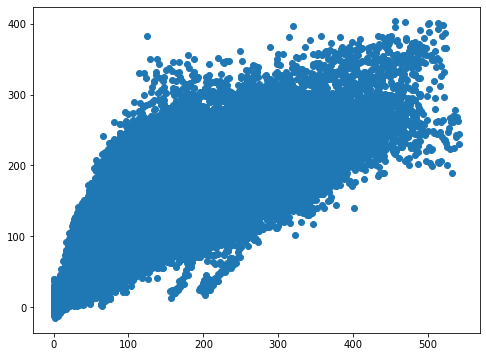

In [38]:
import lightgbm as lgb

regressor = lgb.LGBMRegressor(**best_params)
regressor.fit(X_tr, y_tr, eval_set=(X_te, y_te), verbose=0)
y_pred = regressor.predict(X)

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(y, y_pred)
ax.plot([y_te.min(), y_te.max()], [y_te.min(), y_te.max()], 'k--', lw=4)
ax.set_xlabel('Actual RUL')
ax.set_ylabel('Predicted RUL')
ax.set_title('Remaining Useful Life Actual vs. Predicted')
plt.show()

In [ ]:
'''
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

x_tr, x_te, y_tr, y_te = train_test_split(train_tr, train_te, test_size=0.2)
lgb_class = lgb.LGBMClassifier()
lgb_class.fit(train_tr, train_te)
y_pred = lgb_class.predict(train_tr)

result = pd.DataFrame({'engine_no': train['engine_no'],
                       'RUL': train['RUL'],
                      'prediction': y_pred})

import seaborn as sns
g = sns.PairGrid(data=result, x_vars="RUL", y_vars=['RUL', 'prediction'], hue="engine_no", height=6, aspect=6,)
g = g.map(plt.plot, alpha=0.5)
g = g.set(xlim=(result['RUL'].max(), result['RUL'].min()))
g = g.set(ylim=(0,550))
'''